In [1]:
from pyexpat import features

#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, ConvLSTM1D, Flatten, Dense, Conv1D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import random
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR # Import VAR class
from tensorflow.keras import layers, Model, Input
import tensorflow as tf
from tensorflow.keras.regularizers import l2

import shap
from tqdm import tqdm
# Surpressing Warnings
import warnings
import tensorflow as tf

from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
# Suppress Keras UserWarning about input shape in RNN layers
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Suppress statsmodels ValueWarning about no frequency information
warnings.filterwarnings("ignore", category=ValueWarning, module='statsmodels')

# Suppress statsmodels ConvergenceWarning about optimization failure
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='statsmodels')

# Suppress statsmodels FutureWarning about optimization failure
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

# To suppress all TensorFlow warnings
# warnings.filterwarnings('ignore', category=tf.errors.UserWarning)
warnings.filterwarnings('ignore', message="6 out of the last .* calls to .* triggered tf.function retracing.*", category=UserWarning)



# Loading Transformed Data

In [2]:

file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

t_Data_Dir = 'TData/'
r_State_Dir = "RState/"
all_series_HICP_target_dir = "AllSamplesHICPtarget/"
targetHICP = "HICP"

df_hicp_target = pd.read_csv(filepath_or_buffer = t_Data_Dir + 'full_hicp_target_data_norm.csv', index_col = 0)

df_hicp_target.index.name = 'DATE'


Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


# Column Definitions

In [3]:
# main variables columns
main_vars_cols = pd.read_csv('combined2' + '.csv', header=1, skiprows=[0], index_col = 0).columns.tolist()

# HICP acf/pacf lags columns
pacf_lags_Hicp = list(range(1, 13))
hicp_acf_pacf_lag_cols = [f'HICP_L{lag}' for lag in pacf_lags_Hicp]

# HICP VAE columns
vae_hicp_cols= ['z1', 'z2', 'z3', 'z4', 'z5', 'HICP']

# Feature up to 3 lags columns
feature_3_lags_cols = []
for var in main_vars_cols:
    feature_3_lags_cols.append(var)
    for lag in range(1, 4): # Lags 1, 2, 3
        feature_3_lags_cols.append(f'{var}_L{lag}')


# Utility Functions

In [4]:

sns.set_theme(style="whitegrid") # Apply seaborn visual theme

def plot_forecast(forecasted_series, actual_series, title_name='Forecasted vs Actual CPIAUCSL'):

    fig = plt.figure(figsize=(12, 6)) # Store figure object

    actual_series.index = pd.to_datetime(actual_series.index) # Try converting to DateTimeIndex

    plt.plot(actual_series.index, forecasted_series, label='Forecasted', color='#e41a1c', linestyle='dashed', linewidth=2) # Red for forecast
    plt.plot(actual_series.index, actual_series, label='Actual', color='#377eb8', linestyle='solid', linewidth=2) # Blue for actual

    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Value', fontsize=10)
    plt.title(title_name, fontsize=12)

    # Date formatting for x-axis (using logic from your improved plot_series)
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=90, ha='right', fontsize=10) # Rotate x-axis labels, adjust font size
    plt.gcf().autofmt_xdate() # Auto-format dates

    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout() # Adjust layout

    return fig # Return the figure object (do NOT use plt.show() here if you want to control display later)

def plot_observed_vs_fitted_var(var_model_fit, train_df, target_column='CPIAUCSL', title='VAR Model - Observed vs Fitted (Training)'):

    fitted_values = var_model_fit.fittedvalues # Get fitted values from the VAR model
    observed_train = train_df[target_column]   # Observed values from the training data

    # Extract fitted values for the target column
    fitted_hicp = fitted_values[target_column]

    # Ensure index is DateTimeIndex if possible (align with actual_series index if needed)
    try:
        fitted_hicp.index = pd.to_datetime(fitted_hicp.index)
        observed_train.index = pd.to_datetime(observed_train.index) # Align observed index too for plotting
        if not fitted_hicp.index.equals(observed_train.index): # If indexes still not the same, try to align based on actual index
            fitted_hicp.index = observed_train.index # Force index alignment for plotting if possible
    except ValueError:
        print("Warning: Could not convert index to DateTime for Observed vs Fitted plot.")
        pass # Plot without DateTimeIndex if conversion fails

    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_hicp.index, fitted_hicp, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=12)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Value", fontsize=10)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator() # Use observed_train index for locator
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    plt.show()
    return fig

def plot_predictions(y_actual, y_pred, train_index, title='CNN-LSTM: Actual vs Forecasted Values'):
    """Plots actual vs forecasted values."""
    train_index = pd.to_datetime(train_index)
    fig = plt.figure(figsize=(12, 6))
    plt.plot(train_index, y_actual, label='Actual', color='blue', linestyle='solid')
    plt.plot(train_index, y_pred, label='Forecasted', color='red', linestyle='dashed')

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title, fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_loss(history):
    # Plots loss function
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM - Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

def plot_observed_vs_fitted(y_train, predictions_train, train_index):
    fig = plt.figure(figsize=(12, 6))
    train_index = pd.to_datetime(train_index)
    plt.plot(train_index, y_train, label="Observed (Train)", linestyle="solid")
    plt.plot(train_index, predictions_train, label="Fitted (Train)", linestyle="solid")
    plt.title("CNN-LSTM - Observed vs. Fitted Values")

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_arima_observed_vs_fitted(arima_model_fit, train_data, target_column, title='ARIMA Model - Observed vs Fitted (Training)'):
    """
    Plots observed vs fitted values for an ARIMA model on the training data,
    handling cases where fittedvalues might not have an index and ensuring index alignment.
    Includes enhanced index debugging.
    """

    observed_train = train_data[target_column] if isinstance(train_data, pd.DataFrame) else train_data # Handle DataFrame or Series input for train_data
    fitted_series = arima_model_fit.fittedvalues    # Ensure only train data is plotted (if fittedvalues has more values)

    num_values_to_keep = observed_train.index.shape[0]
    fitted_series_train = fitted_series[:num_values_to_keep]

    fitted_series_reduced = pd.Series(fitted_series_train, index=observed_train.index)

    # Extract fitted values for the target column
    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_series_reduced.index, fitted_series_train, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    return fig


# HICP

# Creating Train and Test Data

In [5]:
df = df_hicp_target[main_vars_cols]
target = "HICP"

In [6]:

test_size = int(len(df) * 0.2)  # Convert percentage to absolute count
# test_size = 12  # Convert percentage to absolute count
train_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]

print(train_df.shape)
print(test_df.shape)


(238, 21)
(59, 21)


# VAR Model Training & Testing
Given that we need more observations than parameters. A rough formula:

Required observations > lag_order × num_variables²

We need to reduce the maxlags or number of variables.


In [9]:

model = VAR(train_df)

# AIC based lag order (your original code)
lag_order_aic = model.select_order(maxlags=5).aic
print(f"AIC-based Lag Order: {lag_order_aic}")

# BIC based lag order
lag_order_bic = model.select_order(maxlags=5).bic
print(f"BIC-based Lag Order: {lag_order_bic}")

# HQIC based lag order
lag_order_hqic = model.select_order(maxlags=5).hqic
print(f"HQIC-based Lag Order: {lag_order_hqic}")

# Choose the lag order based on the criteria you prefer or by comparing performance with different lag orders.
var_lag_order = lag_order_aic # or lag_order_bic, or lag_order_hqic
var_model = model.fit(var_lag_order)
print(var_lag_order)

# var_model.summary()


AIC-based Lag Order: 5
BIC-based Lag Order: 0
HQIC-based Lag Order: 1
5


In [10]:

def var_forecast(model, train_df, test_df, lag_order, forecast_horizon):

    input_data = train_df.values[-lag_order:]
    forecast = model.forecast(y=input_data, steps=forecast_horizon)

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(forecast, columns=train_df.columns, index=test_df.index)

    # -------------------------------
    # EVALUATE ON TARGET
    # -------------------------------
    actual_hicp = test_df[target]
    forecasted_hicp = forecast_df[target]

    # Compute evaluation metrics
    mae = mean_absolute_error(actual_hicp, forecasted_hicp)
    rmse = np.sqrt(mean_squared_error(actual_hicp, forecasted_hicp))

    abs_err = np.abs(actual_hicp.values - forecasted_hicp.values)
    # print(f"Abs Err: {abs_err}")

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return model, forecasted_hicp, actual_hicp, train_df, mae, rmse



# ***Results***


Mean Absolute Error (MAE): 1.2257508457049788
Root Mean Squared Error (RMSE): 1.711660648796017


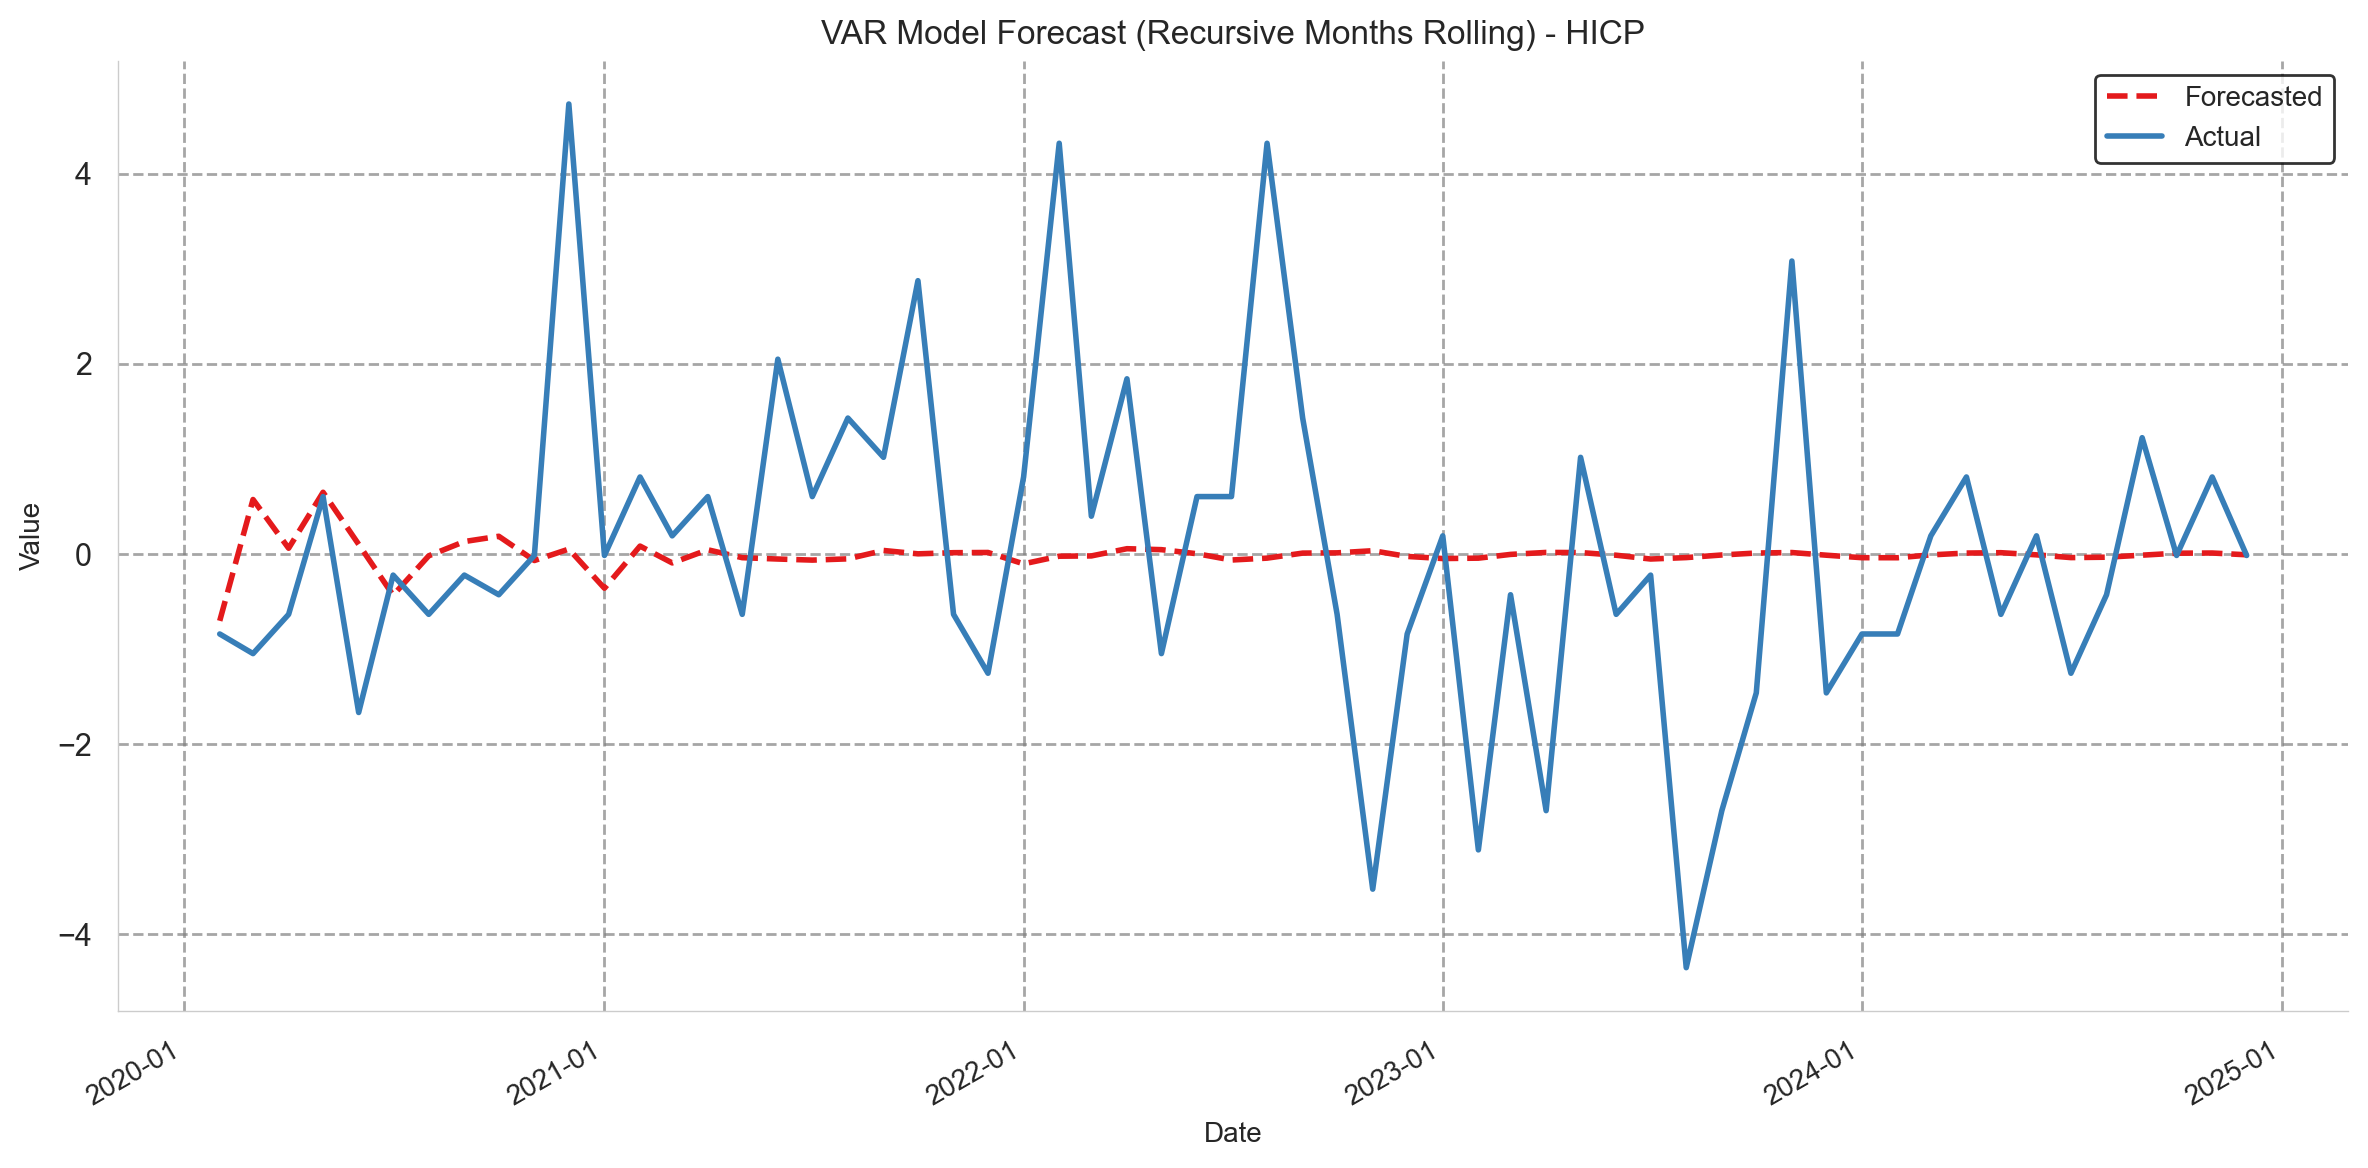

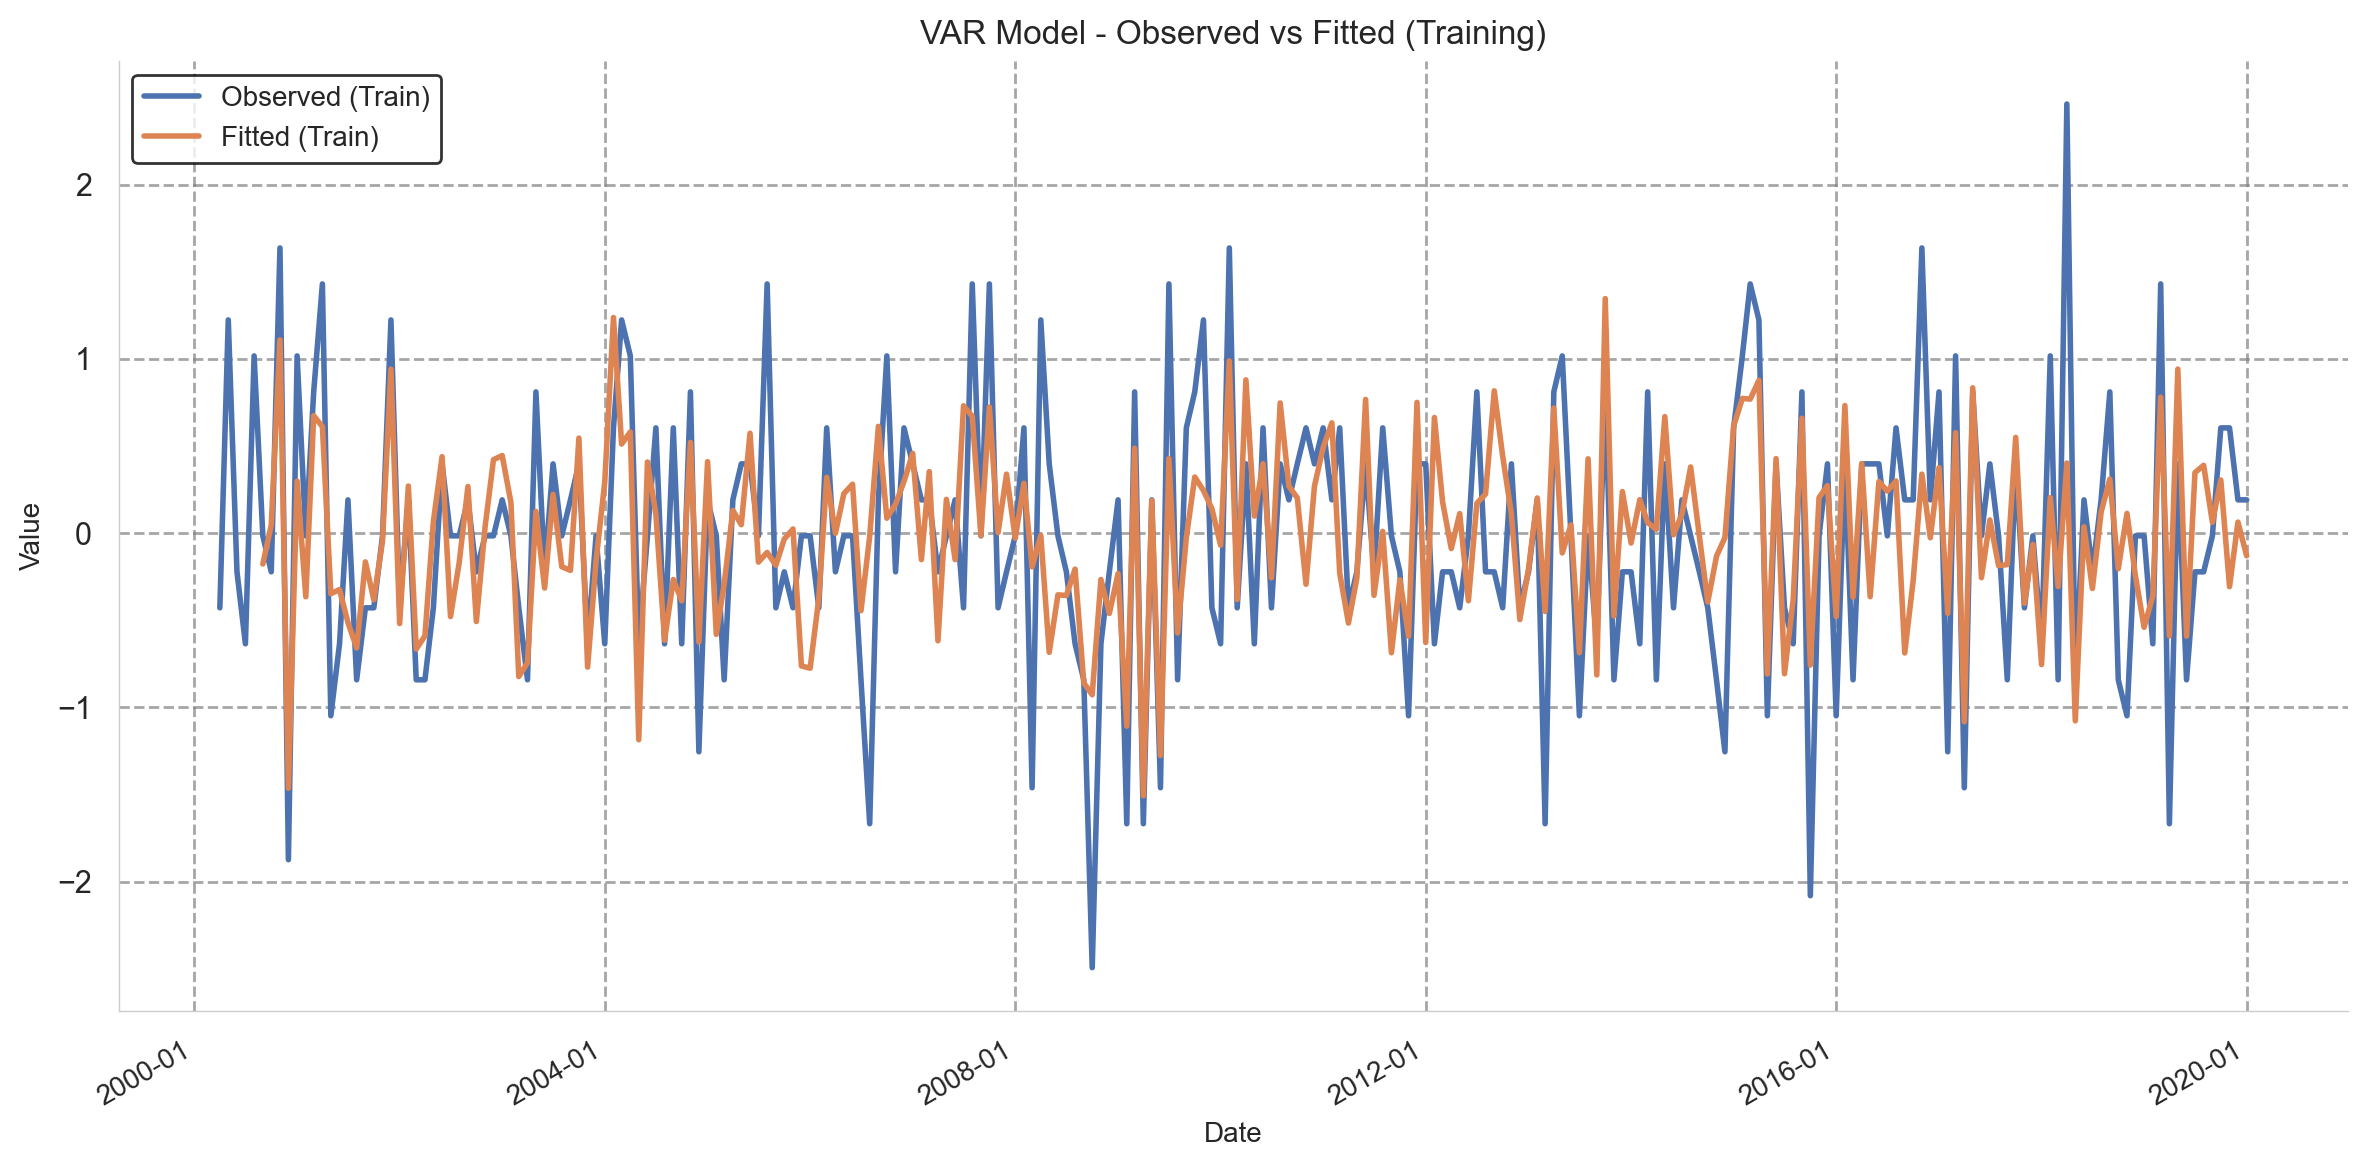

In [11]:
# # Forecast the next 12 months
model, forecasted_hicp, actual_hicp, var_train_df, var_mae, var_rmse = var_forecast(var_model, train_df.copy(), test_df.copy(), var_lag_order, test_size)
var_model_forecast_plot = plot_forecast(forecasted_hicp, actual_hicp, title_name='VAR Model Forecast (Recursive Months Rolling) - HICP')
var_observed_vs_fitted_plot = plot_observed_vs_fitted_var(model, var_train_df, target, 'VAR Model - Observed vs Fitted (Training)')


# ***ARIMA Training and Test***

In [12]:
# Extract HICP series for ARIMA
train_hicp_arima = train_df.copy()[target]
test_hicp_arima = test_df.copy()[target]

In [13]:
# For ARIMA order selection (non-seasonal):
auto_arima_model_arima = auto_arima(train_hicp_arima, seasonal=False, stepwise=True,
                                    suppress_warnings=True, error_action="ignore", max_order=10, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=516.998, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=541.858, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=528.697, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=532.546, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=526.380, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=526.938, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=524.874, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=526.395, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=527.733, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=523.411, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=522.293, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=518.969, Time=0.11 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 0.615 seconds


# Results

In [14]:
arima_forecast_df, arima_mae, arima_rmse = arima_mm_forecast(train_df, test_df, auto_arima_model_arima, test_size)

NameError: name 'arima_mm_forecast' is not defined

# ***SARIMA Training & Test***


In [13]:
# For SARIMA order selection (seasonal):
train_hicp_sarima = train_df[target]
auto_arima_model_sarima = auto_arima(train_hicp_sarima, seasonal=True, m=12, stepwise=True, # m=12 for monthly seasonality
                                     suppress_warnings=True, error_action="ignore", max_order=10, trace=True,
                                     max_p=10, max_q=10, max_P=10, max_Q=10, verbose=0) # Limit search space


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=143.153, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=635.390, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=334.893, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=633.393, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=204.653, Time=0.26 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=140.304, Time=0.96 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=158.656, Time=0.75 sec
 ARIMA(2,0,2)(3,0,1)[12] intercept   : AIC=135.026, Time=1.95 sec
 ARIMA(2,0,2)(3,0,0)[12] intercept   : AIC=131.036, Time=2.08 sec
 ARIMA(2,0,2)(4,0,0)[12] intercept   : AIC=133.955, Time=3.98 sec
 ARIMA(2,0,2)(4,0,1)[12] intercept   : AIC=135.039, Time=3.96 sec
 ARIMA(1,0,2)(3,0,0)[12] intercept   : AIC=87.367, Time=1.61 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC

In [14]:

def sarima_mm_forecast(train_df, test_df, auto_arima_model_sarima, test_size, target_column=target):

    # Extract HICP series for ARIMA
    train_hicp_arima = train_df[target_column]
    test_hicp_arima = test_df[target_column]

    # Ensure the index is datetime for proper date manipulation
    train_hicp_arima.index = pd.to_datetime(train_hicp_arima.index)

    history = train_hicp_arima.tolist()
    sarima_model = SARIMAX(history,
                          order=auto_arima_model_sarima.order,
                          seasonal_order=auto_arima_model_sarima.seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

    sarima_model_fit = sarima_model.fit(disp=False)  # disp=False to suppress convergence output
    forecast = sarima_model_fit.forecast(steps=test_size)

    forecast_df = pd.DataFrame(forecast, index=test_hicp_arima.index, columns=[target_column])

    mae_sarima = mean_absolute_error(test_hicp_arima, forecast_df[target_column])
    rmse_sarima = np.sqrt(mean_squared_error(test_hicp_arima, forecast_df[target_column]))

    # Print evaluation metrics
    print(f'Rolling SARIMA Model - Mean Absolute Error (MAE): {mae_sarima:.4f}')
    print(f'Rolling SARIMA Model - Root Mean Squared Error (RMSE): {rmse_sarima:.4f}')

    # Plot the forecast and the fitted model
    print("DETAILS")
    print(forecast_df.shape)
    print(test_hicp_arima.shape)
    print(sarima_model_fit.fittedvalues.shape)
    sarima_forecast = plot_forecast(forecast_df, test_hicp_arima, title_name='Rolling SARIMA Model Forecast - HICP')
    sarima_fitted = plot_arima_observed_vs_fitted(sarima_model_fit, train_df, target_column=target_column, title='SARIMA Model - Observed vs Fitted (24 Months Rolling)')
    plt.show()

    return sarima_forecast, mae_sarima, rmse_sarima



# Result

Rolling SARIMA Model - Mean Absolute Error (MAE): 0.8807
Rolling SARIMA Model - Root Mean Squared Error (RMSE): 1.2524
DETAILS
(54, 1)
(54,)
(218,)


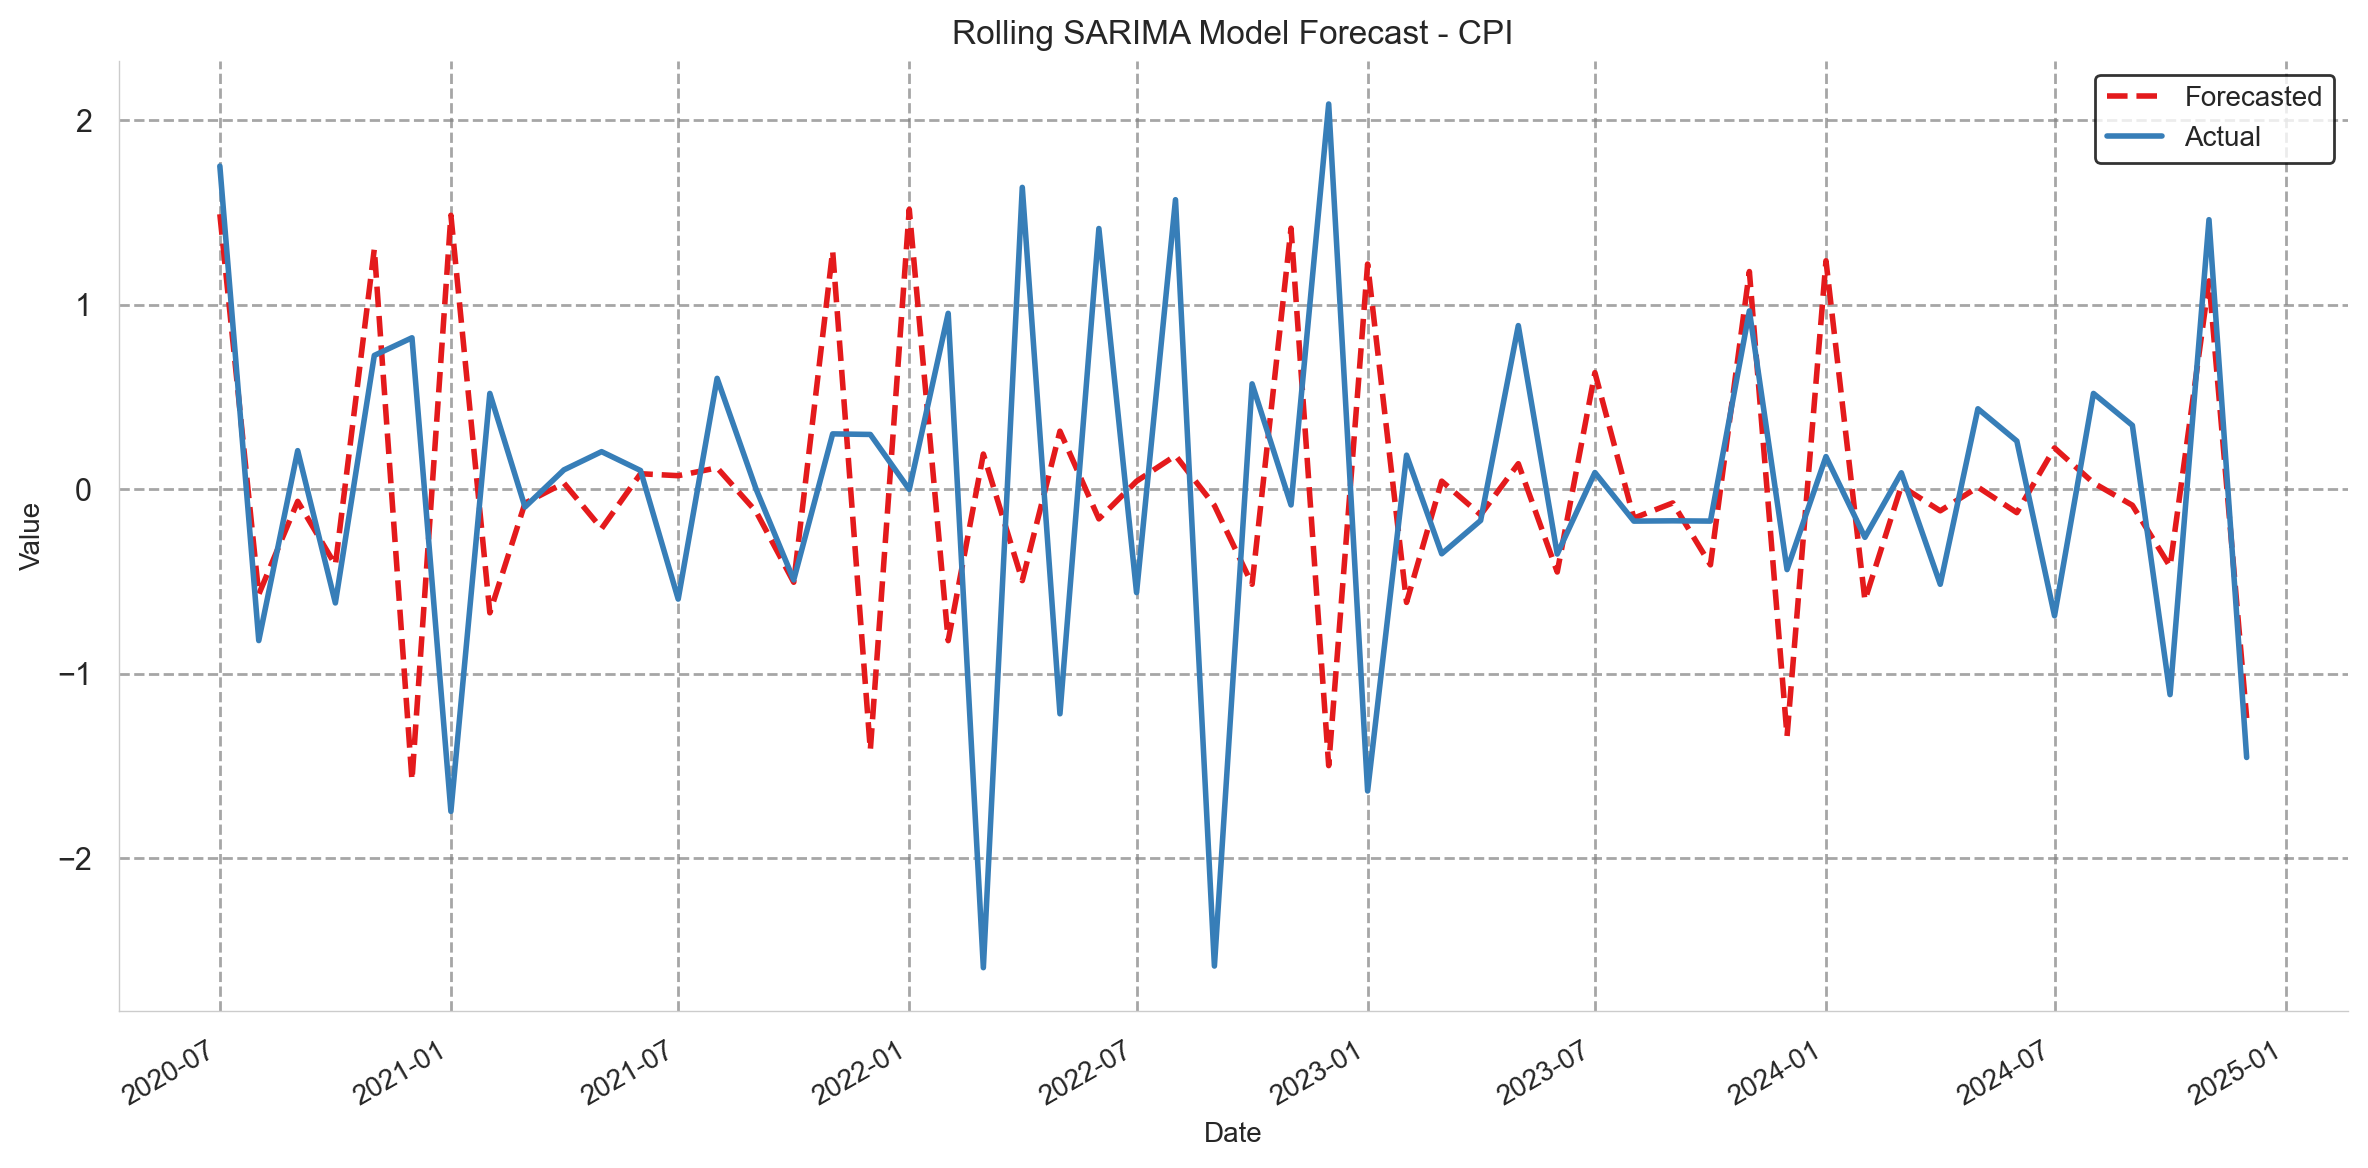

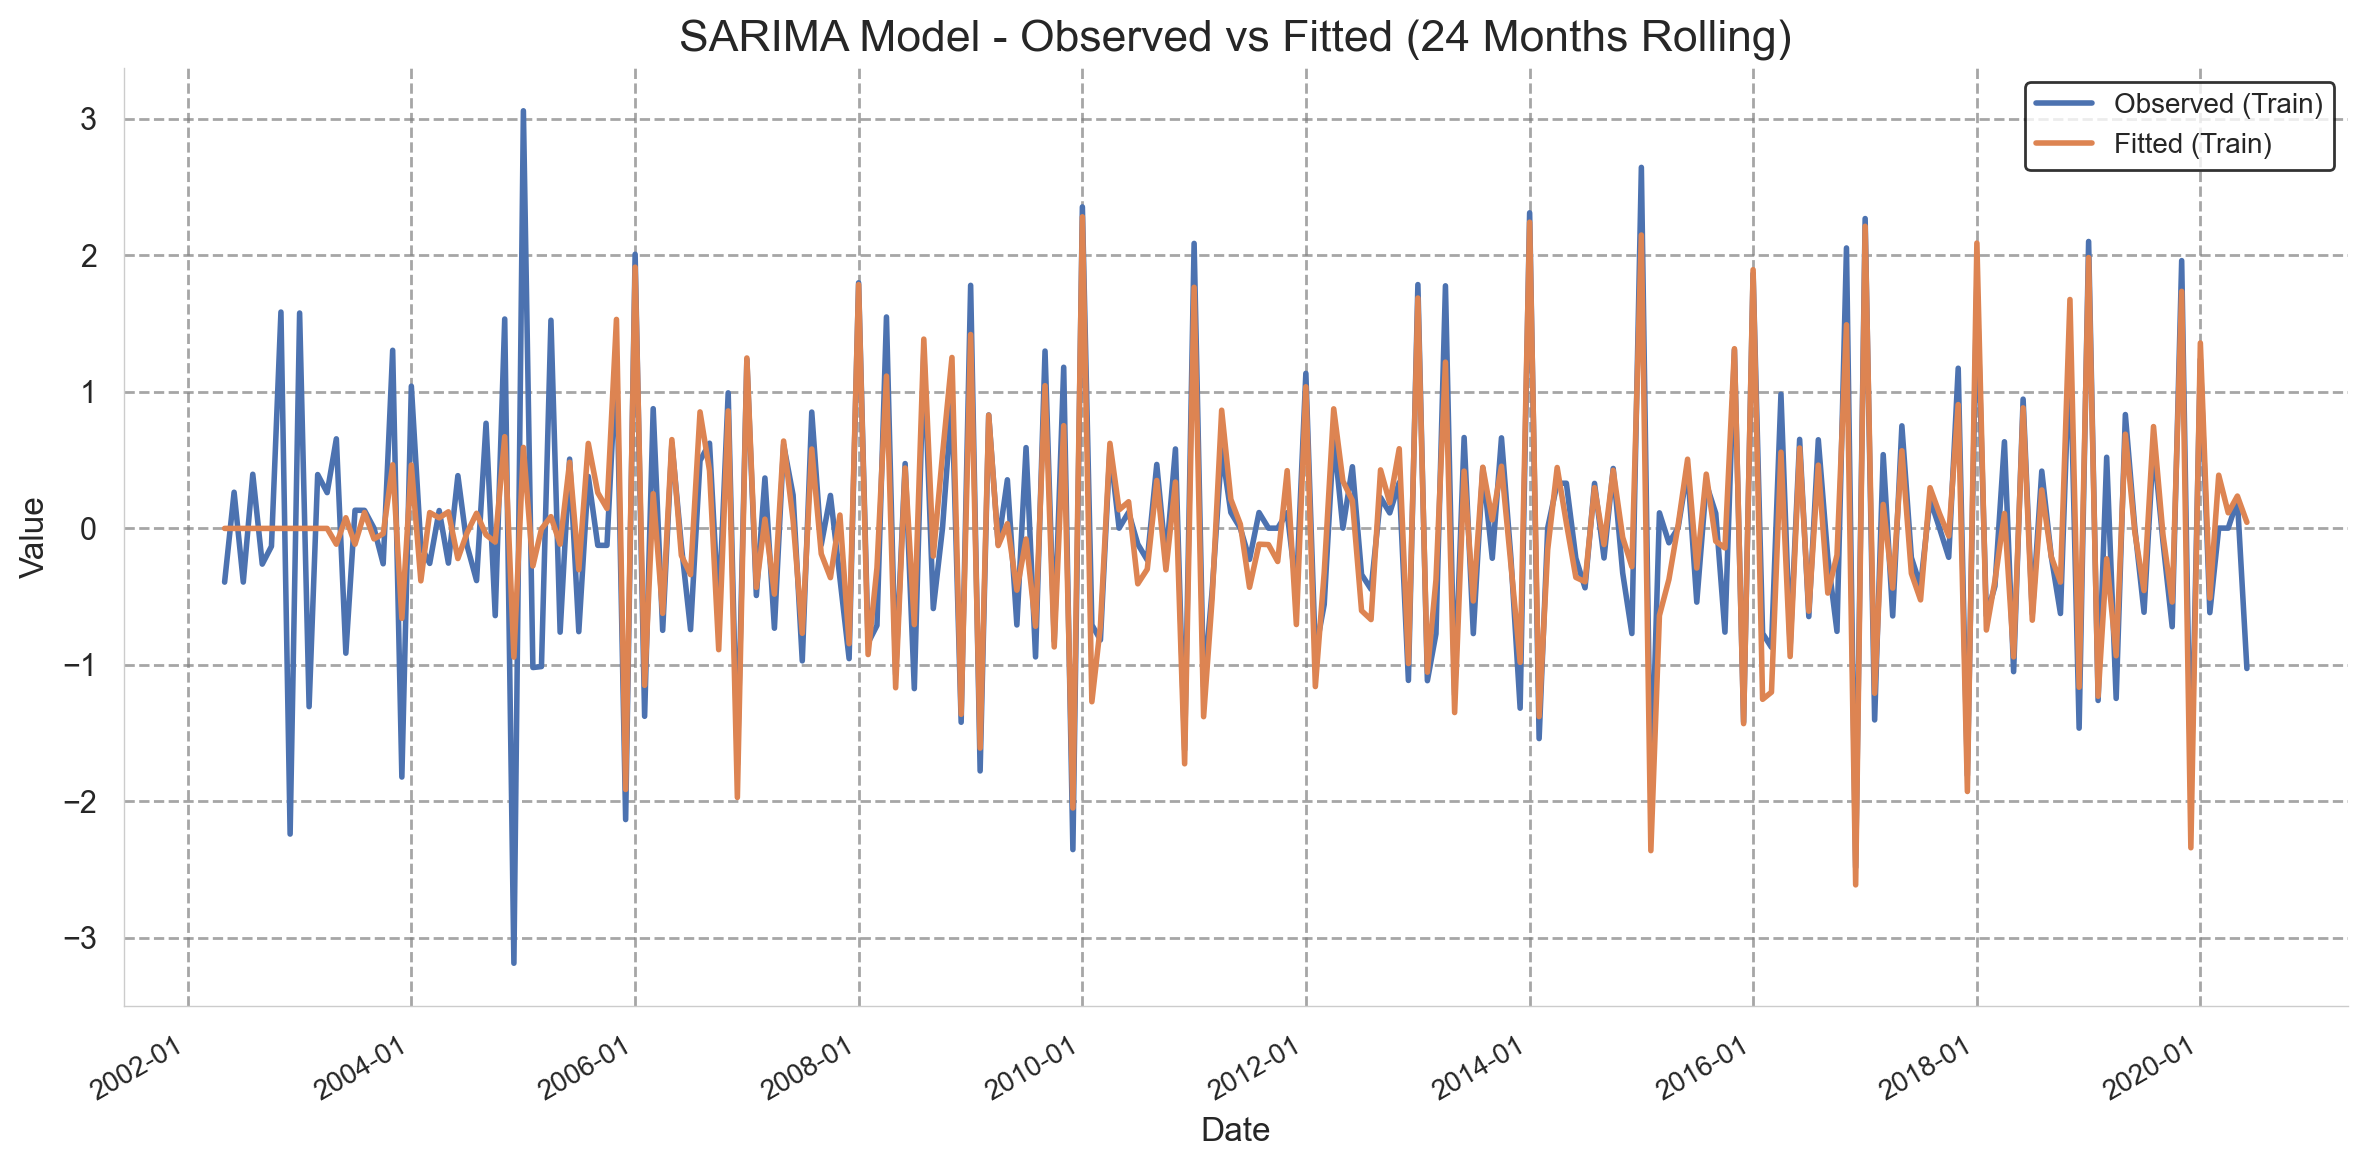

In [15]:

sarima_forecast, sarima_mae, sarima_rmse = sarima_mm_forecast(train_df, test_df, auto_arima_model_sarima, test_size)


# ***CNN-LSTM Training & Testing***

In [16]:

def prepare_data_convlstm2D(data, target_column, test_size, sequence_length=4, grid_shape=(5, 4)):
    """
    Prepares the data for ConvLSTM2D using temporal sequences and reshapes features into spatial grids.
    """
    feature_names = [col for col in data.columns if col != target_column]
    total_features = len(feature_names)
    rows, cols = grid_shape
    grid_size = rows * cols
    assert grid_size >= total_features, "Grid shape is too small for number of features."

    # Padding mask
    def pad_features(features):
        padded = np.zeros((features.shape[0], grid_size))
        padded[:, :features.shape[1]] = features
        return padded.reshape(features.shape[0], rows, cols, 1)

    # Generate sequences
    X, y, indices = [], [], []
    for i in range(len(data) - sequence_length):
        seq_x = data.iloc[i:i+sequence_length][feature_names].values
        seq_y = data.iloc[i + sequence_length][target_column]
        X.append(seq_x)
        y.append(seq_y)
        indices.append(data.index[i + sequence_length])

    X = np.array(X)  # shape: (samples, timesteps, features)
    y = np.array(y).reshape(-1, 1)
    indices = np.array(indices)

    # Normalize
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_flat = X.reshape(-1, total_features)
    X_scaled = scaler_X.fit_transform(X_flat).reshape(X.shape)
    y_scaled = scaler_y.fit_transform(y)

    # Reshape for ConvLSTM2D: (samples, timesteps, rows, cols, channels)
    X_reshaped = np.array([
        pad_features(sample) for sample in X_scaled
    ])  # shape: (samples, timesteps, rows, cols, 1)

    # Split train/test
    X_train = X_reshaped[:-test_size]
    y_train = y_scaled[:-test_size]
    X_test = X_reshaped[-test_size:]
    y_test = y_scaled[-test_size:]
    train_index = indices[:-test_size]
    test_index = indices[-test_size:]

    # Input shape for ConvLSTM2D layer
    input_shape = X_reshaped.shape[1:]  # (timesteps, rows, cols, channels)

    return X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names, input_shape

def prepare_data_conv_1D(data, target_column, test_size):
    data_x = data.copy()
    train_df = data_x.iloc[:-test_size]
    test_df = data_x.iloc[-test_size:]
    train_index = train_df.index
    test_index = test_df.index

    feature_names_used = data_x.drop(target_column, axis=1).columns.tolist()
    X_train = train_df.drop(target_column, axis=1).values
    y_train = train_df[target_column].values.reshape(-1, 1)
    X_test = test_df.drop(target_column, axis=1).values
    y_test = test_df[target_column].values.reshape(-1, 1)

    # Initialize scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit scalers on training data only
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)

    # Transform test data
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    # Reshape for Conv1D: [samples, timesteps, features]
    X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    input_shape = (X_train.shape[1], X_train.shape[2])
    return X_train, y_train_scaled, X_test, y_test_scaled, train_index, test_index, scaler_y, feature_names_used, input_shape



In [17]:

def build_model_convlstm2D(input_shape):
    """
    Builds and compiles a ConvLSTM2D model with input shape:
    (timesteps, rows, cols, channels)
    """
    model = Sequential([
        ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh', return_sequences=True, input_shape=input_shape, padding='same', kernel_regularizer=l2(0.002)),
        Dropout(0.2),
        ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', return_sequences=False, padding='same', kernel_regularizer=l2(0.002)),
        Dropout(0.2),
        Flatten(),
        Dense(64, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_model_conv1D(input_shape):
    model = Sequential([
        Conv1D(filters=16, kernel_size=1, activation='tanh', input_shape=input_shape, kernel_regularizer=l2(0.002)),
        Dropout(0.2),
        Conv1D(filters=8, kernel_size=1, activation='tanh', kernel_regularizer=l2(0.002)),
        Dropout(0.2),
        Flatten(),
        # Dense(32, activation='tanh'),
        Dense(1)
    ])
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model

def build_model_convlstm1D(input_shape):
    """Builds a hybrid CNN-LSTM model."""
    model = Sequential([
        Conv1D(filters=16, kernel_size=1, activation='tanh', input_shape=input_shape, kernel_regularizer=l2(0.002)),
        LSTM(16, return_sequences=True),
        Dropout(0.2),
        Conv1D(filters=8, kernel_size=1, activation='tanh', kernel_regularizer=l2(0.002)),
        LSTM(8, return_sequences=True),
        Dropout(0.2),
        # LSTM(16),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_model(model, X_train, y_train, batch_size=16):
    """Trains the model with early stopping."""
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_dataset, epochs=600, callbacks=[early_stopping], verbose=0)
    return history

def evaluate_model(model, X_test, y_test, batch_size=16):
    """Evaluates the model and returns the test loss and predictions."""
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size)
    test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)
    loss = model.evaluate(test_dataset, verbose=0)
    predictions = model.predict(test_dataset, verbose=0)
    return loss, predictions

def inverse_transform(scaler, data):
    """Inverse transforms the scaled data."""
    return scaler.inverse_transform(data.reshape(-1, 1))

def model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index):
    history = train_model(model, X_train, y_train)
    loss, predictions = evaluate_model(model, X_test, y_test)
    y_test_actual = inverse_transform(scaler_y, y_test)
    predictions_actual = inverse_transform(scaler_y, predictions)
    mae = mean_absolute_error(y_test_actual, predictions_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))

    predictions_train = model.predict(X_train, verbose=0) # Predict on X_train
    predictions_train_actual = inverse_transform(scaler_y, predictions_train) # Inverse transform fitted values
    y_train_actual = inverse_transform(scaler_y, y_train) # Inverse transform y_train
    # --- Plot Observed vs Fitted on Training Data ---
    plot_cnn_forecast = plot_predictions(y_test_actual, predictions_actual, test_index)
    plot_cnn_obs_vs_fitted = plot_observed_vs_fitted(y_train_actual, predictions_train_actual, train_index) # Pass y_train_actual and predictions_train_actual
    print(f'Mean Absolute Error (MAE): {mae:.8f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.8f}')

    return model, X_train, X_test, mae, rmse



Variant CNN Models

In [18]:
def convlstm2D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_convlstm2D(data, target, test_size=test_size)
    model = build_model_convlstm2D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used

def conv1D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size)
    model = build_model_conv1D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used

def convlstm1D(data, targetCpi, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size)
    model = build_model_convlstm1D((X_train.shape[1], X_train.shape[2]))
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used


CNN 1D (C1D) No feature engineering

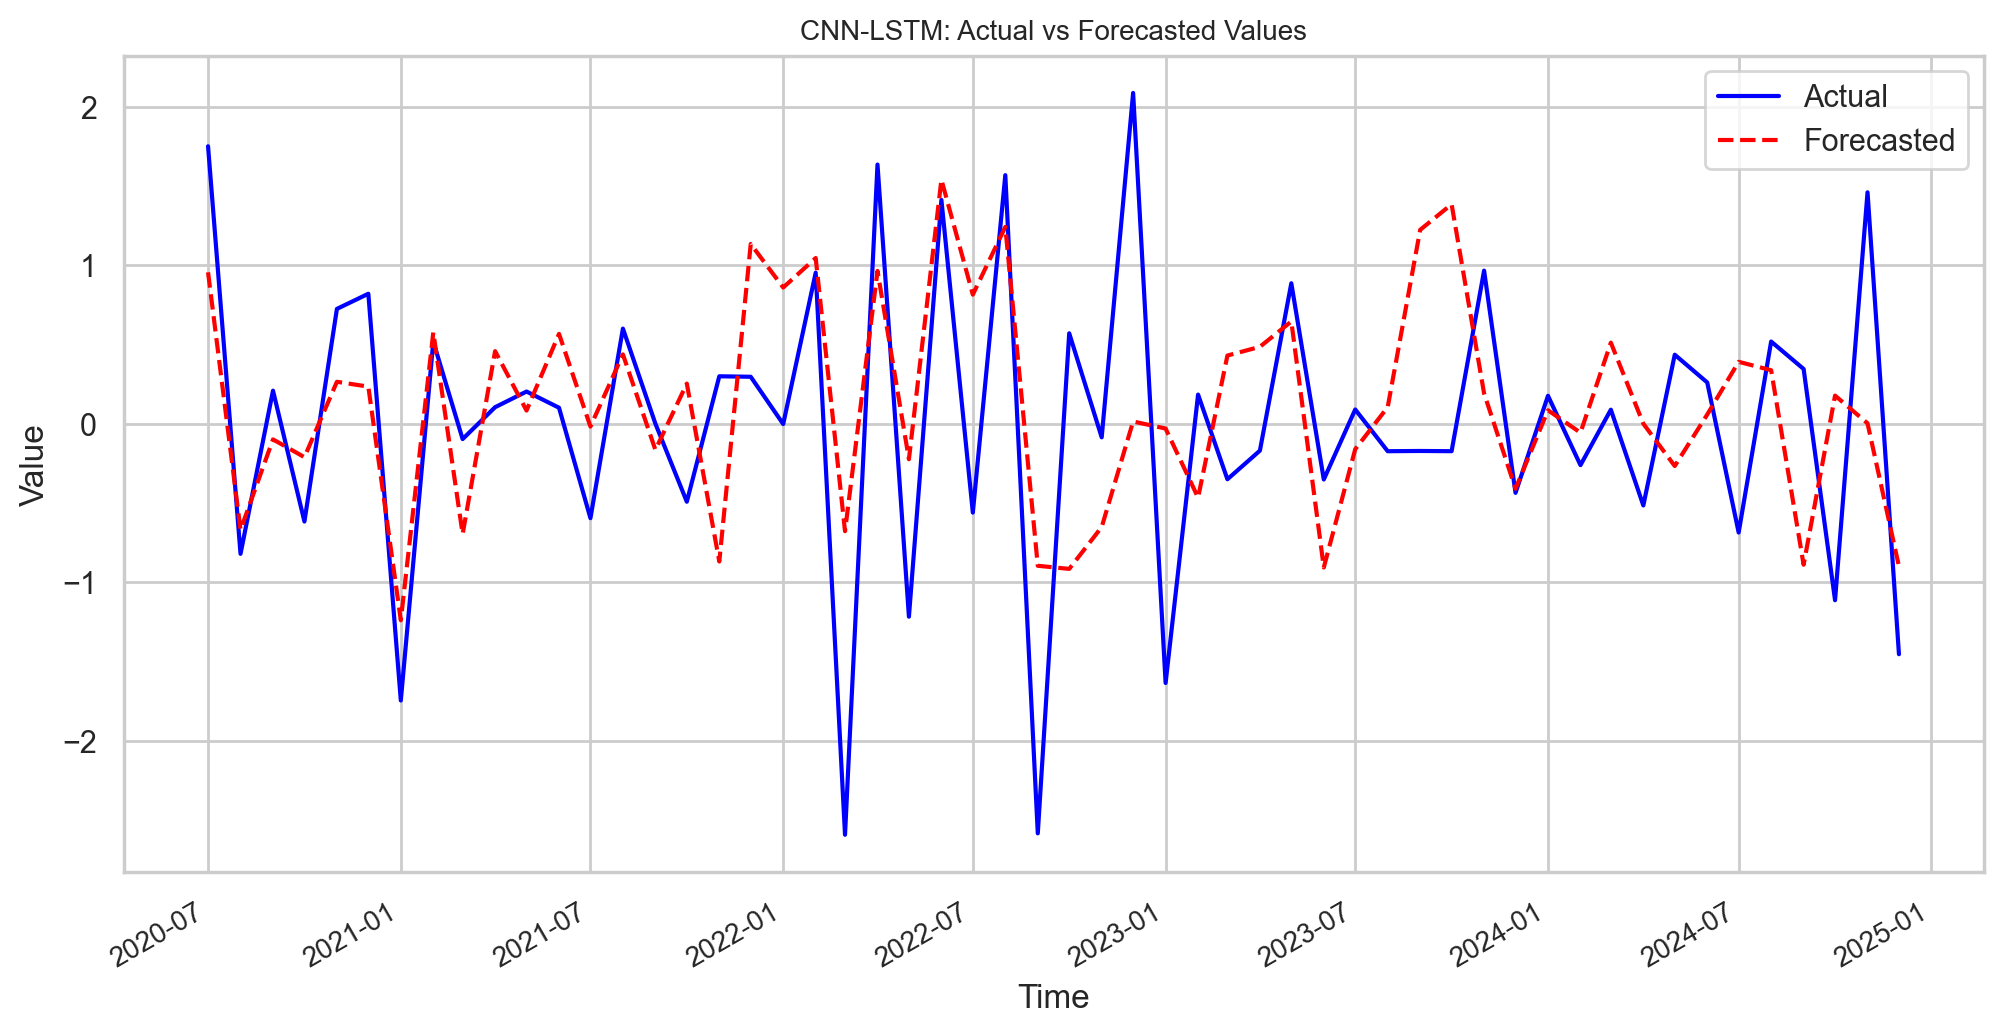

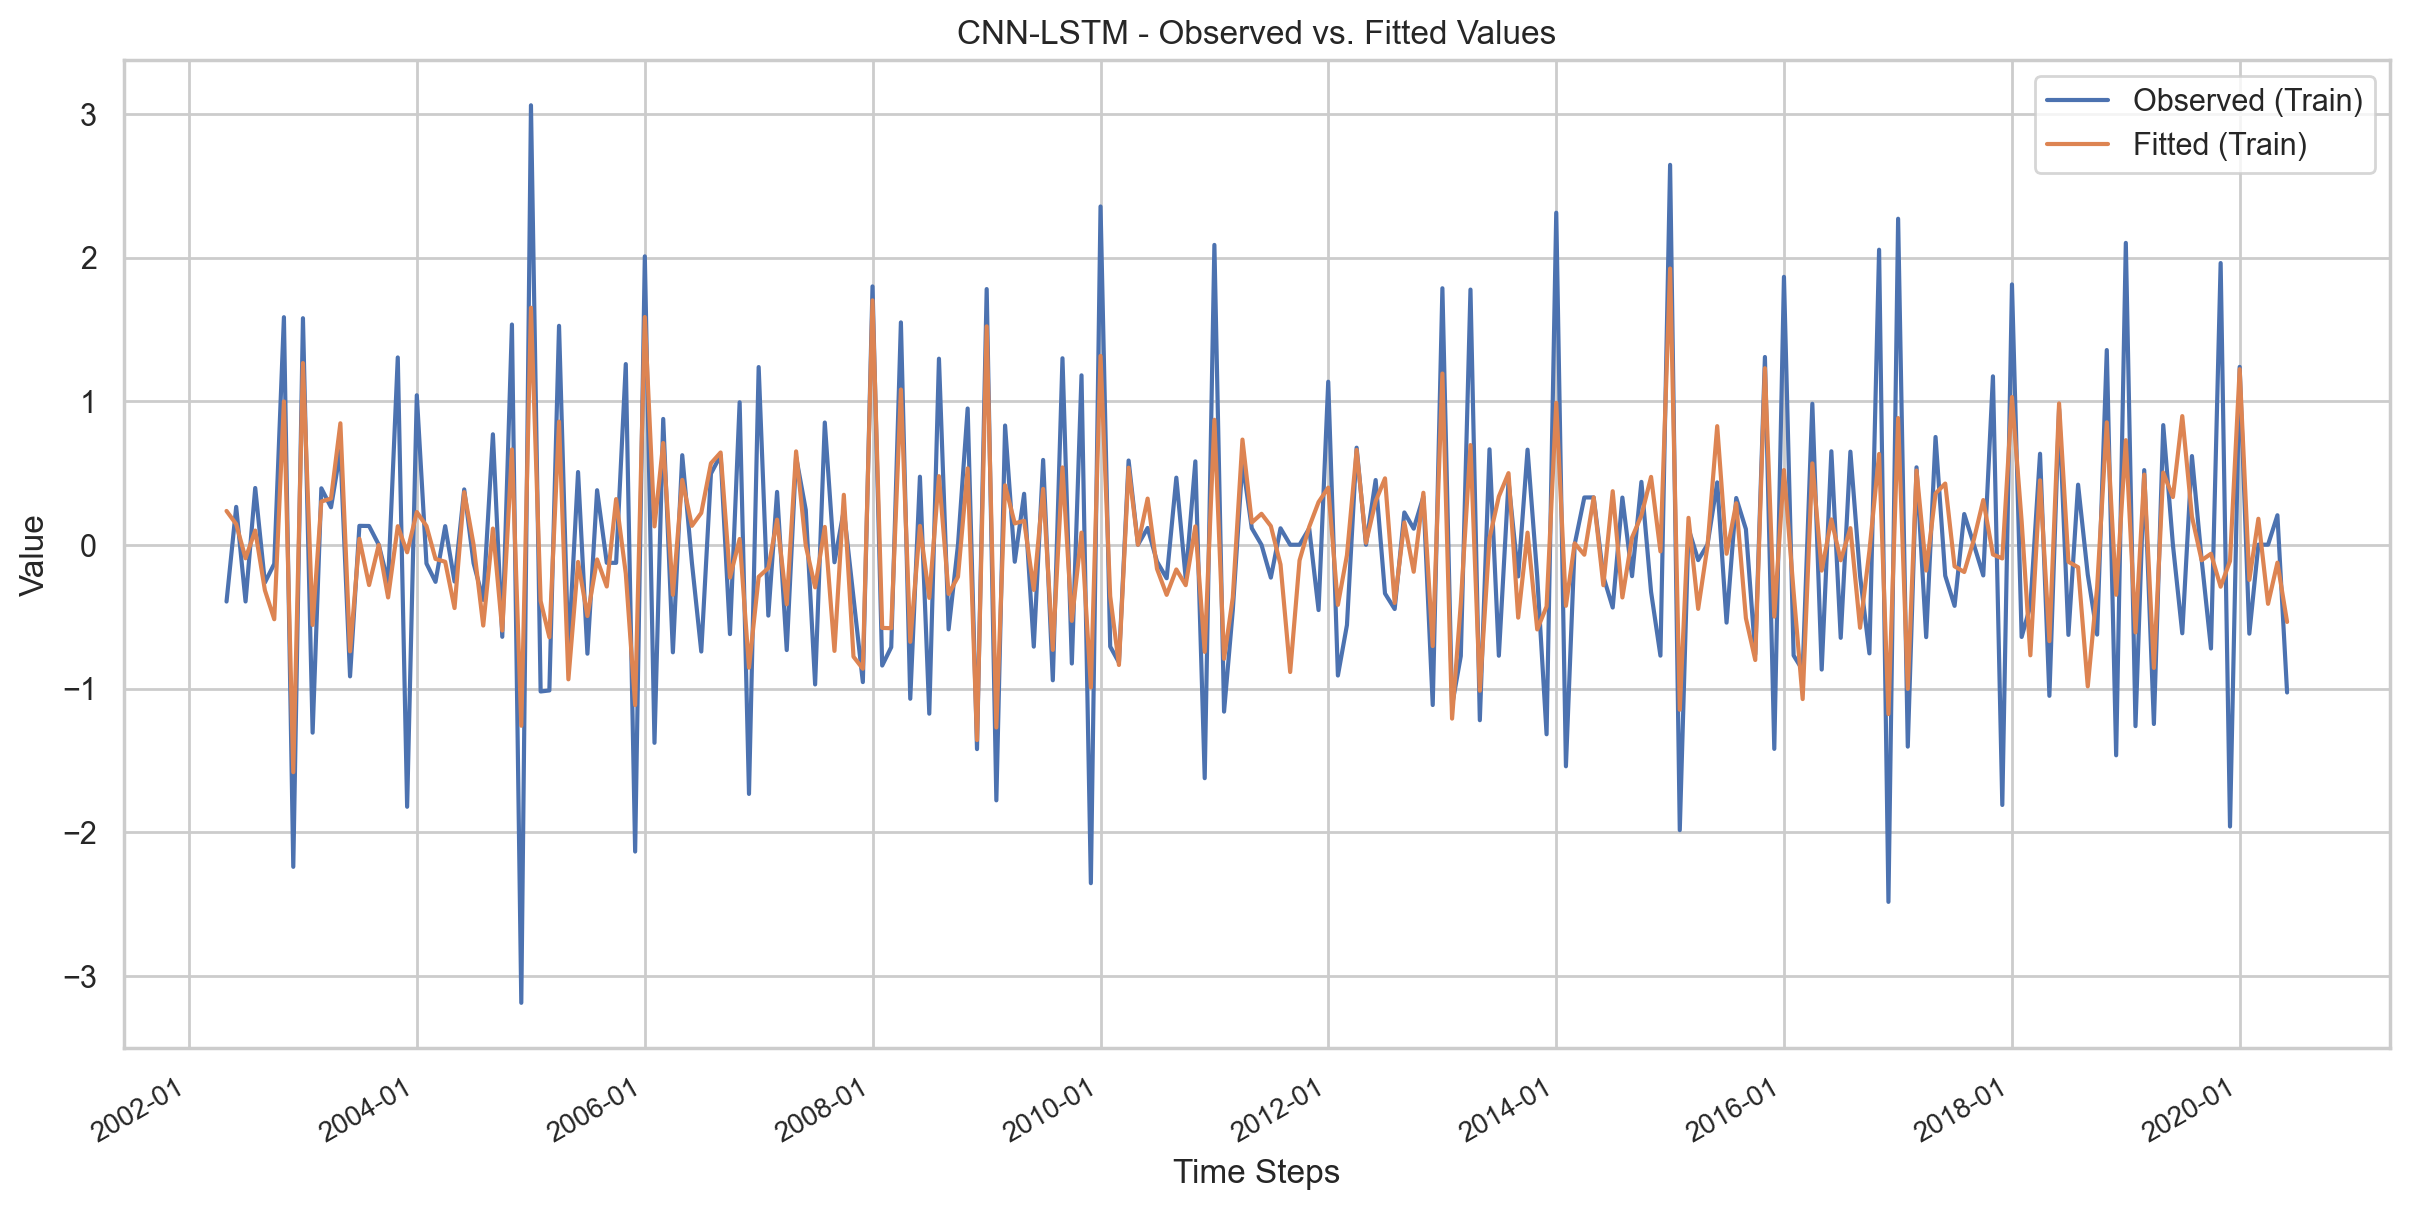

Mean Absolute Error (MAE): 0.69175681
Root Mean Squared Error (RMSE): 0.86475686


In [19]:
model_C1D_nfe, X_train_C1D_nfe, X_test_C1D_nfe, mae_C1D_nfe, rmse_C1D_nfe, fnames_C1D_nfe = conv1D(df,target, test_size)

CNN 1D (C1D) + Feature Engineered 3 lags

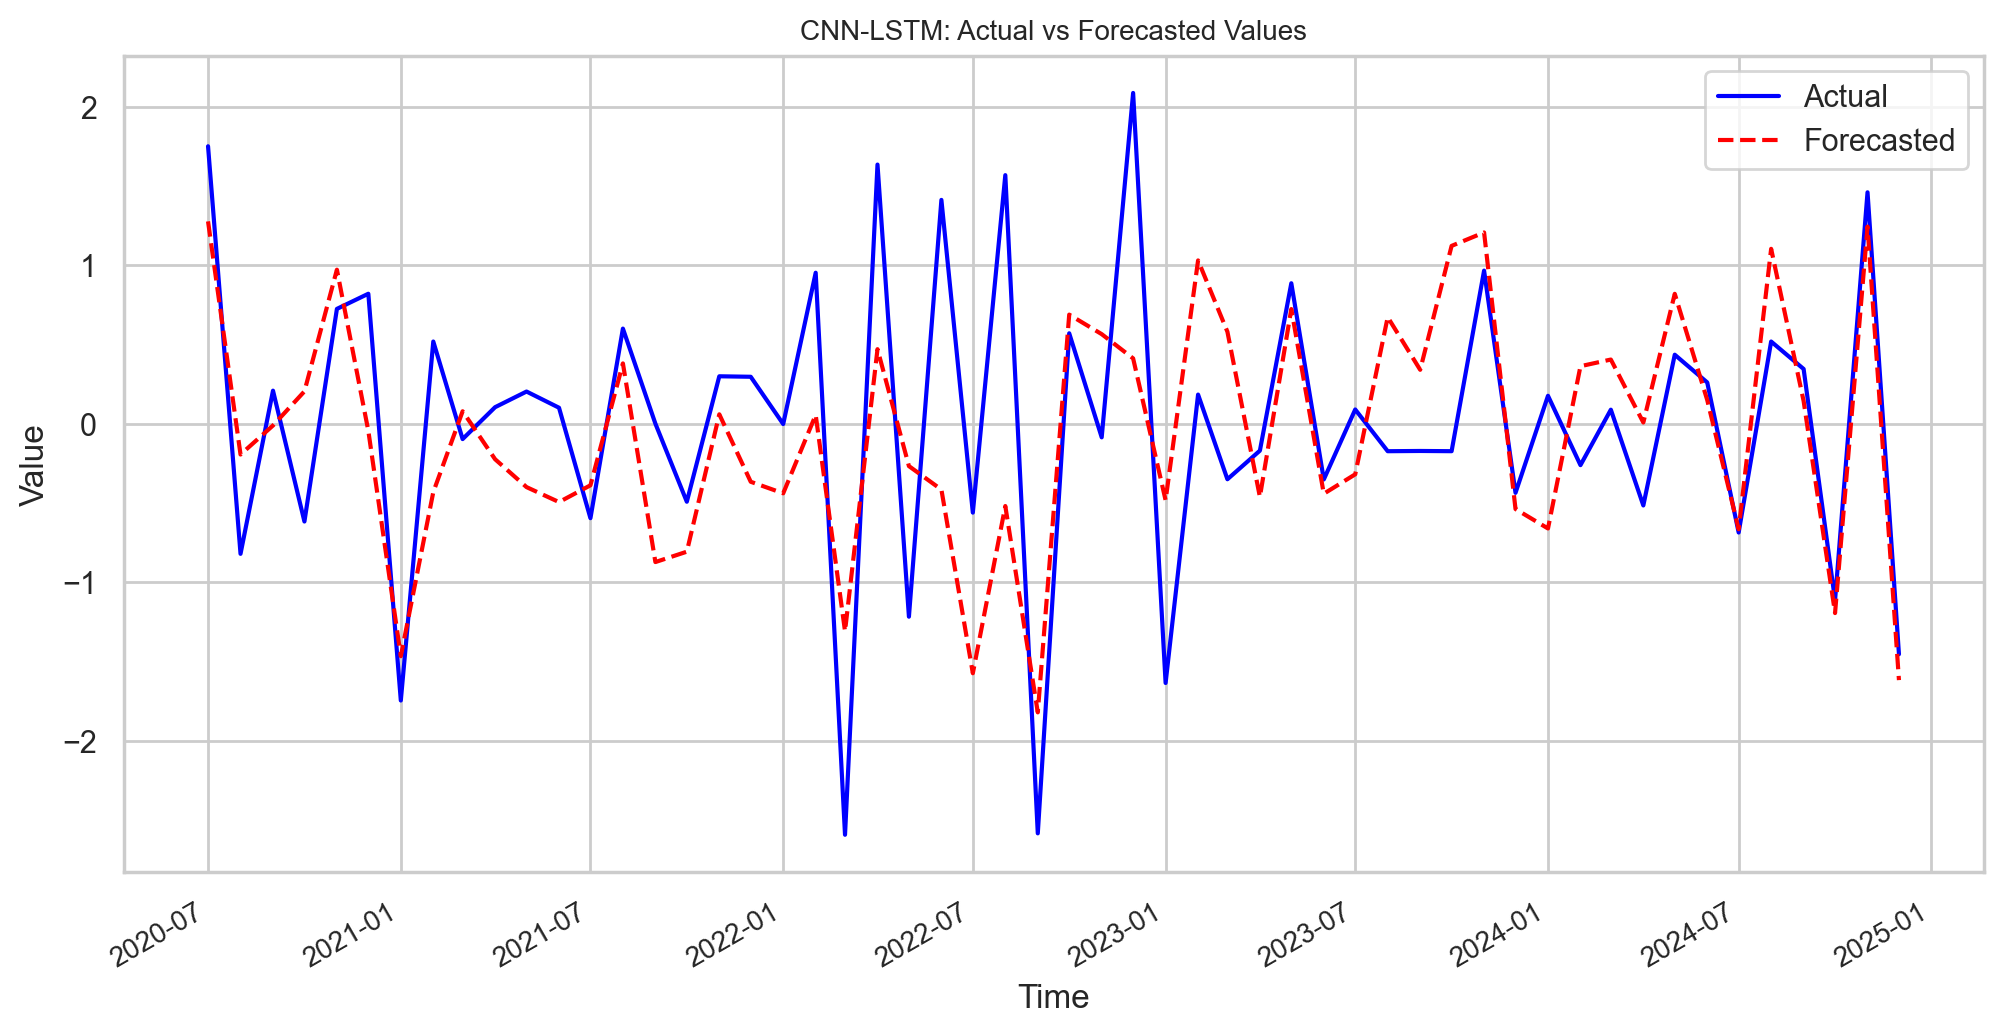

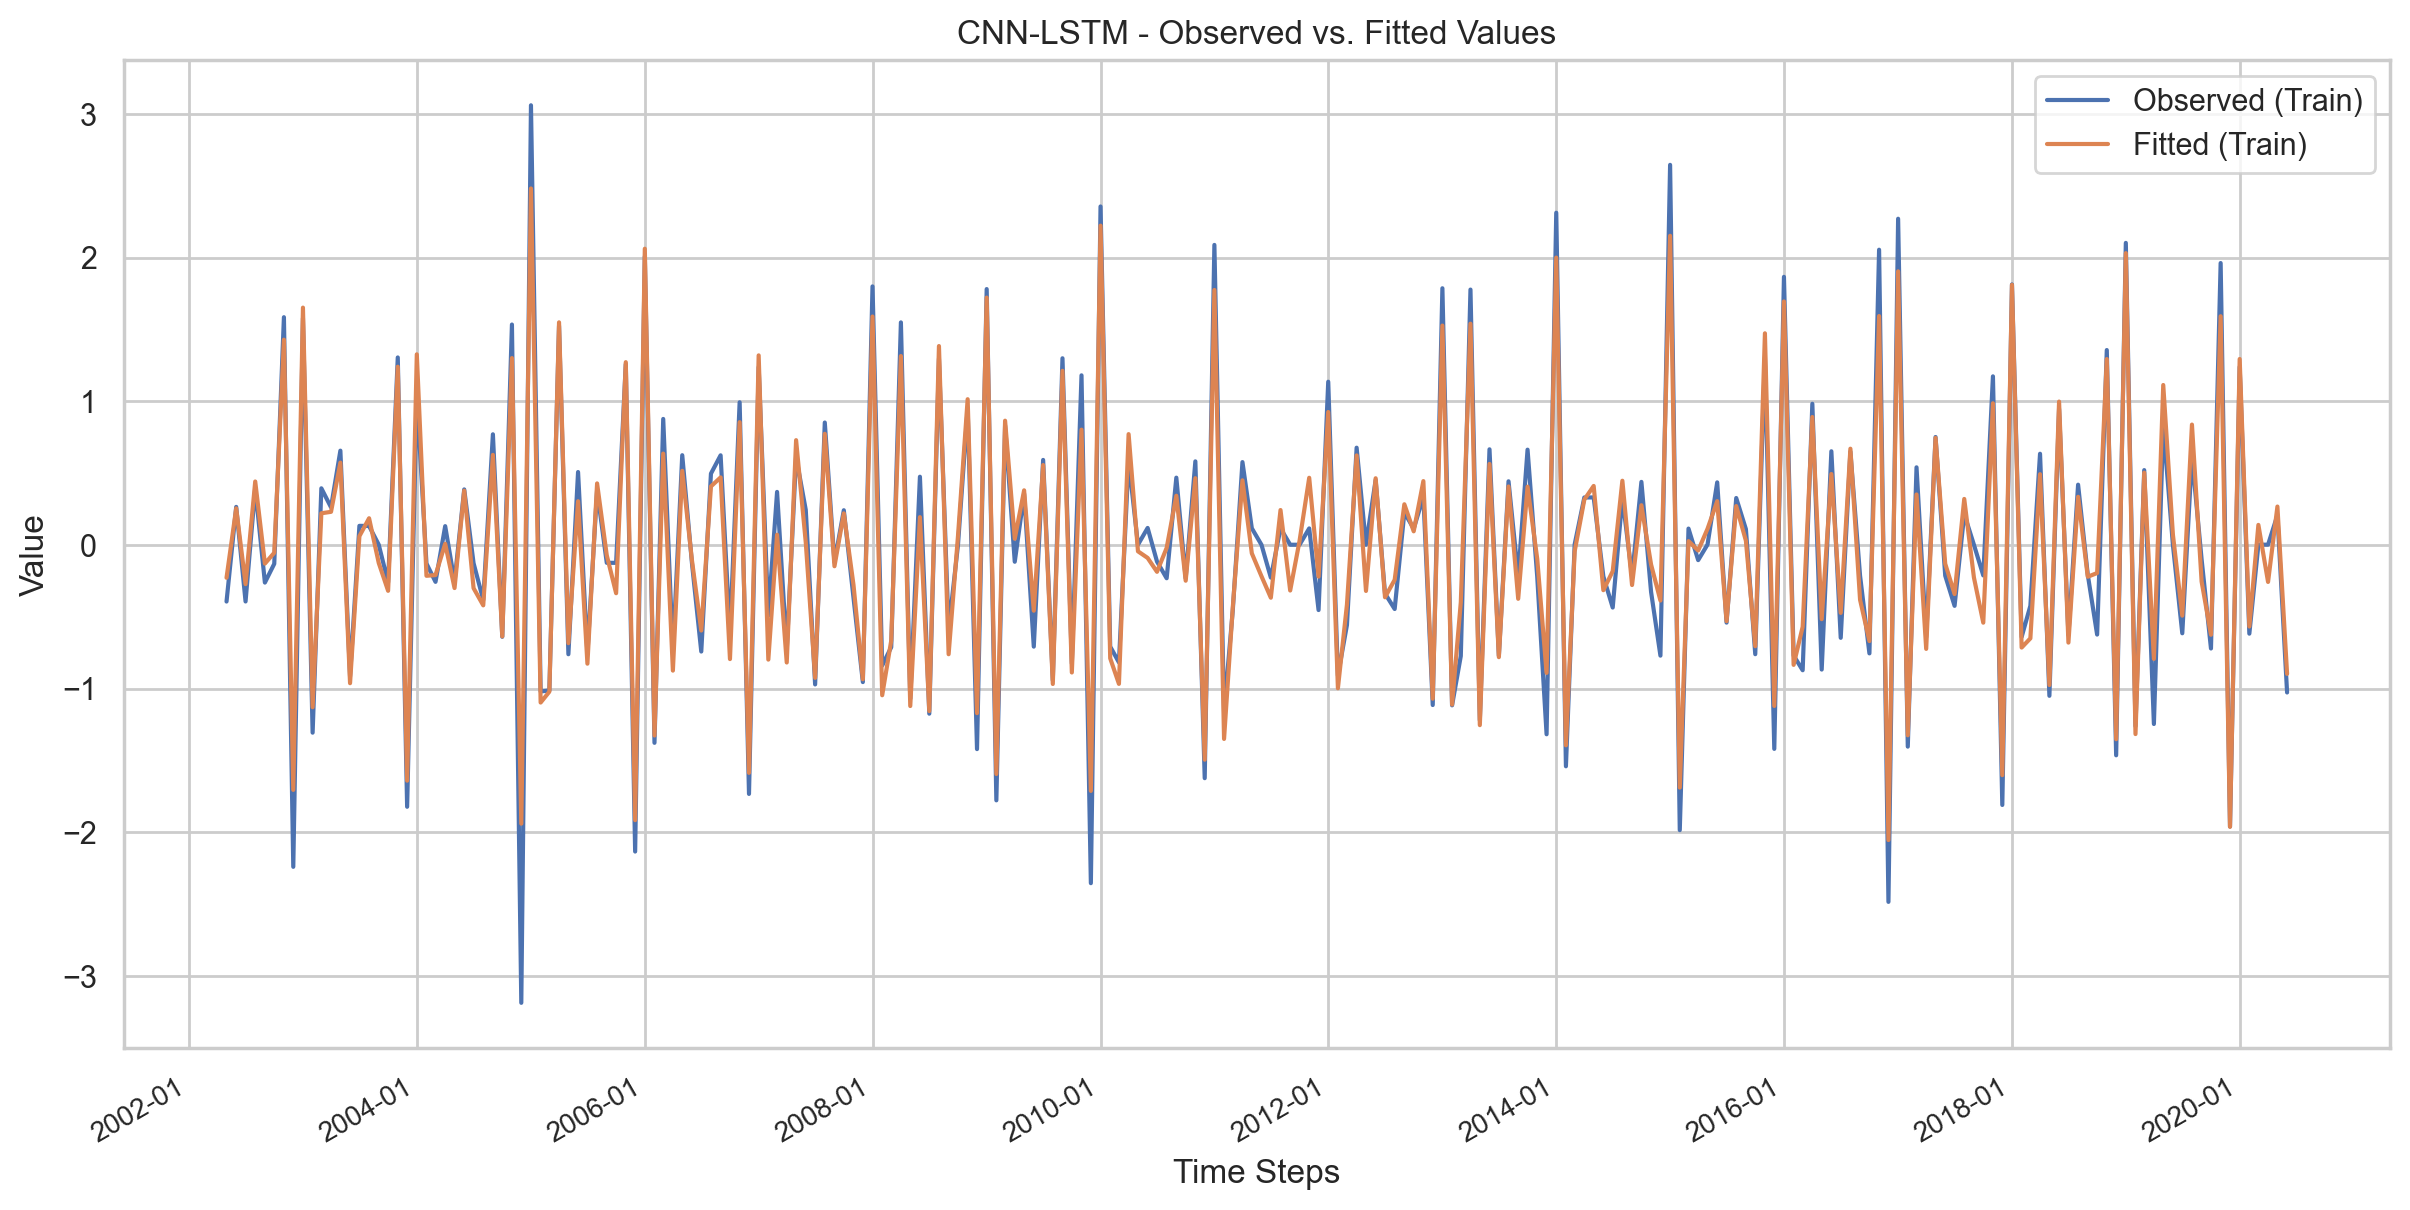

Mean Absolute Error (MAE): 0.60226492
Root Mean Squared Error (RMSE): 0.75661316


In [20]:
df_hicp_3lags = df_hicp_target[feature_3_lags_cols]
model_C1D_3l, X_train_C1D_3l, X_test_C1D_3l, mae_C1D_3l, rmse_C1D_3l, fnames_C1D_3l = conv1D(df_hicp_3lags, target, test_size)


CNN-LSTM 1D (CL1D) No Feature engineering

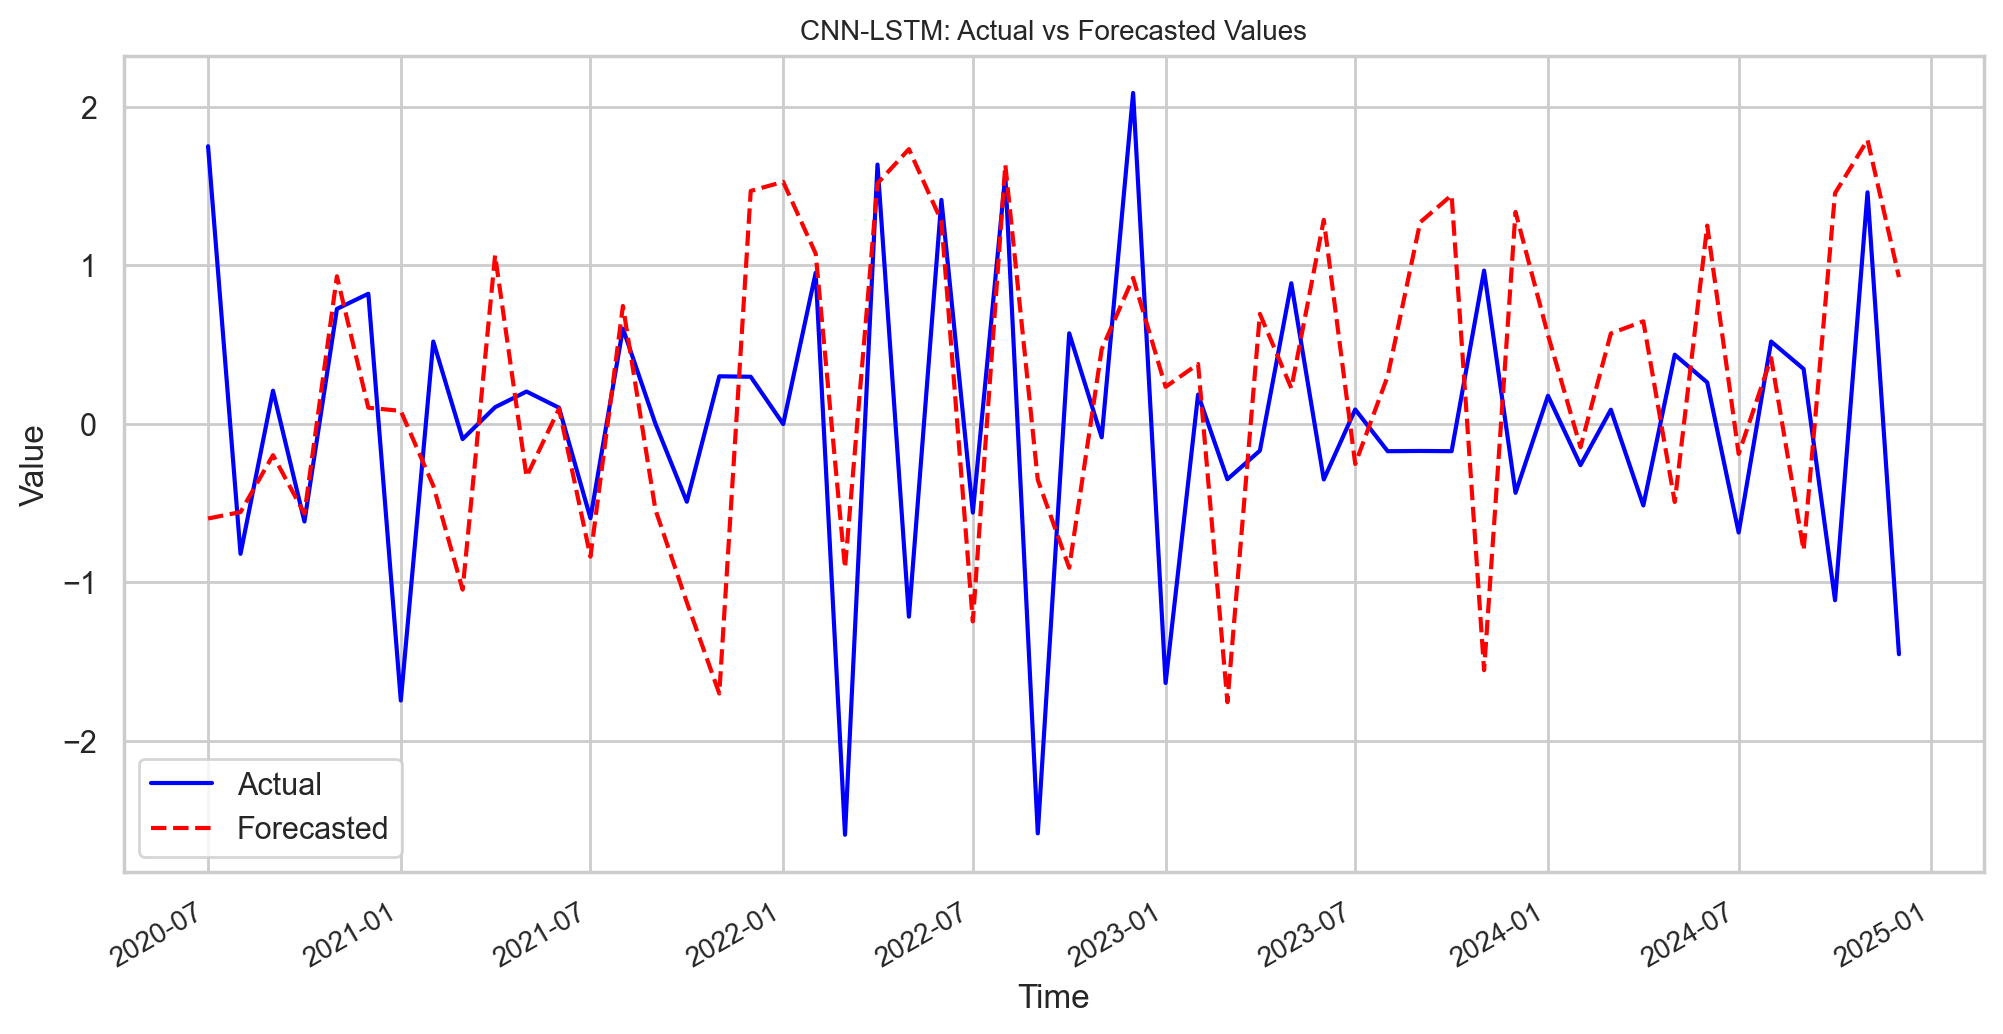

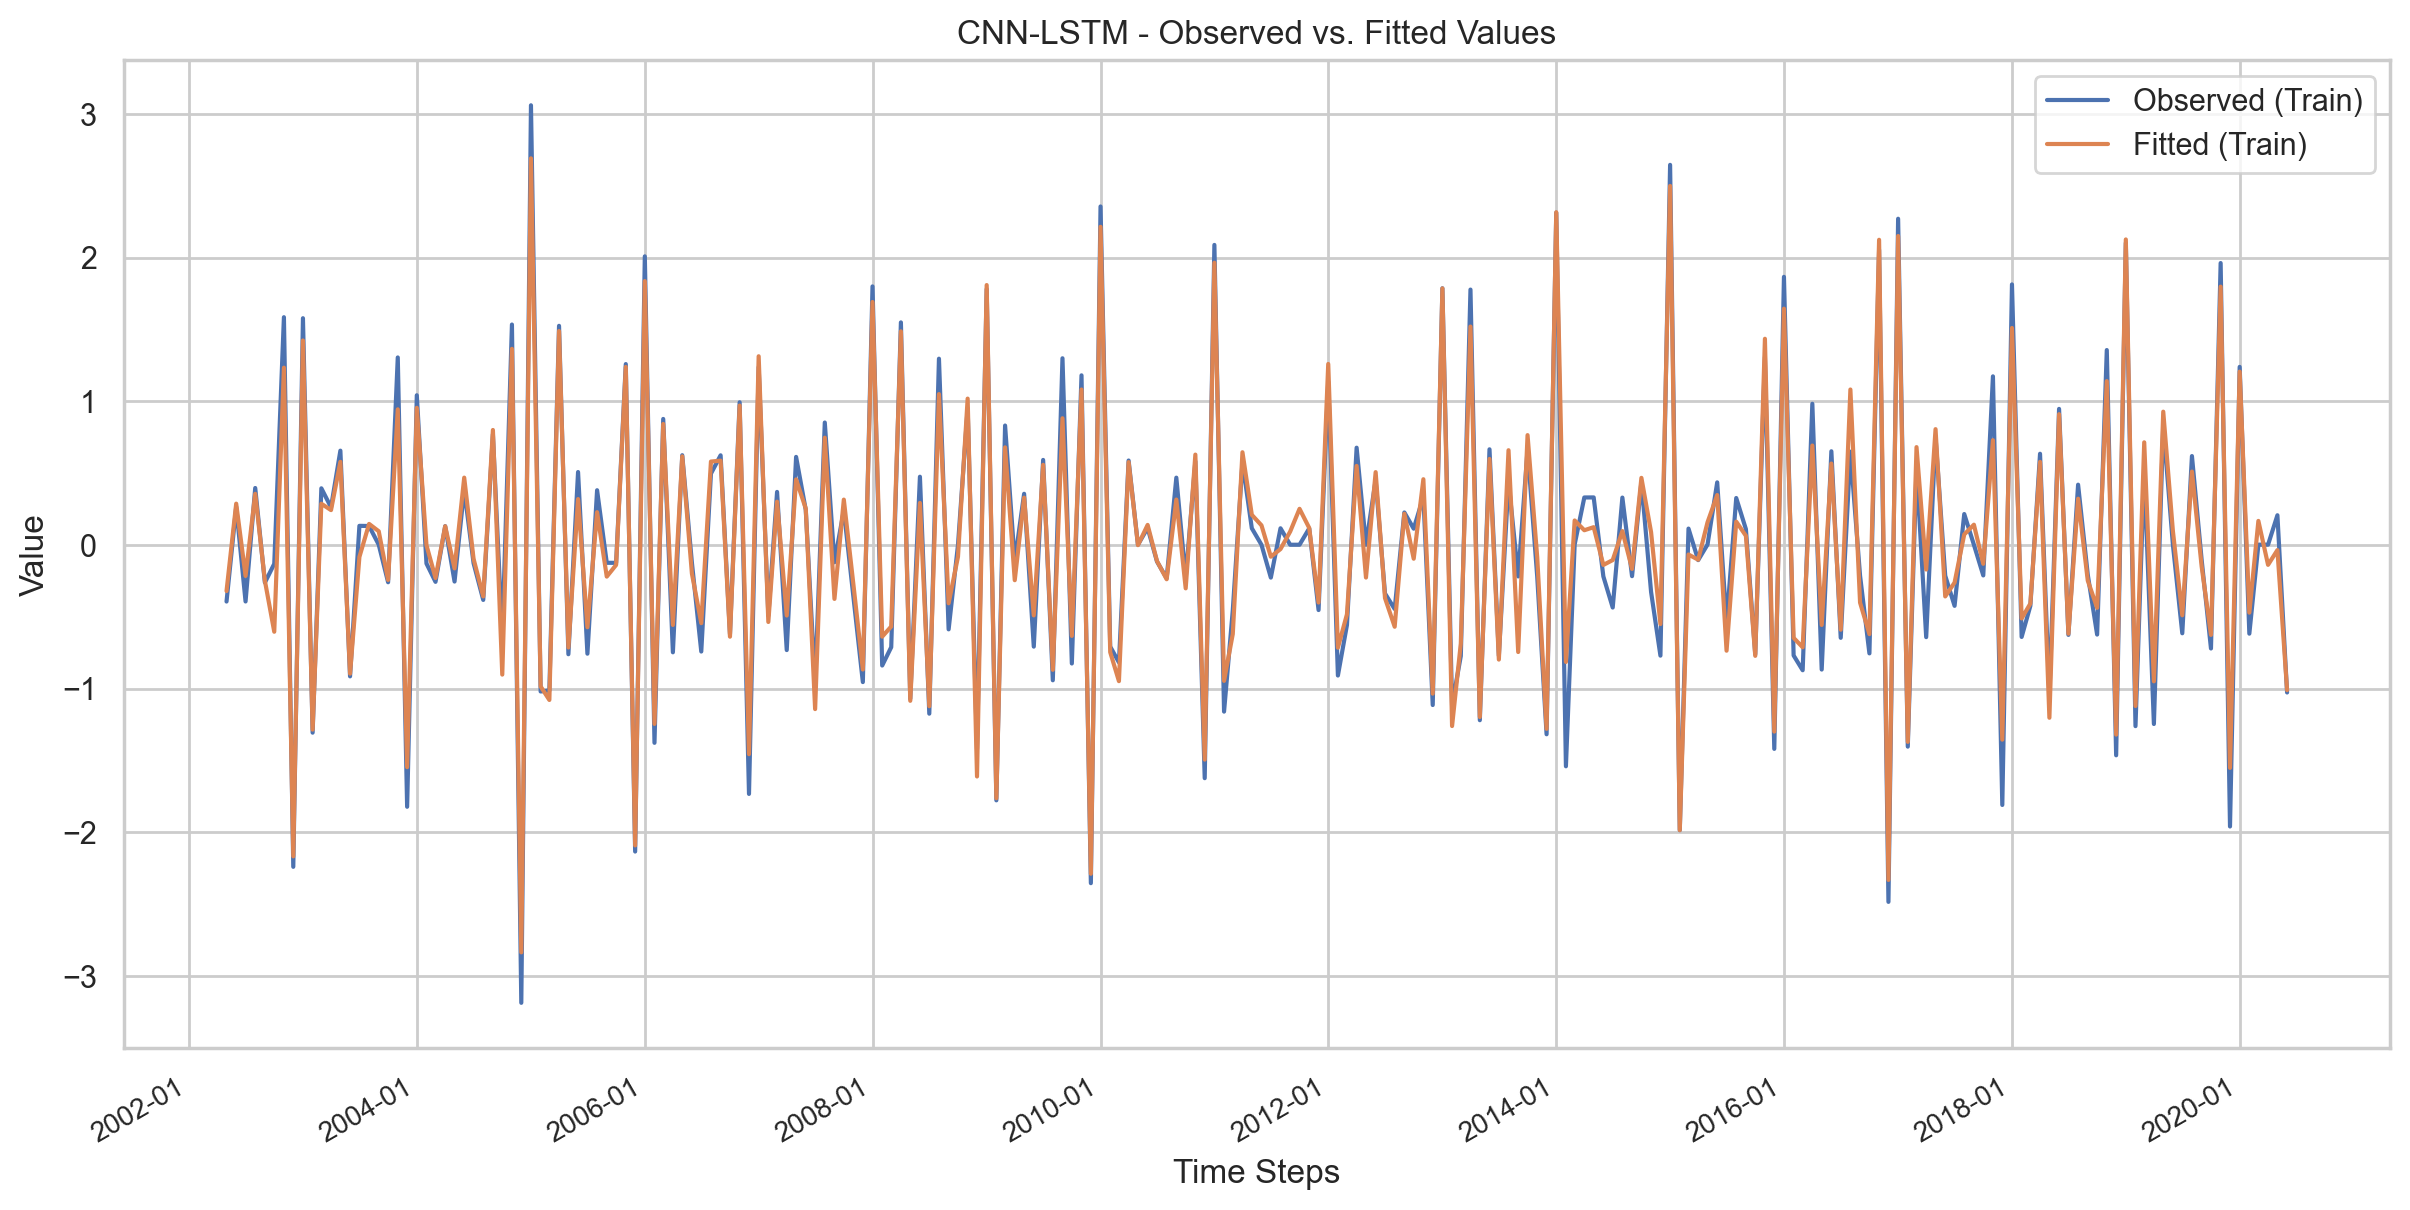

Mean Absolute Error (MAE): 0.97273170
Root Mean Squared Error (RMSE): 1.24286077


In [21]:
model_CL1D_nfe, X_train_CL1D_nfe, X_test_CL1D_nfe, mae_CL1D_nfe, rmse_CL1D_nfe, fnames_CL1D_nfe = convlstm1D(df, test_size)

CNN 1D ACF/PACF Target + Feature Engineered

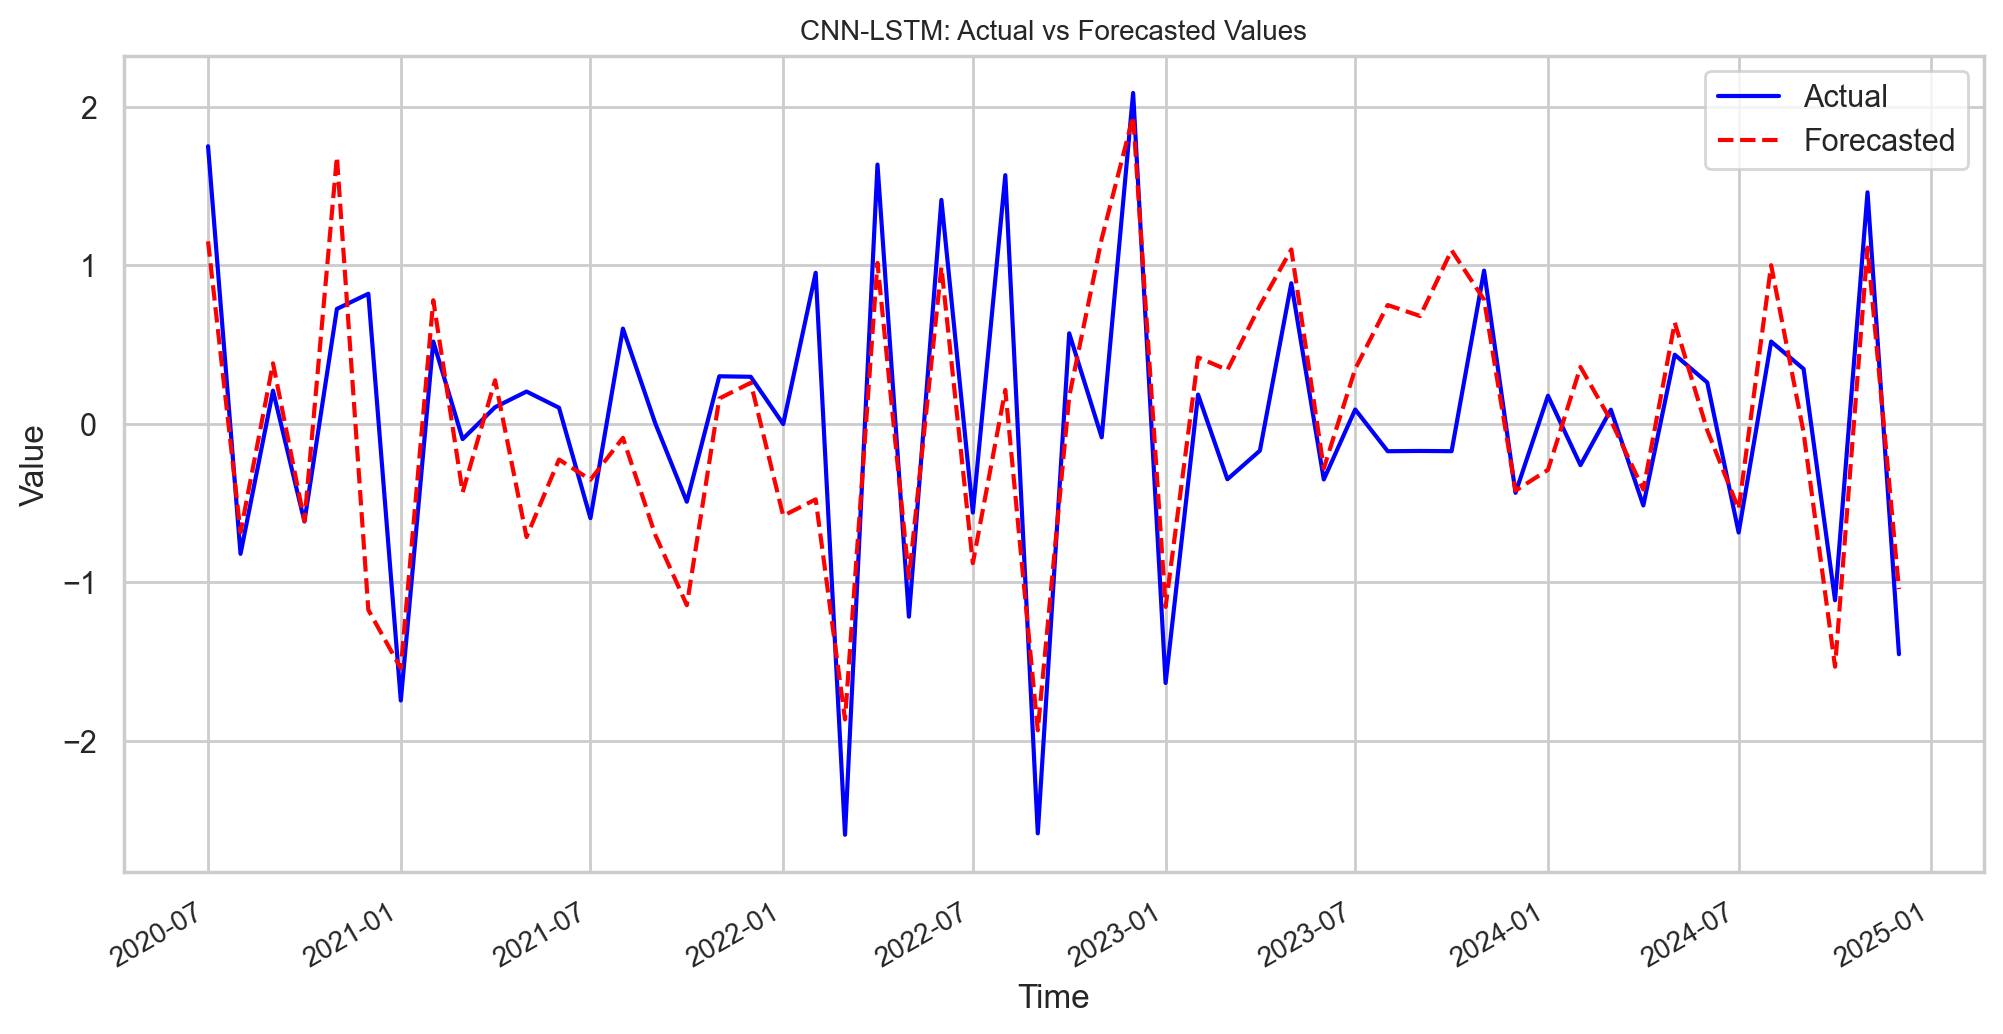

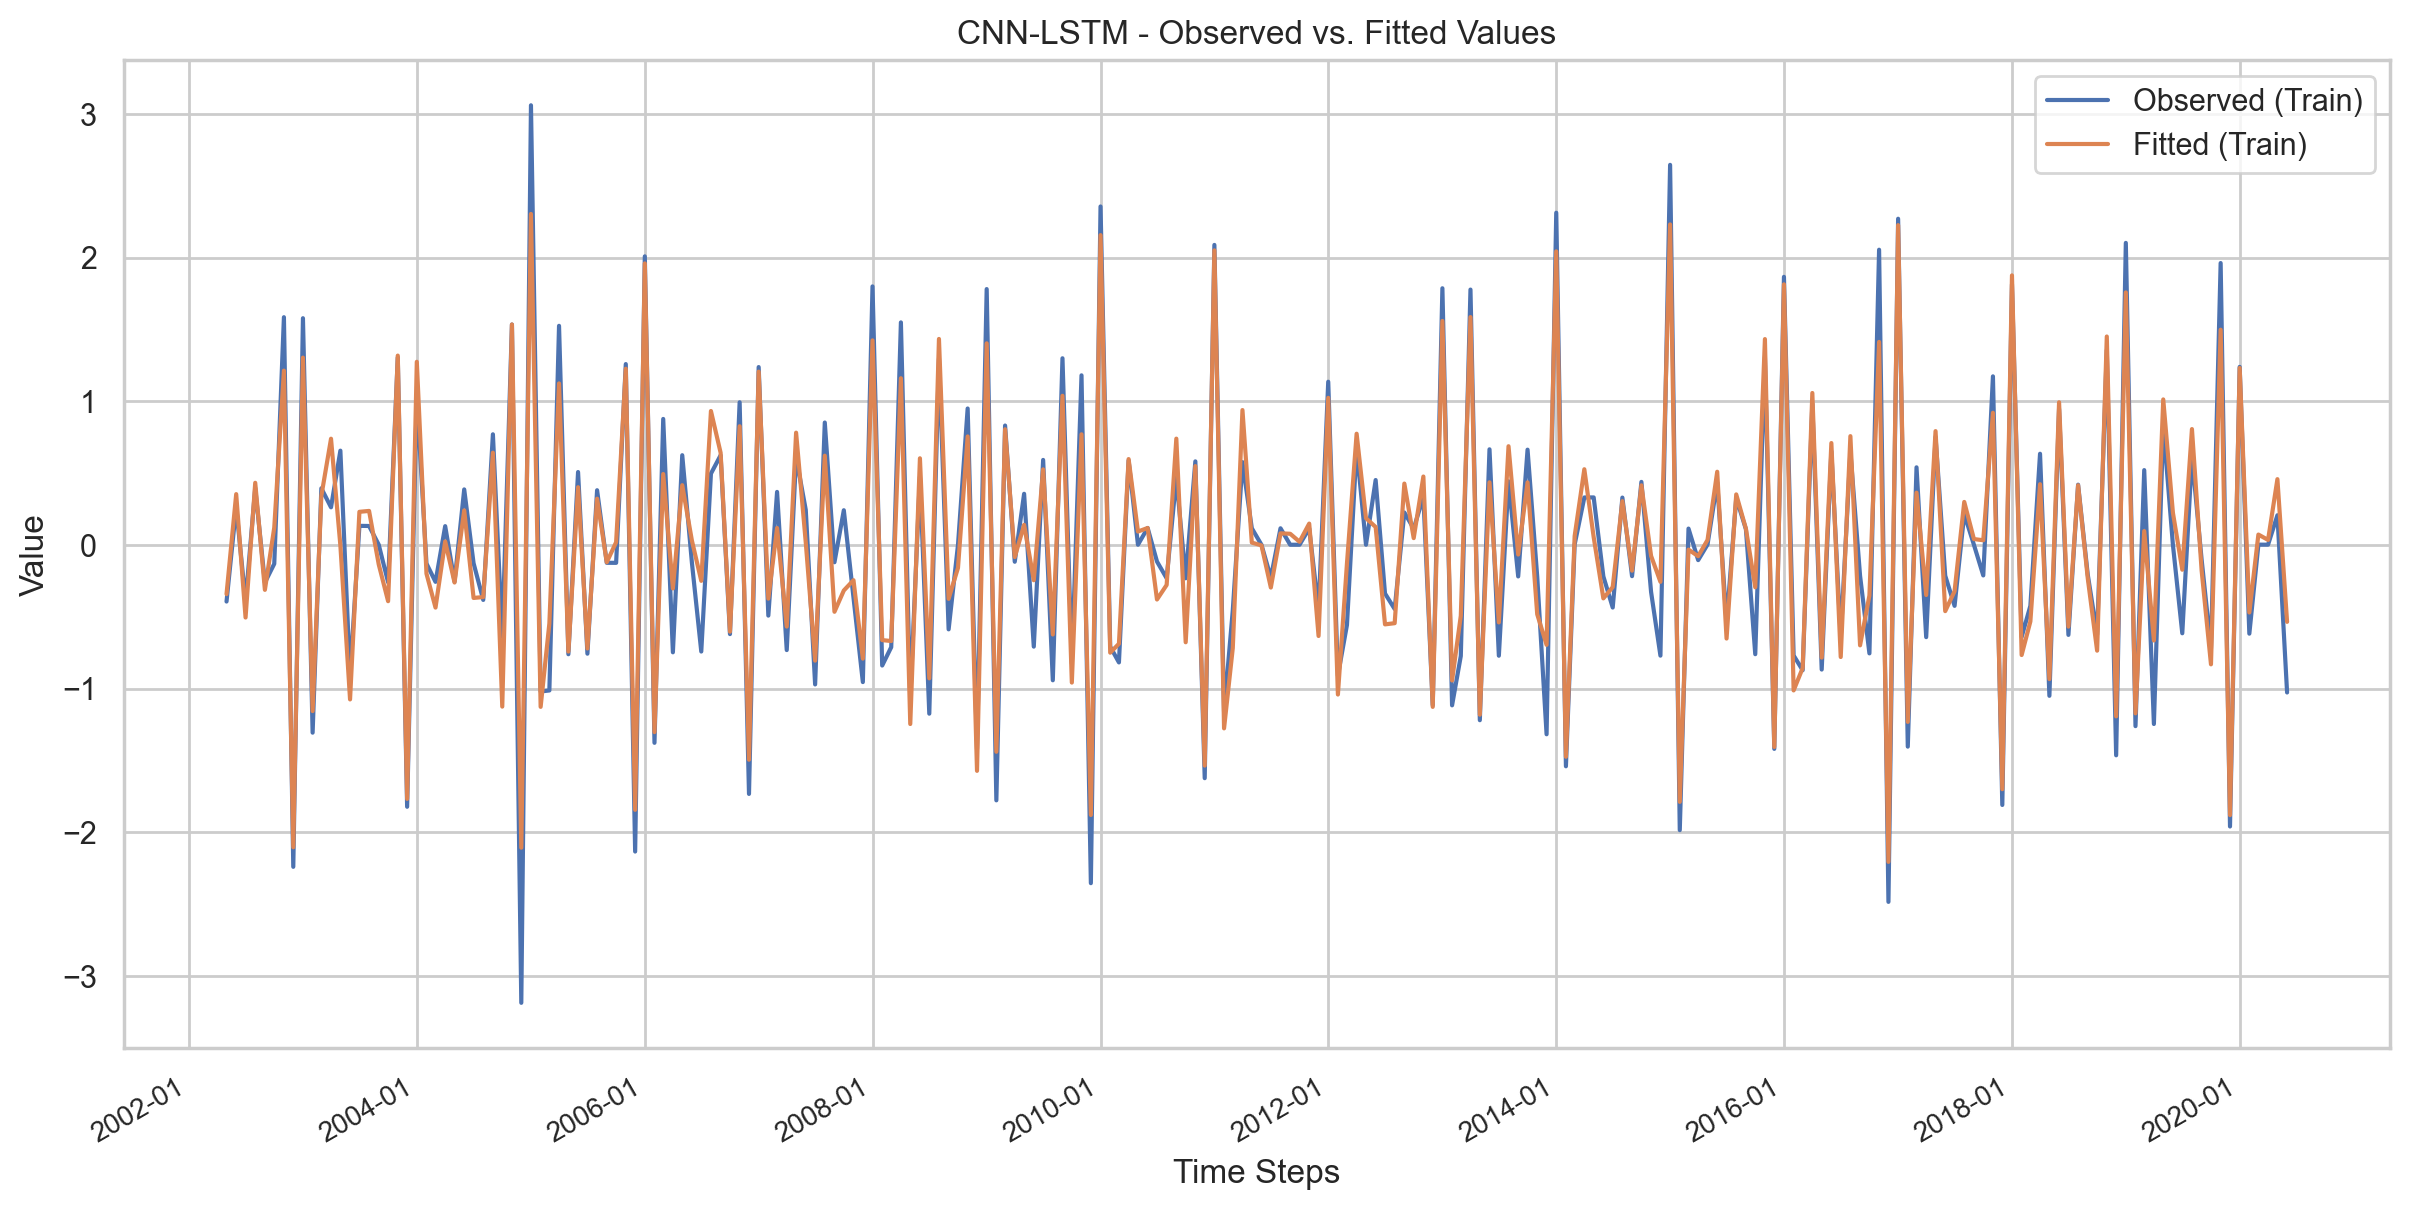

Mean Absolute Error (MAE): 0.49563228
Root Mean Squared Error (RMSE): 0.64109853


In [22]:
df_hicp_acf = df_hicp_target[main_vars_cols + hicp_acf_pacf_lag_cols]
model_C1D_acf, X_train_C1D_acf, X_test_C1D_acf, mae_C1D_acf, rmse_C1D_acf, fnames_C1D_acf = conv1D(df_hicp_acf, target, test_size)

CNN-LSTM 1D ACF/PACF Target + Feature Engineered

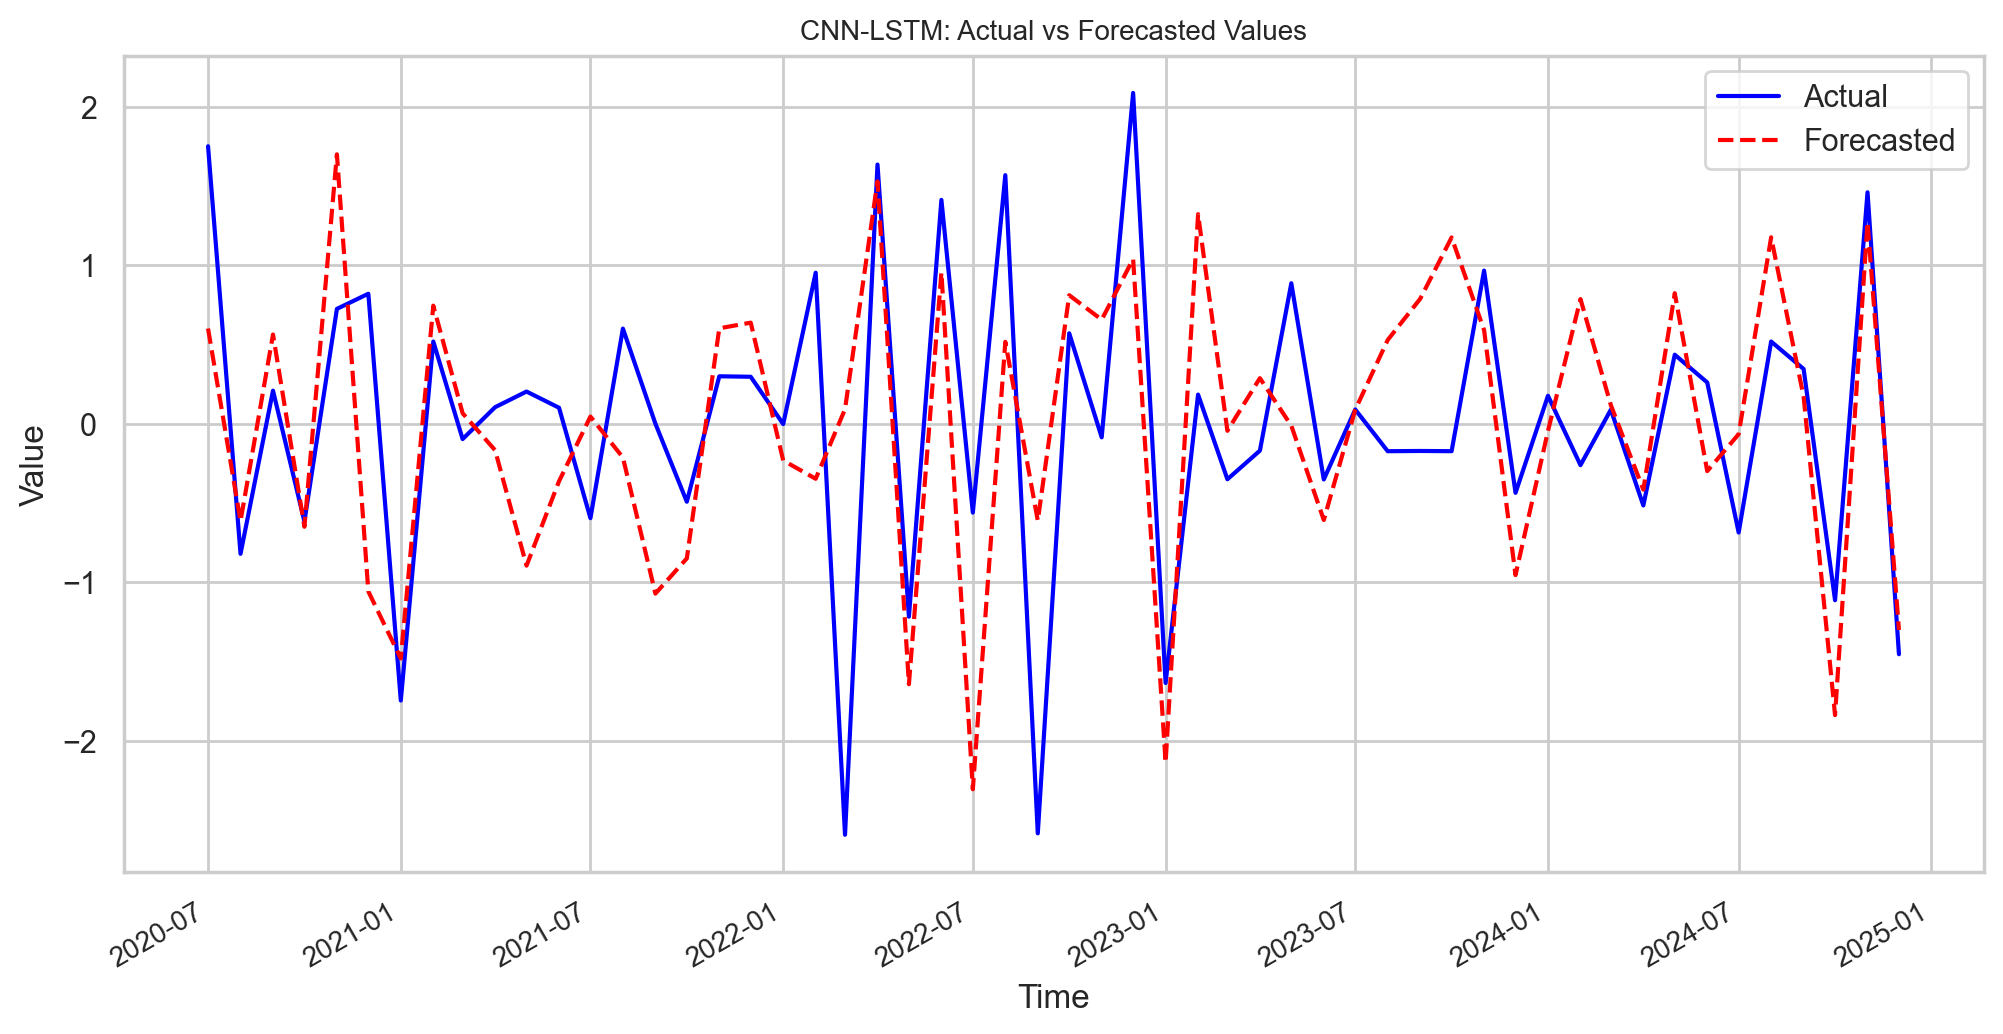

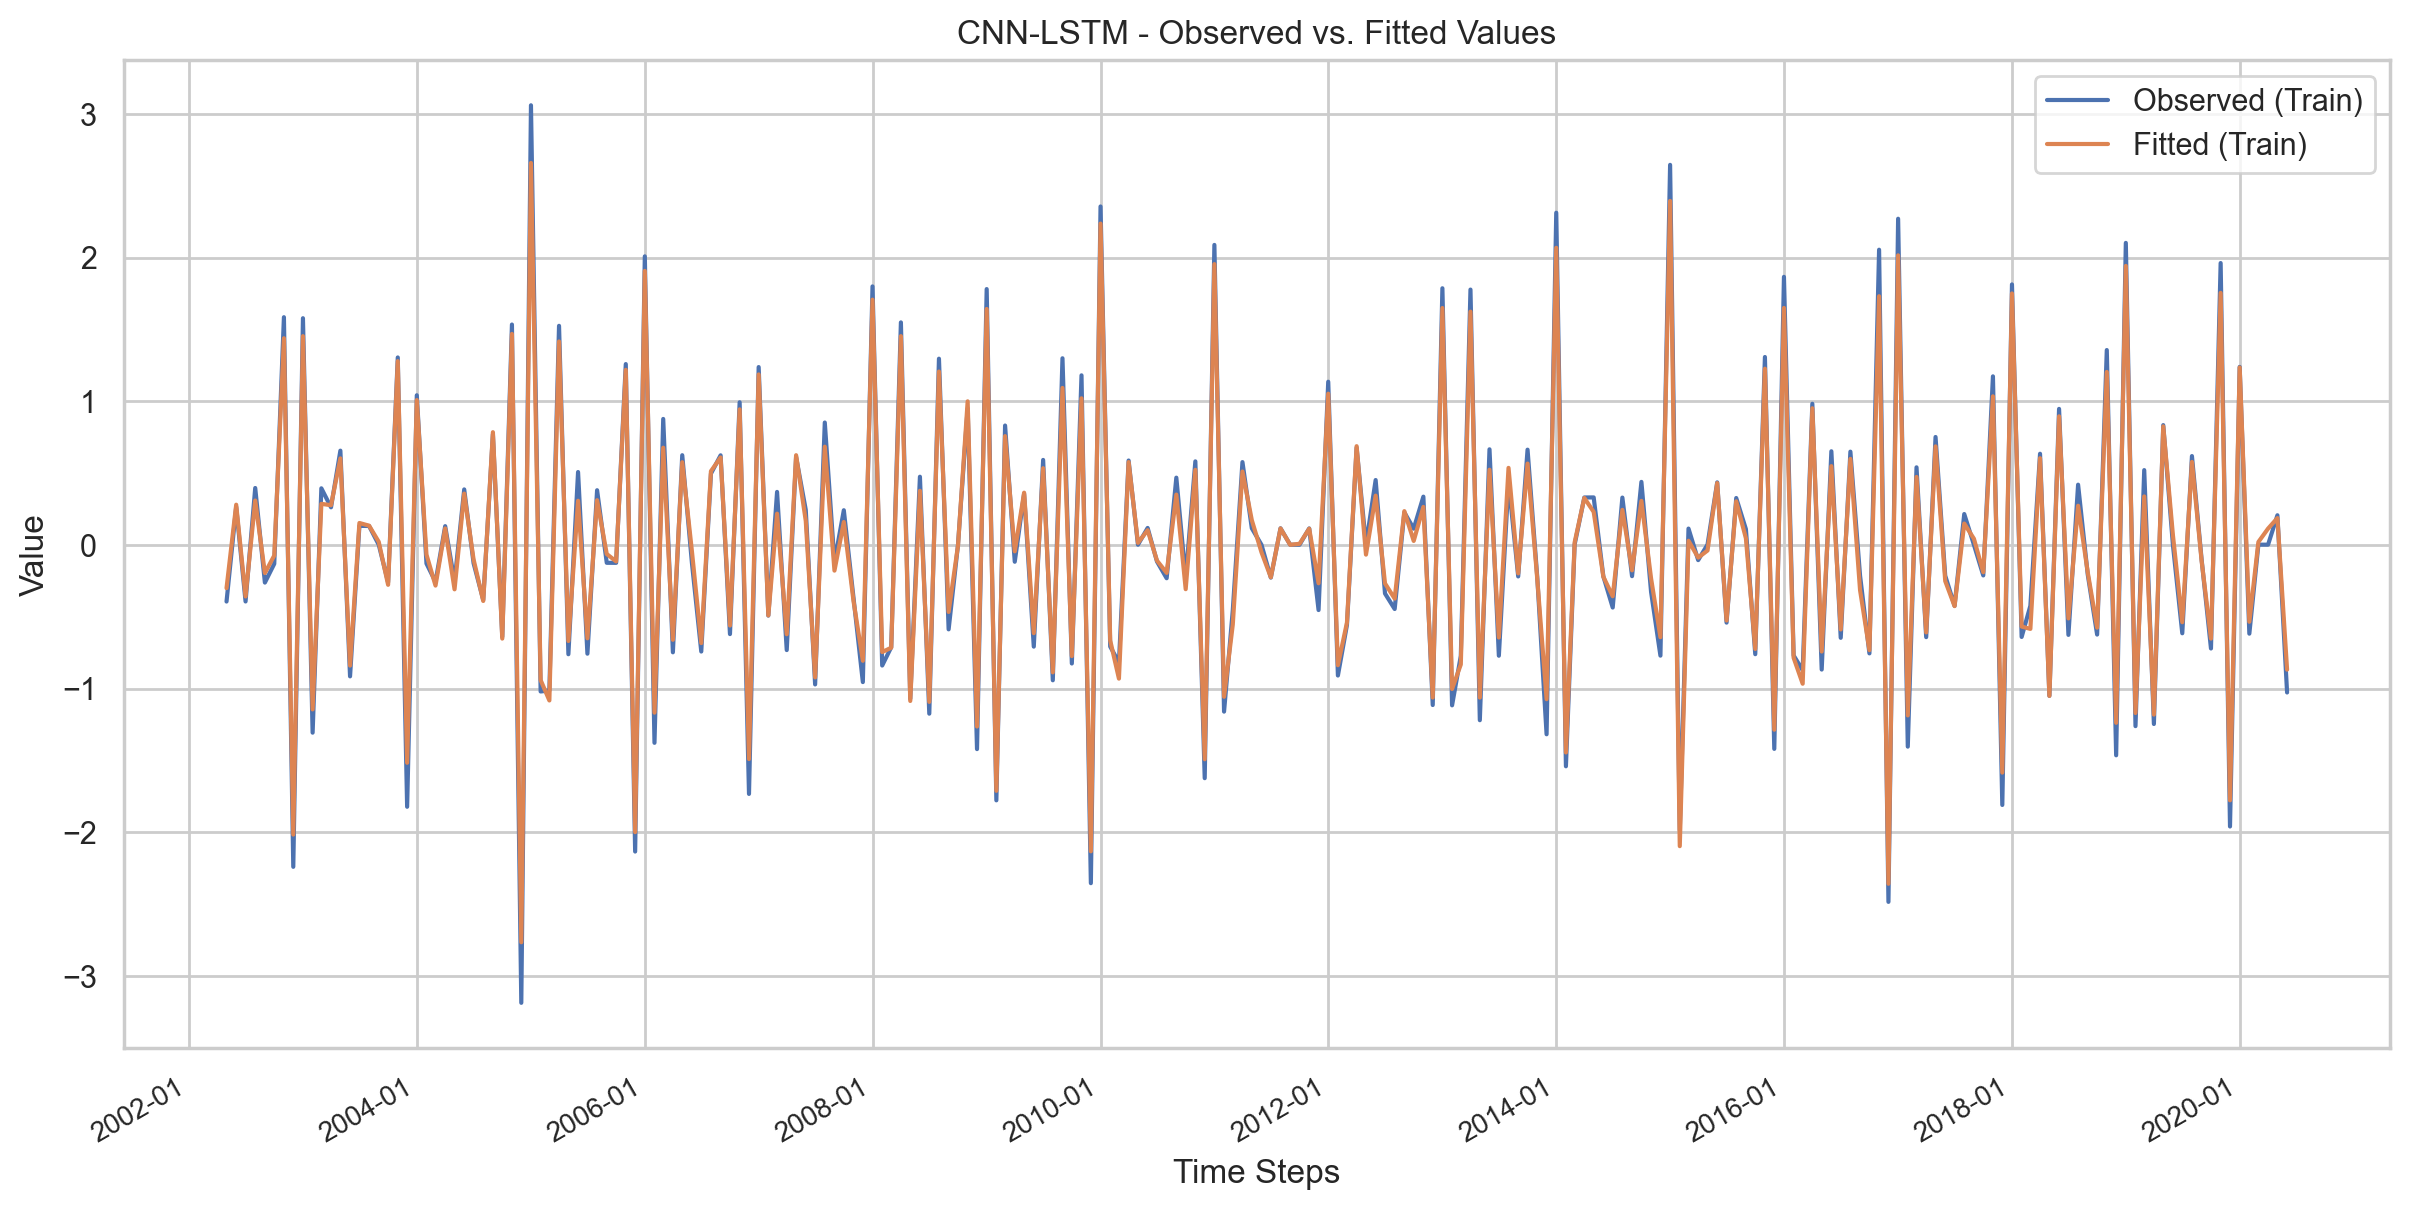

Mean Absolute Error (MAE): 0.64732236
Root Mean Squared Error (RMSE): 0.84667519


In [23]:
model_CL1D_acf, X_train_CL1D_acf, X_test_CL1D_acf, mae_CL1D_acf, rmse_CL1D_acf, fnames_CL1D_acf = convlstm1D(df_hicp_acf, test_size)

CNN-LSTM 1D Target + Feature Engineered 3 lags

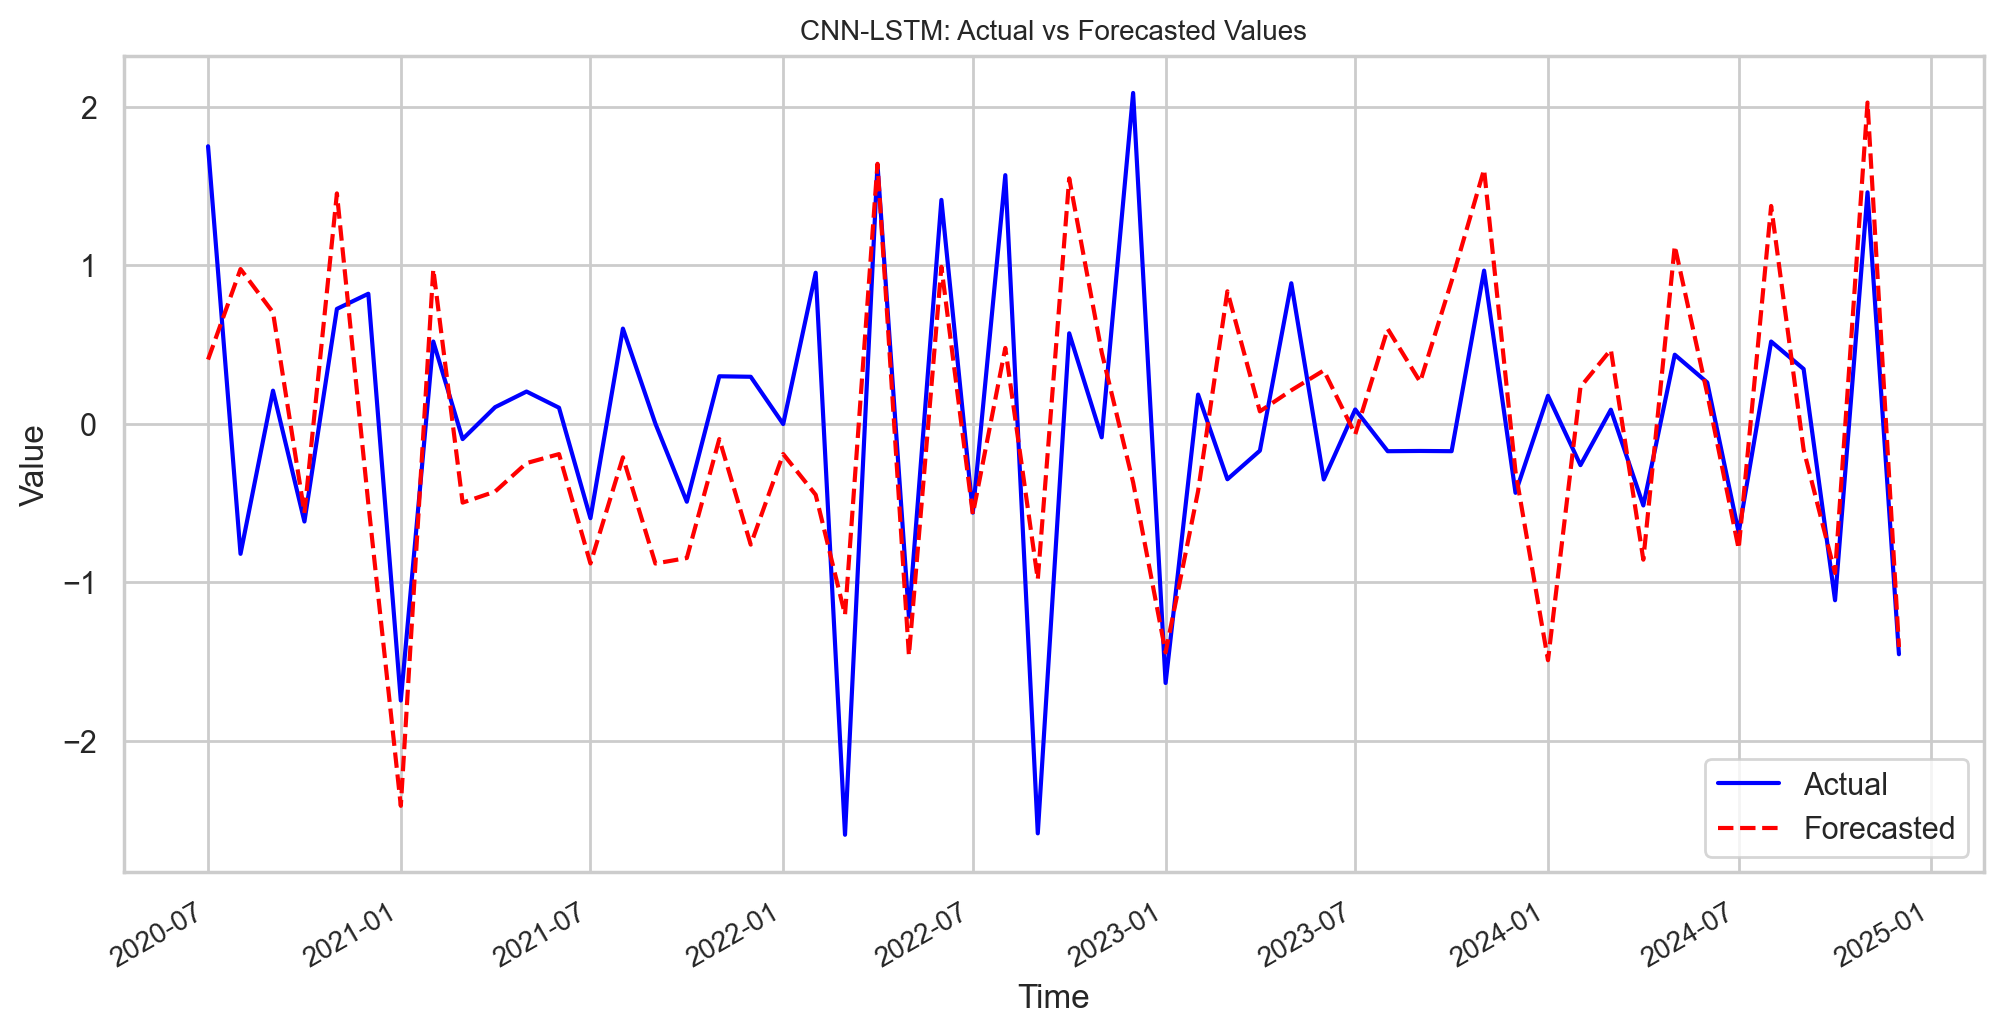

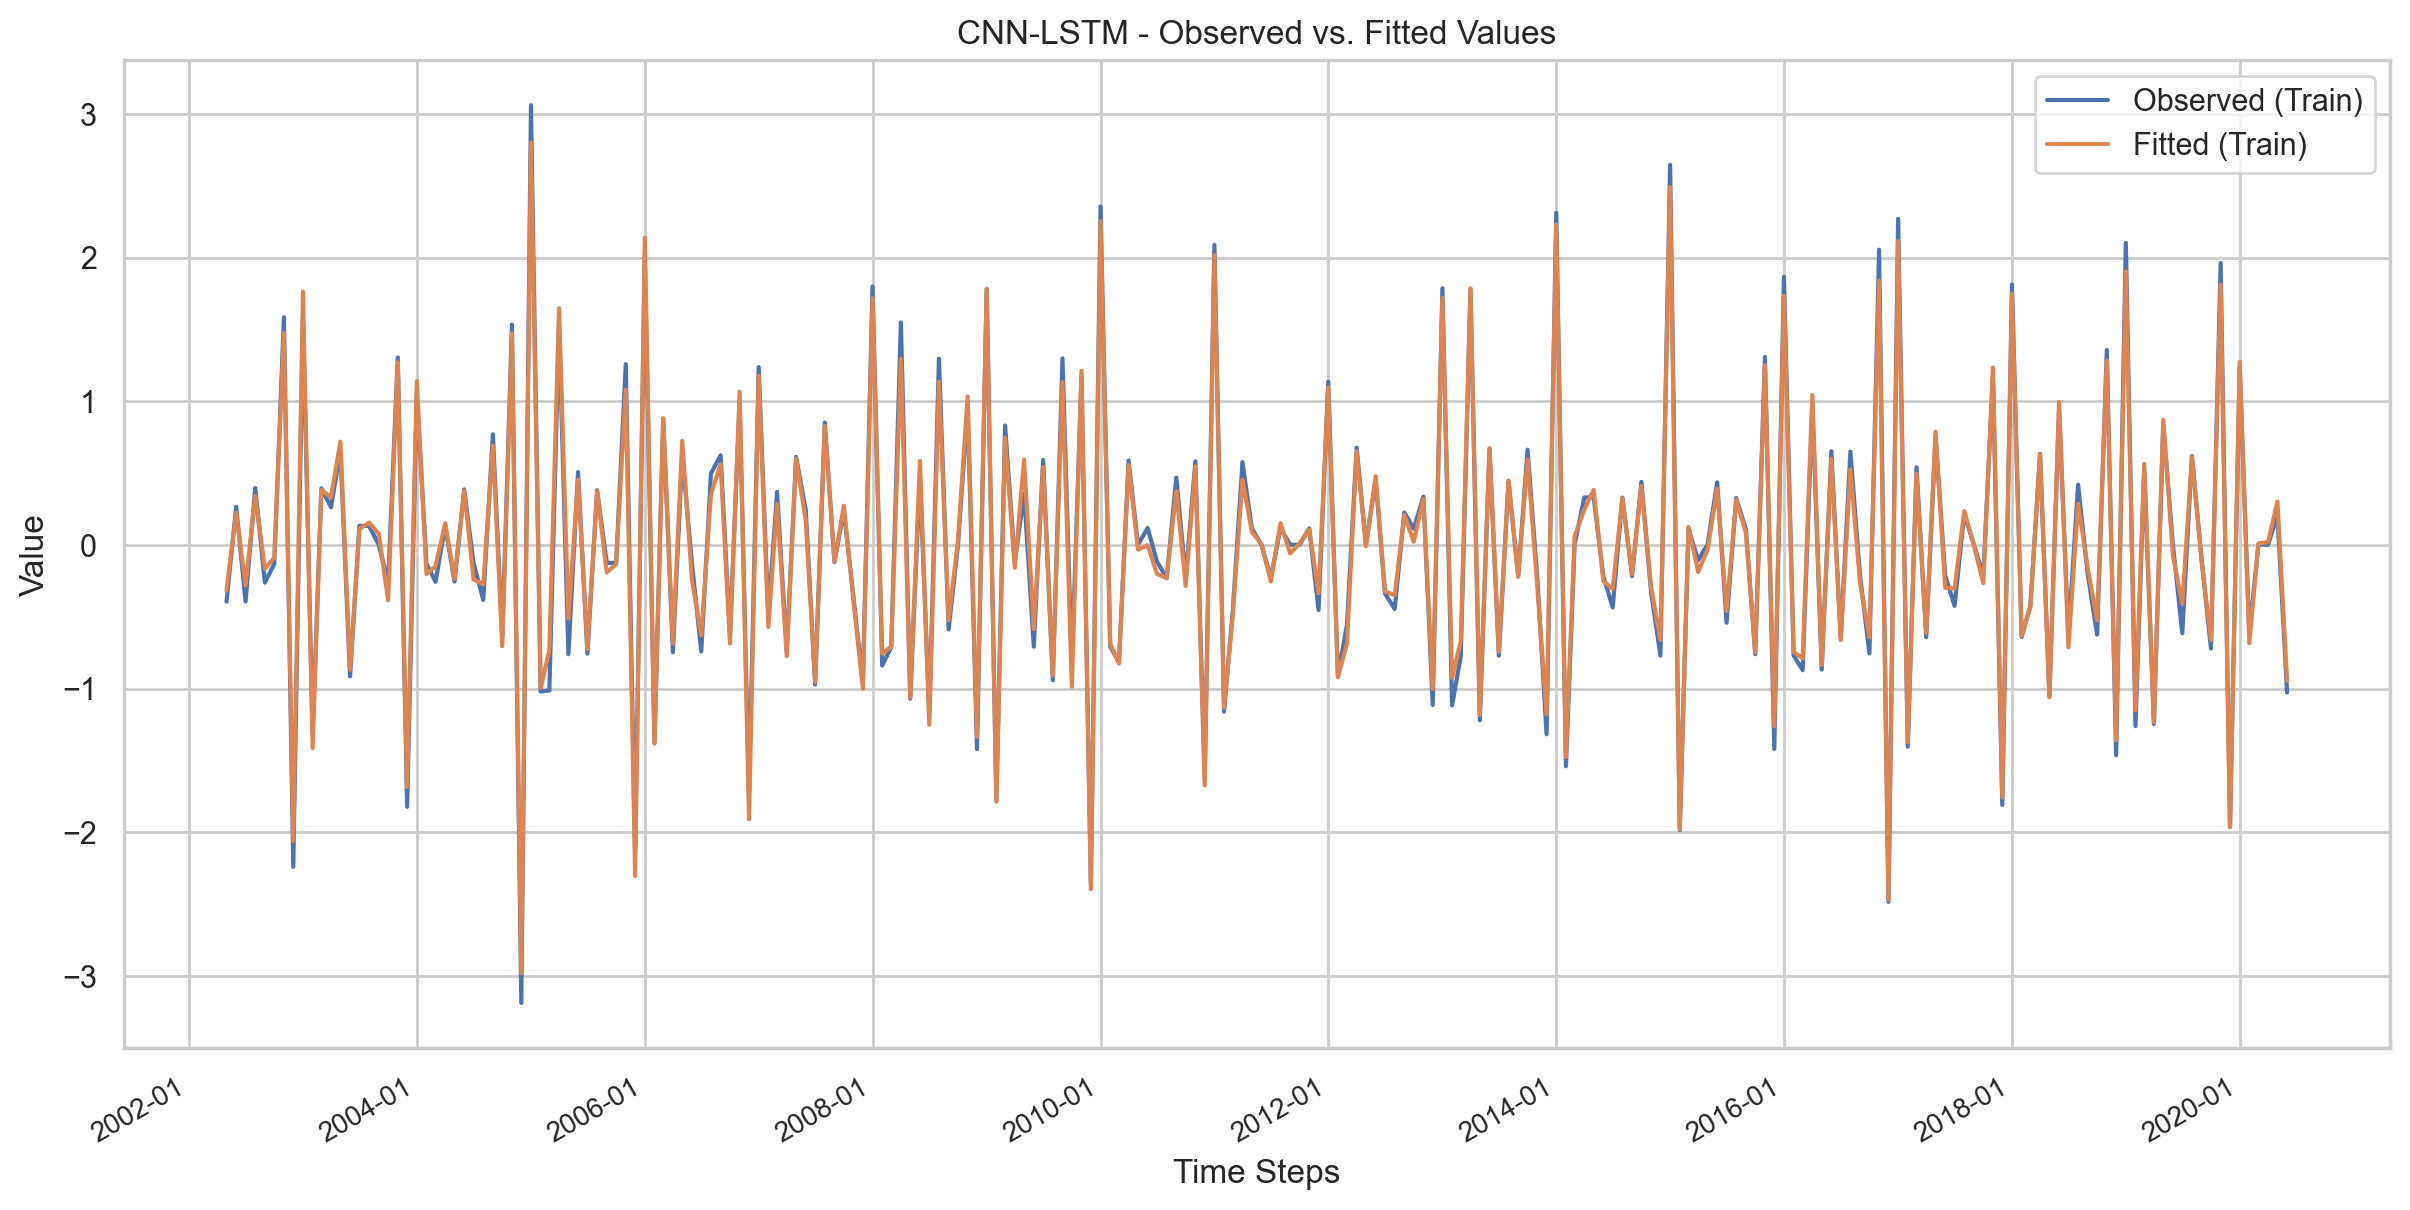

Mean Absolute Error (MAE): 0.65480858
Root Mean Squared Error (RMSE): 0.83220788


In [24]:
model_CL1D_3l, X_train_CL1D_3l, X_test_CL1D_3l, mae_CL1D_3l, rmse_CL1D_3l, fnames_CL1D_3l = convlstm1D(df_hicp_3lags, test_size)

CNN-LSTM 2D (CL2D) No feature engineering

In [25]:
model_CL2D_nfe, X_train_CL2D_nfe, X_test_CL2D_nfe, mae_CL2D_nfe, rmse_CL2D_nfe, fnames_CL2D_vae = convlstm2D(df, targetCpi, test_size)

KeyboardInterrupt: 

CNN-LSTM 2D + VAE

Predictions shape: (54, 1)


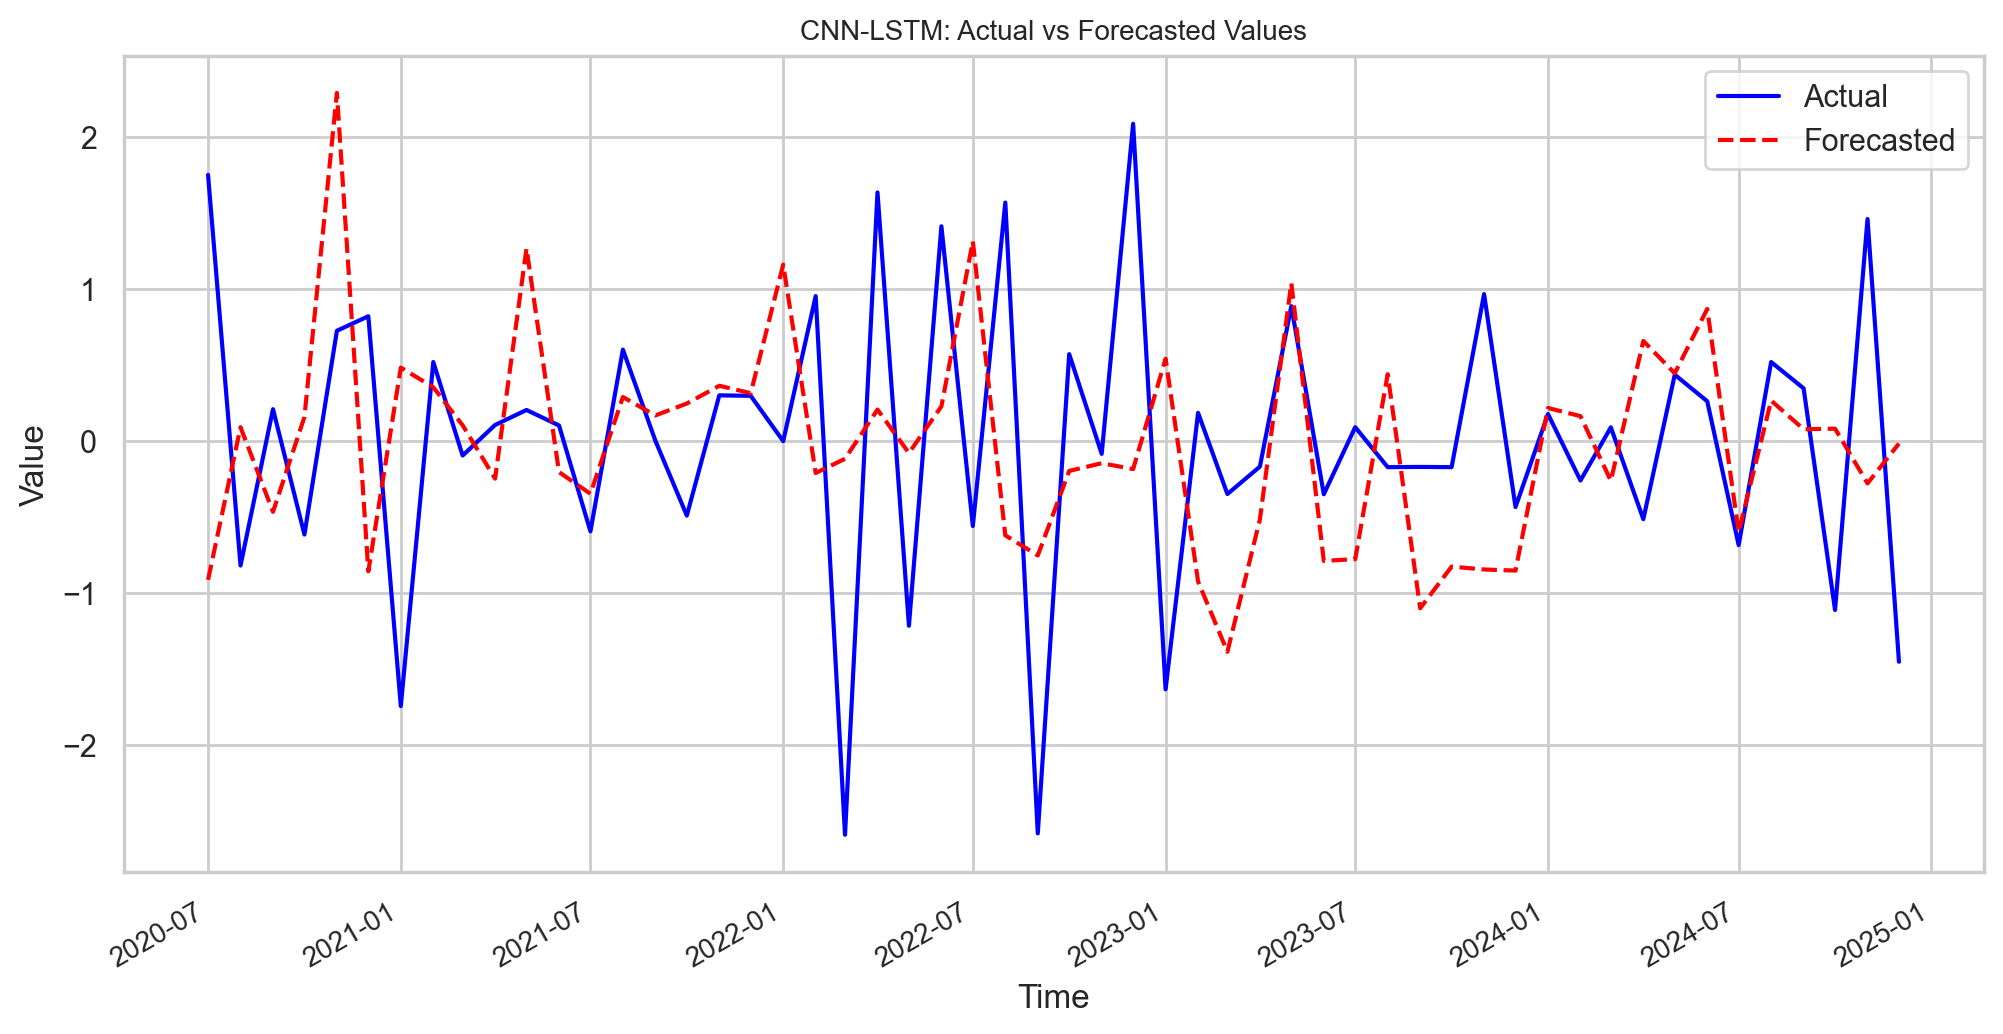

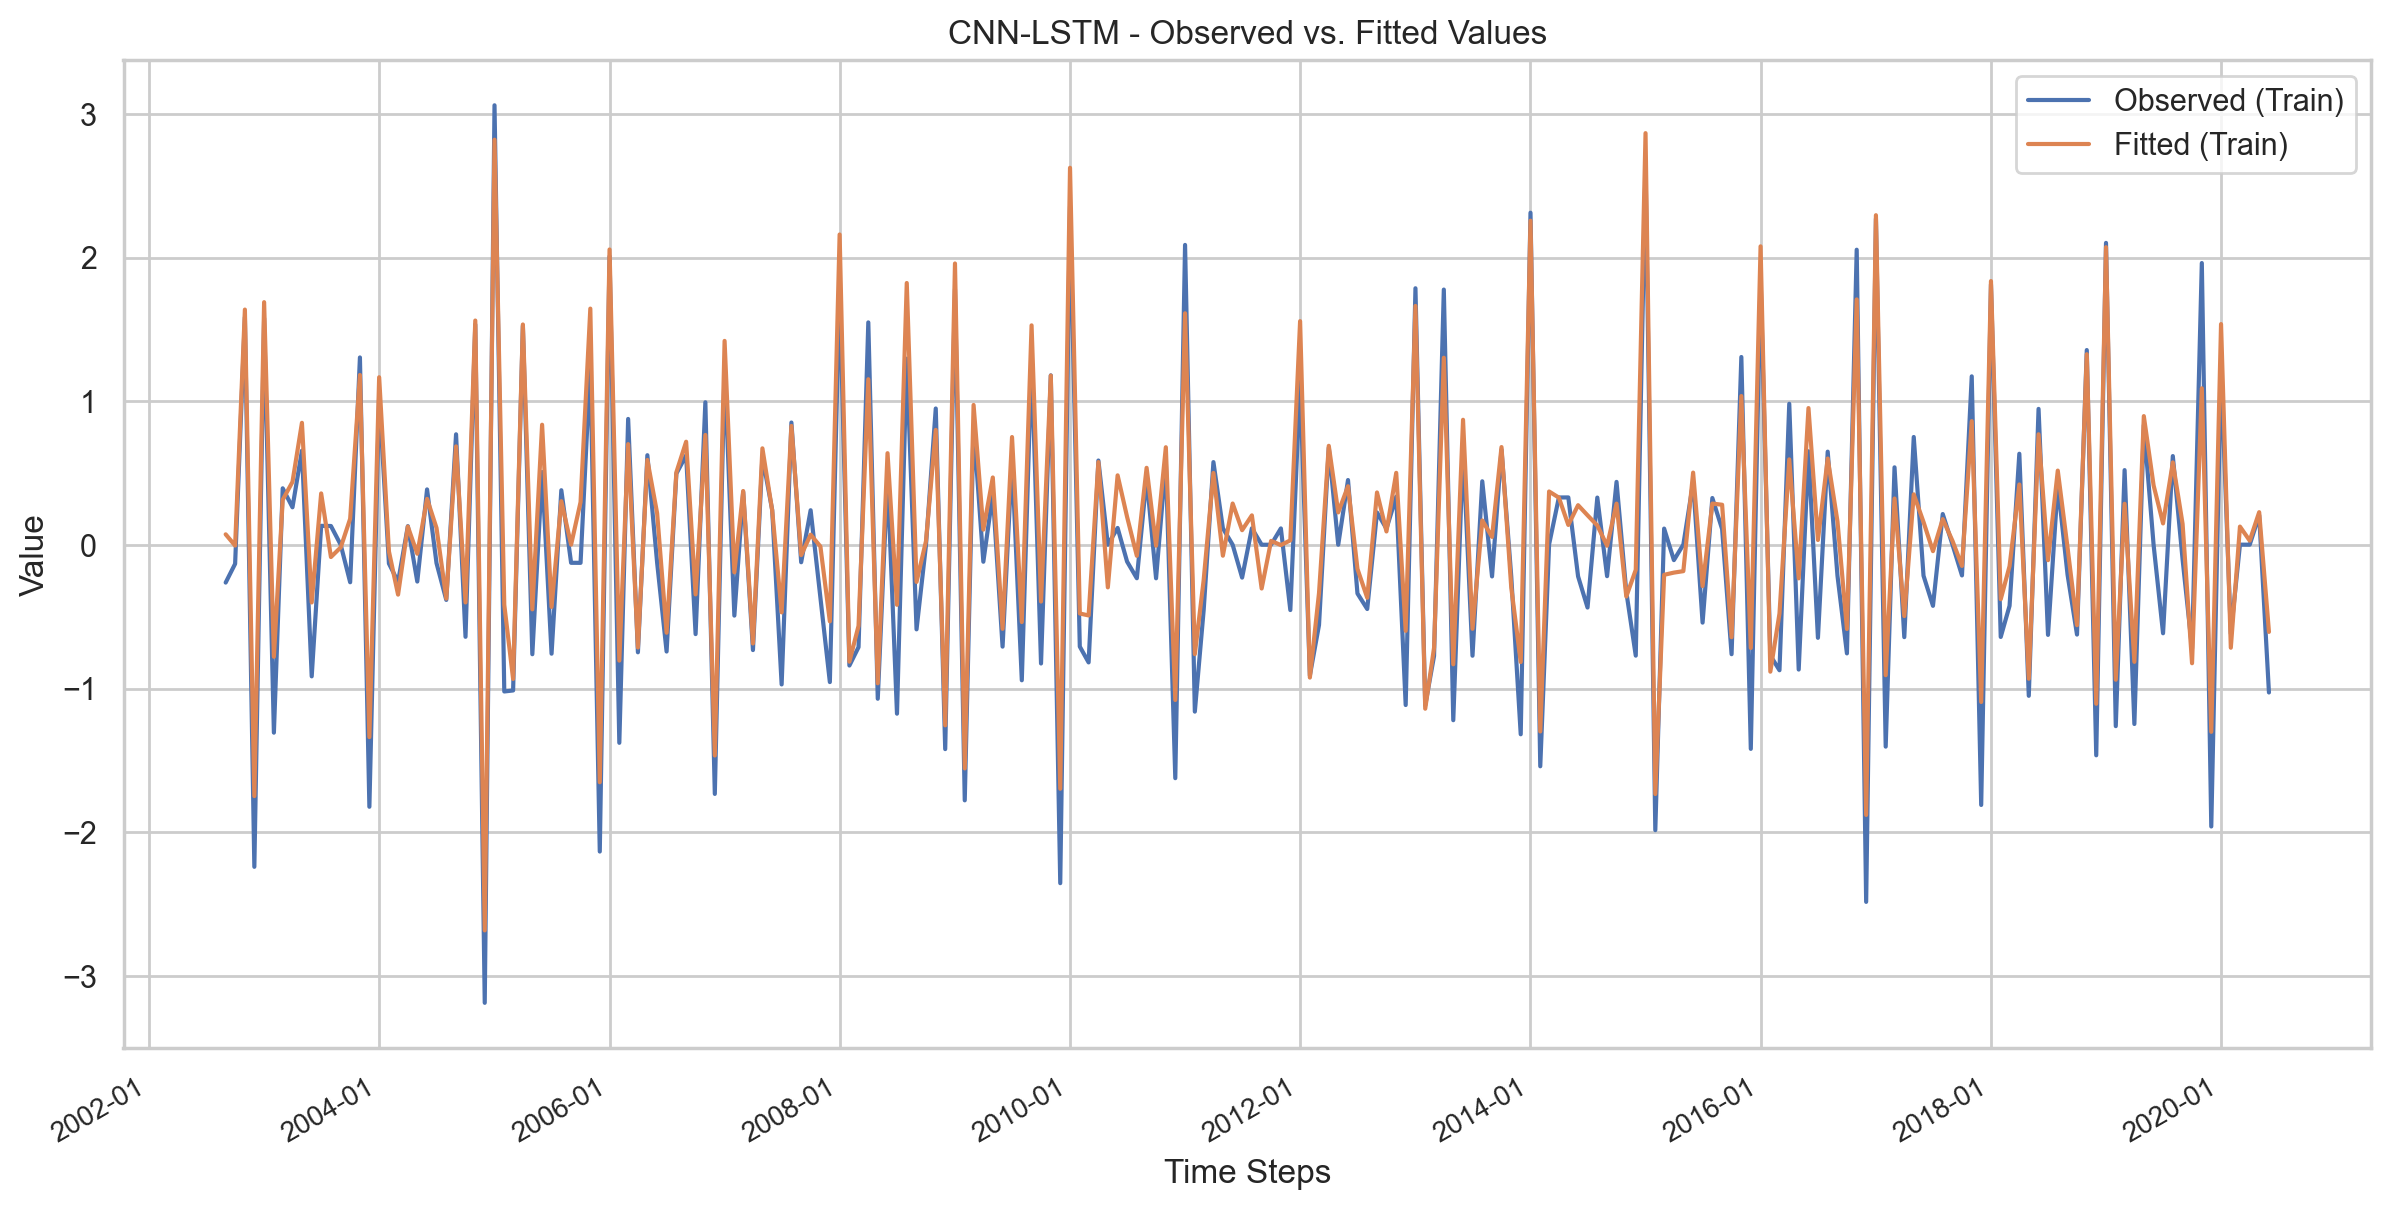

Mean Absolute Error (MAE): 0.92286664
Root Mean Squared Error (RMSE): 1.17361439


In [292]:
df_hicp_vae = df_hicp_target[vae_hicp_cols]
model_CL2D_vae, X_train_CL2D_vae, X_test_CL2D_vae, mae_CL2D_vae, rmse_CL2D_vae, fnames_CL2D_vae = convlstm2D(df, targetCpi, test_size)

In [287]:
print(f'CONV 1D NFE (MAE): {mae_C1D_nfe}')
print(f'CONVLSTM 2D NFE (MAE): {mae_CL2D_nfe}')
print(f'CONVLSTM 1D + NFE (MAE): {mae_CL1D_nfe}')

print(f'CONV 1D + ACF/PACF (MAE): {mae_C1D_acf}')
print(f'CONVLSTM 1D + ACF/PACF (MAE): {mae_CL1D_acf}')

print(f'CONV1D + 3 LAGS (MAE): {mae_C1D_3l}')
print(f'CONVLSTM 1D + 3 LAGS (MAE): {mae_CL1D_3l}')

# print(f'CONVLSTM 1D + VAE (MAE): {mae_CL1D_vae}')
print(f'CONVLSTM 2D + VAE (MAE): {mae_CL2D_vae}')

print(f'VAR (MAE): {var_mae}')
print(f'VAR (RMSE): {var_rmse}')
print(f'ARIMA (MAE): {arima_mae}')
print(f'ARIMA (RMSE): {arima_rmse}')
print(f'SARIMA (MAE): {sarima_mae}')
print(f'SARIMA (RMSE): {sarima_rmse}')

CONV 1D NFE (MAE): 0.6199686557169395
CONVLSTM 2D NFE (MAE): 0.9791506000238471
CONVLSTM 1D + NFE (MAE): 0.9755148413531387
CONV 1D + ACF/PACF (MAE): 0.5431108105780024
CONVLSTM 1D + ACF/PACF (MAE): 0.5268565561851616
CONV1D + 3 LAGS (MAE): 0.6435654487155936
CONVLSTM 1D + 3 LAGS (MAE): 0.5965400764305315
CONVLSTM 2D + VAE (MAE): 0.9186520288401415
VAR (MAE): 0.7446753151025556
VAR (RMSE): 0.975673462969918
ARIMA (MAE): 0.6548119535188084
ARIMA (RMSE): 0.9122801315155082
SARIMA (MAE): 0.8807167533281404
SARIMA (RMSE): 1.2524166351417427


# SHAP Value Estimation for CNN-LSTM Model

In [26]:

def get_model_input_shape(model):
    """Return the input shape of the first layer (excluding batch size)."""
    return model.input_shape[1:]

def create_model_predict_fn(model, input_shape):
    """Wrapper to adapt input shape for model prediction inside SHAP."""
    def model_predict(X_flat):
        if len(input_shape) == 2:  # e.g., (1, 83) or (timesteps, features)
            X = X_flat.reshape((X_flat.shape[0], input_shape[0], input_shape[1]))
        elif len(input_shape) == 1:  # e.g., (features,) -> flat dense input
            X = X_flat.reshape((X_flat.shape[0], input_shape[0]))
        elif len(input_shape) == 4:  # ConvLSTM2D: (1, 1, 1, features)
            X = X_flat.reshape((X_flat.shape[0], *input_shape))
        else:
            raise ValueError(f"Unsupported input shape: {input_shape}")
        return model.predict(X, verbose=0).flatten()
    return model_predict

def shappy(model, X_test, feature_names):
    """Flexible SHAP summary plot generator for CNN/LSTM models."""
    input_shape = get_model_input_shape(model)
    num_samples = min(50, X_test.shape[0])

    # Flatten X_test to 2D for SHAP explainer (samples, features)
    if len(X_test.shape) == 3:  # (samples, timesteps, features)
        X_flat = X_test.reshape((X_test.shape[0], X_test.shape[2]))
    elif len(X_test.shape) == 5:  # (samples, 1, 1, 1, features)
        X_flat = X_test.reshape((X_test.shape[0], X_test.shape[-1]))
    else:
        raise ValueError(f"Unsupported X_test shape: {X_test.shape}")

    X_sample = X_flat[:num_samples]
    X_sample_df = pd.DataFrame(X_sample, columns=feature_names)
    model_predict = create_model_predict_fn(model, input_shape)
    explainer = shap.KernelExplainer(model_predict, X_sample_df)
    shap_values = explainer.shap_values(X_sample_df)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample_df, show=False)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(8)
    plt.show()

    return shap_values, feature_names



  0%|          | 0/50 [00:00<?, ?it/s]

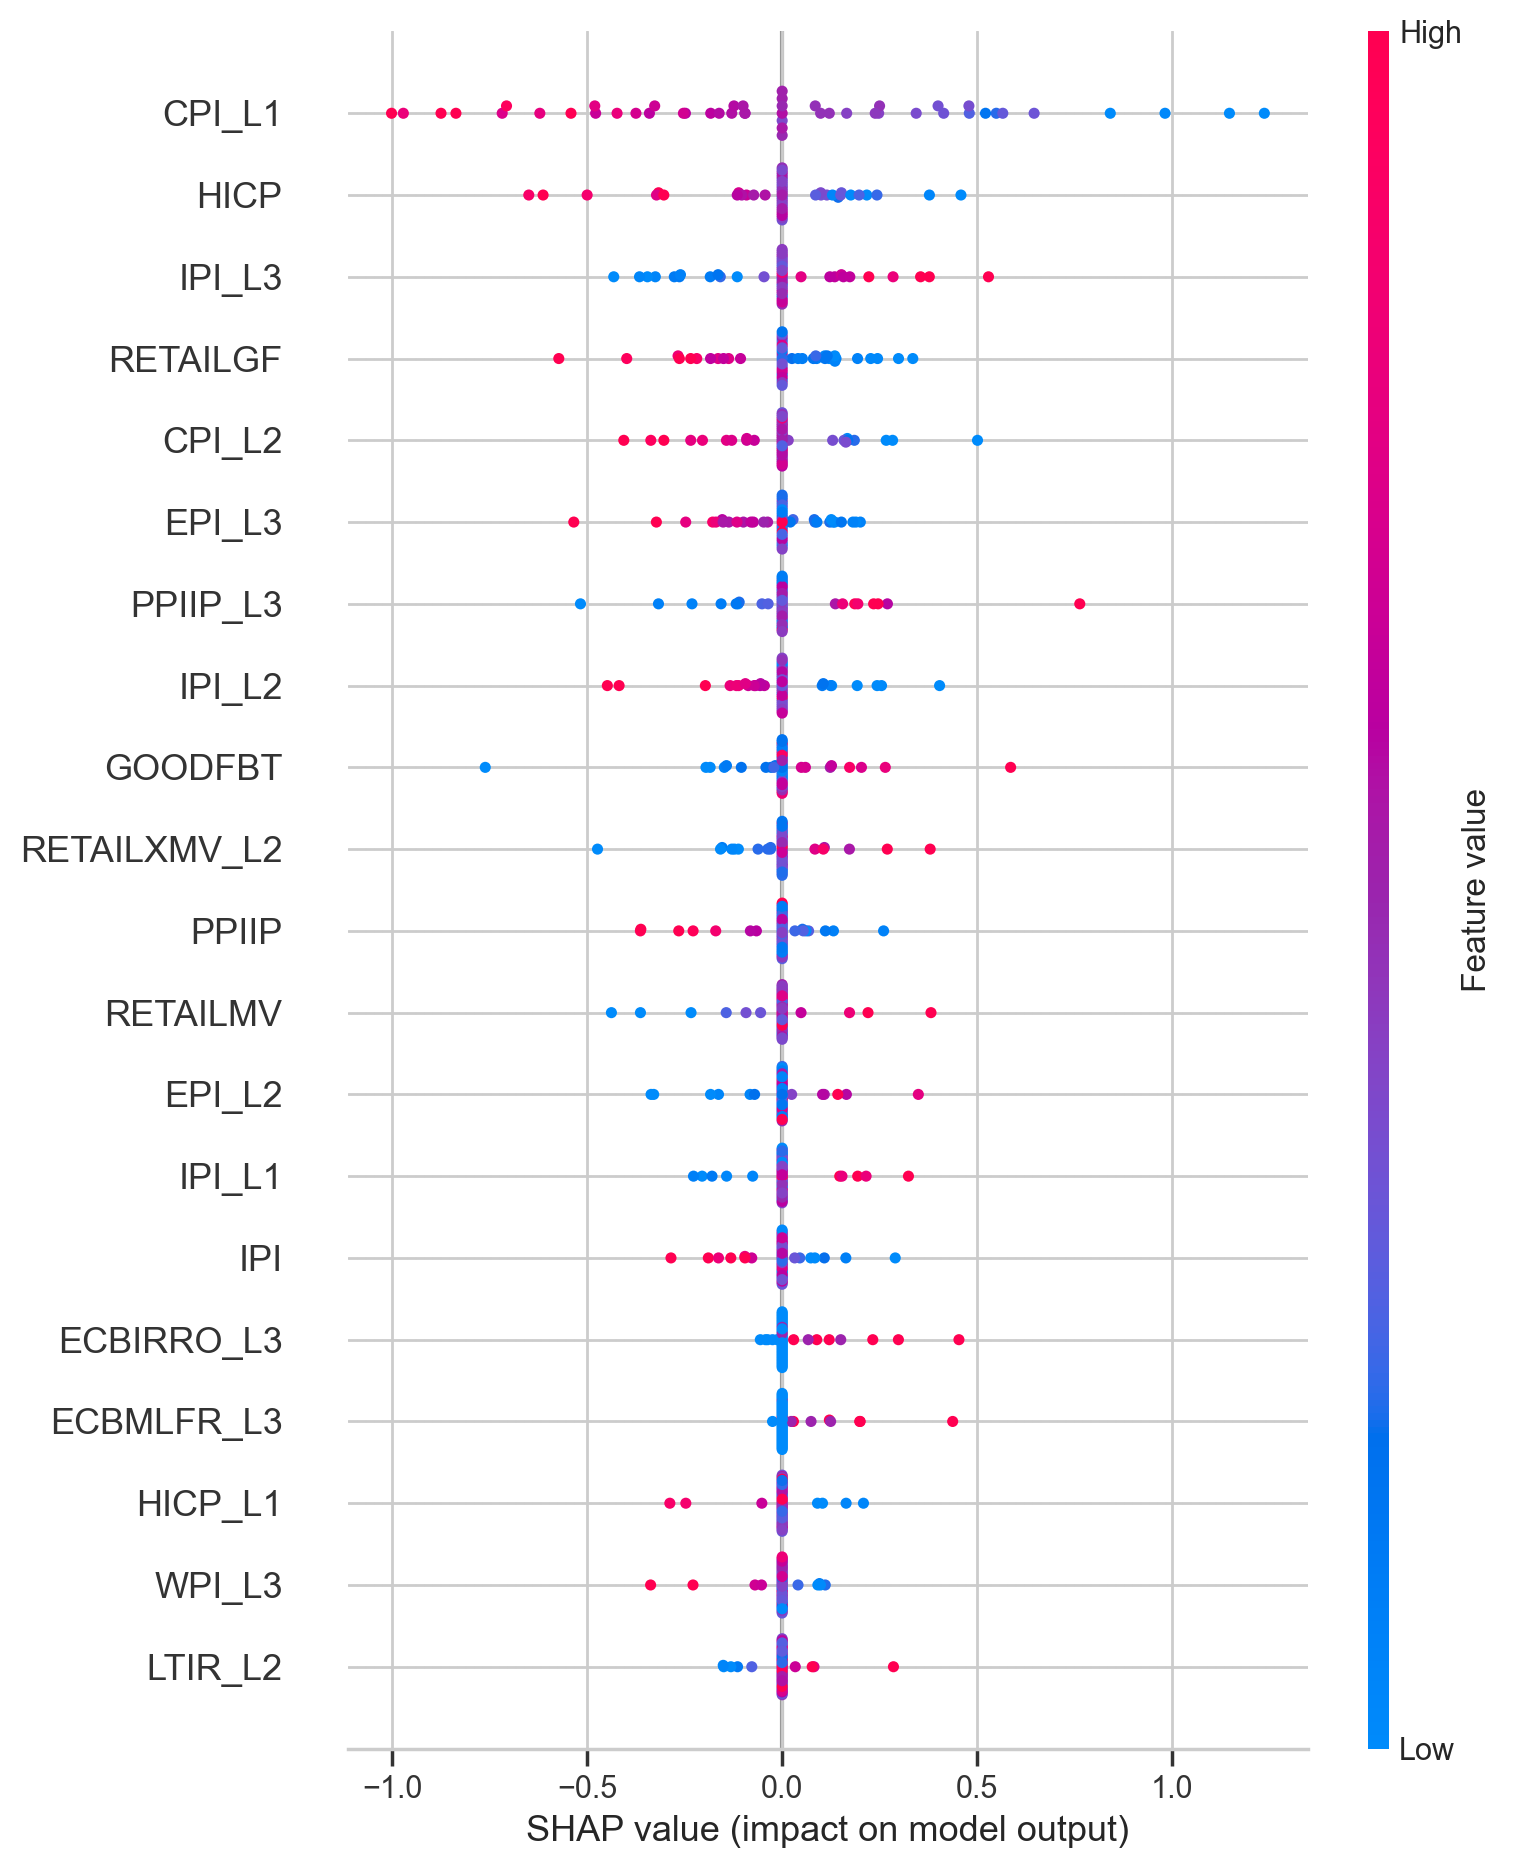

In [27]:
shap_values_3l, feature_names_3l = shappy(model_CL1D_3l, X_test_CL1D_3l, fnames_CL1D_3l)

# ***Top Influential Variables***

In [28]:
# Compute mean absolute SHAP values for each feature
shap_importance_3l = np.abs(shap_values_3l).mean(axis=0)

# Create a dictionary mapping feature names to their importance
shap_importance_dict_3l = dict(zip(feature_names_3l, shap_importance_3l))

# Sort features by importance (descending order)
sorted_features_3lags = sorted(shap_importance_dict_3l, key=shap_importance_dict_3l.get, reverse=True)

# Convert the dictionary to a list of (feature, importance) tuples
shap_importance_list_3l = list(shap_importance_dict_3l.items())

# Sort the list in descending order based on the importance value (second element of the tuple)
shap_importance_list_3l.sort(key=lambda item: item[1], reverse=True)


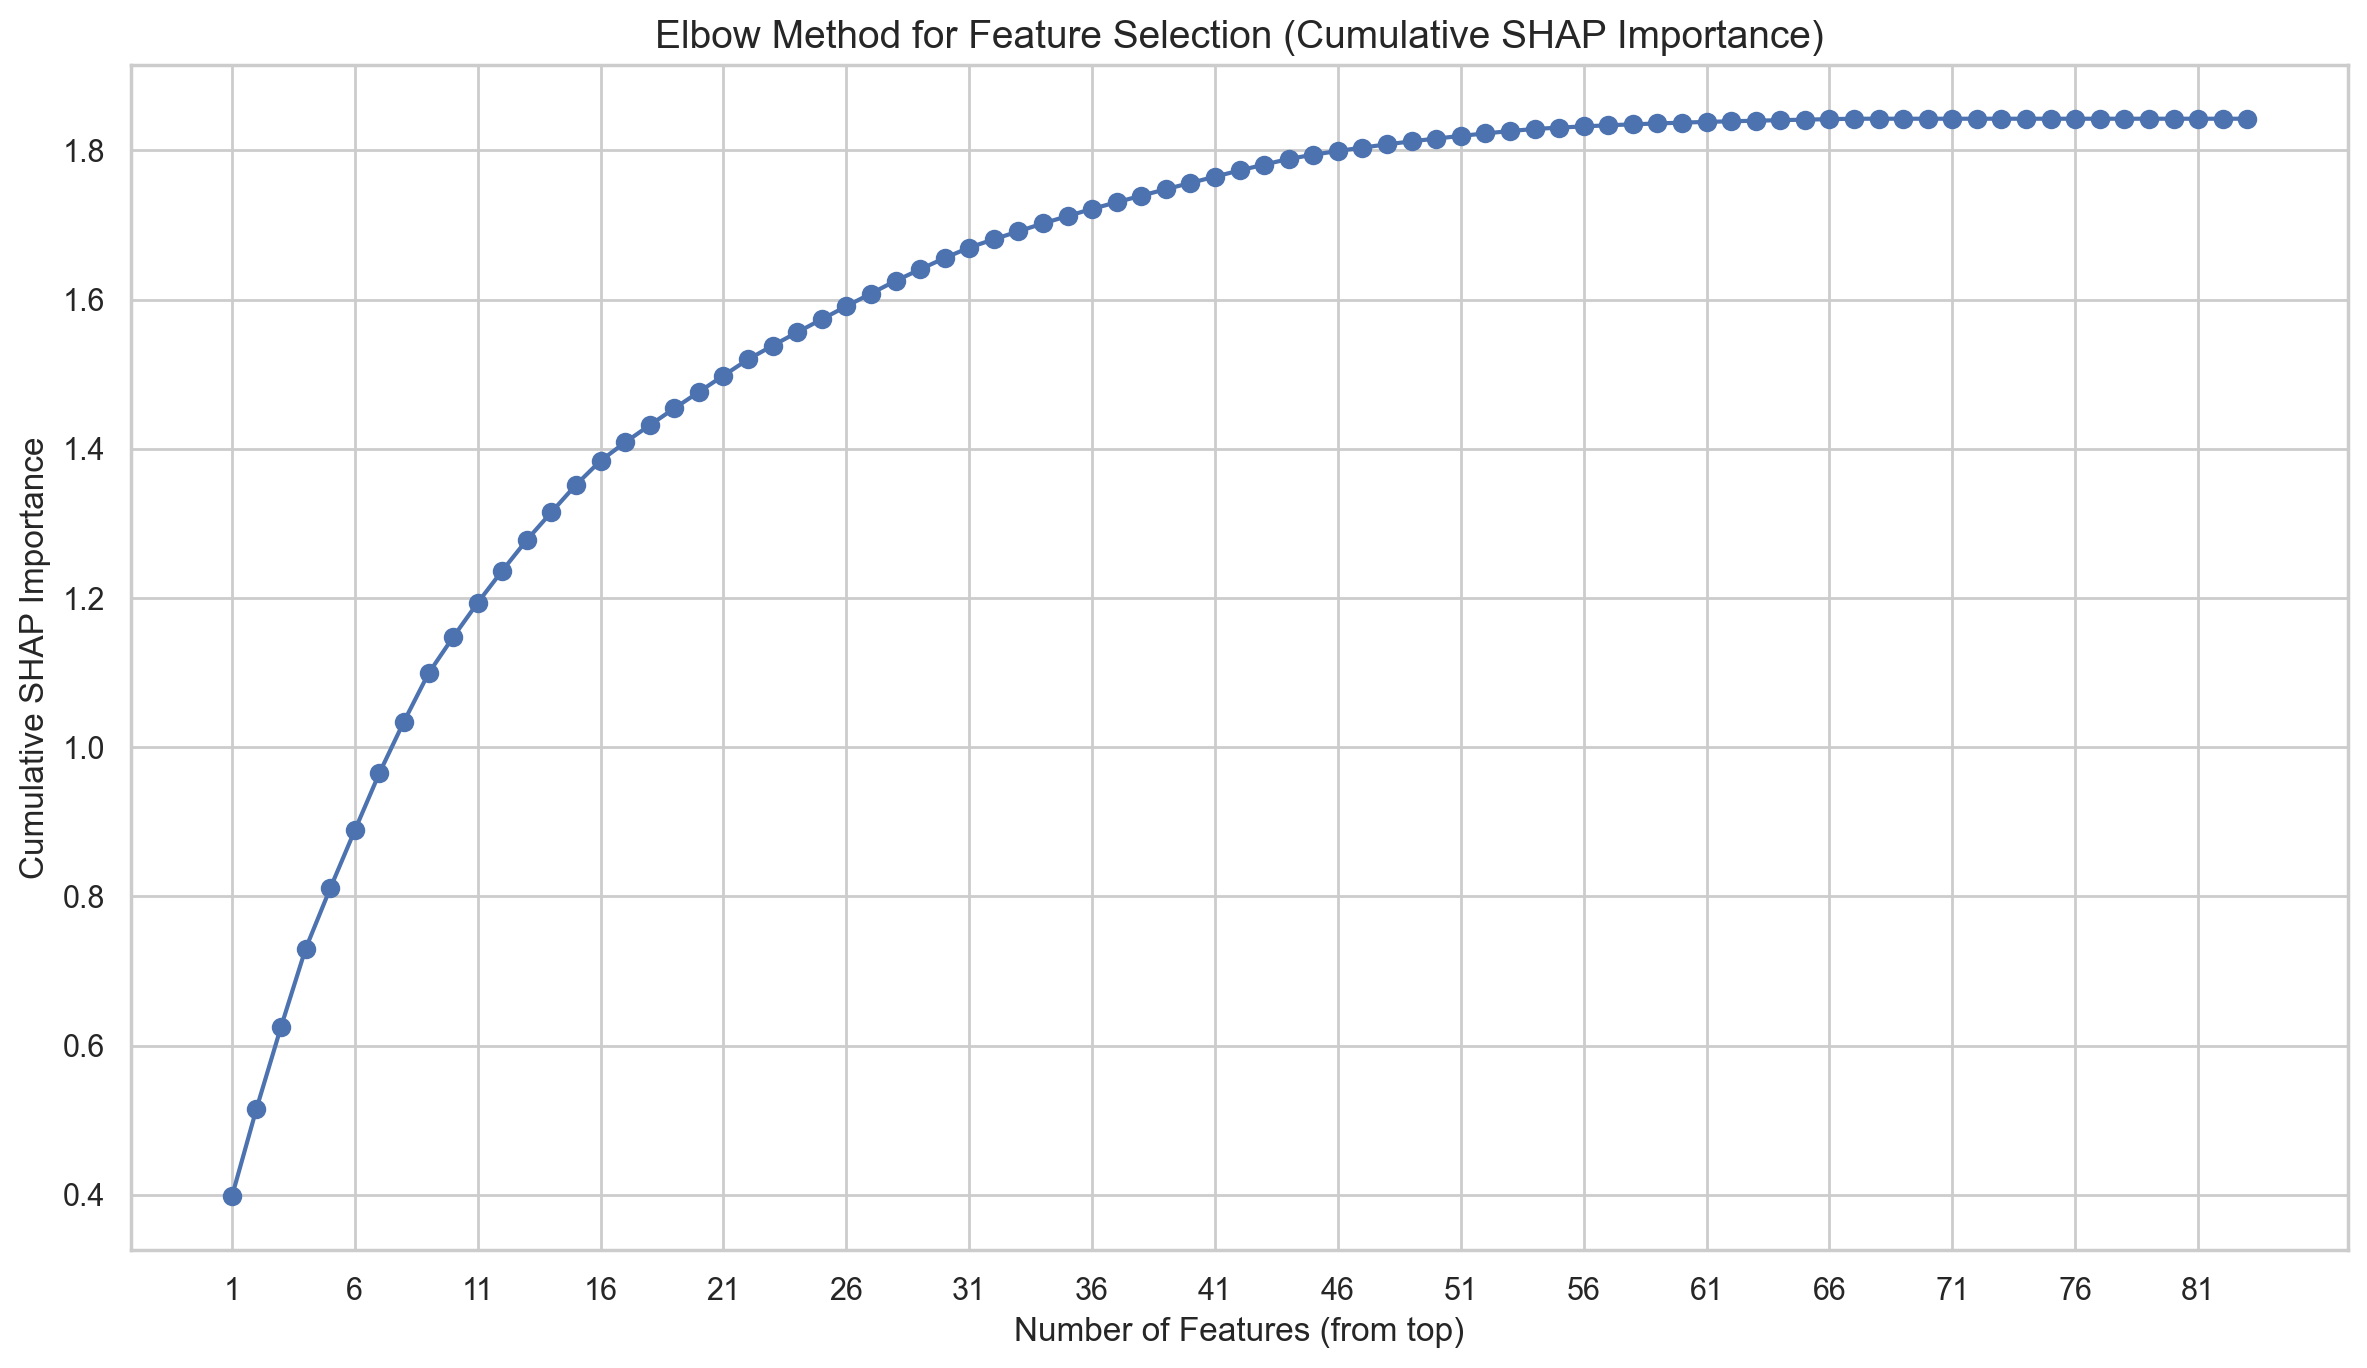

In [29]:
# Extract importance values
importance_values_3l = [item[1] for item in shap_importance_list_3l]

# Calculate cumulative importance
cumulative_importance = [sum(importance_values_3l[:i+1]) for i in range(len(importance_values_3l))]

# Plotting with adjustments
plt.figure(figsize=(12, 7))  # Increase figure size
plt.plot(range(1, len(importance_values_3l) + 1), cumulative_importance, marker='o', linestyle='-')
plt.xlabel("Number of Features (from top)", fontsize=12)
plt.ylabel("Cumulative SHAP Importance", fontsize=12)
plt.title("Elbow Method for Feature Selection (Cumulative SHAP Importance)", fontsize=14)
plt.grid(True)

# Adjust x-axis ticks to be less dense (show every 5 features)
plt.xticks(range(1, len(importance_values_3l) + 1, 5))

plt.tight_layout()
plt.show()

In [30]:
# Since no elbow we settle for the top 30 variables as this captures over 80% of the total importance
top_3lags_influential_variables = np.array(sorted_features_3lags)[:26]

# Print the top influential variables
print("*** Top 26 influential variables based on elbow ***")
print(top_3lags_influential_variables)
print("*** All variables sorted in order of influence ***")
print(sorted_features_3lags)

*** Top 26 influential variables based on elbow ***
['CPI_L1' 'HICP' 'IPI_L3' 'RETAILGF' 'CPI_L2' 'EPI_L3' 'PPIIP_L3' 'IPI_L2'
 'GOODFBT' 'RETAILXMV_L2' 'PPIIP' 'RETAILMV' 'EPI_L2' 'IPI_L1' 'IPI'
 'ECBIRRO_L3' 'ECBMLFR_L3' 'HICP_L1' 'WPI_L3' 'LTIR_L2' 'RETAILGF_L1'
 'RETAILGF_L2' 'HICP_L3' 'LTIR_L3' 'ECBMLFR' 'EPI']
*** All variables sorted in order of influence ***
['CPI_L1', 'HICP', 'IPI_L3', 'RETAILGF', 'CPI_L2', 'EPI_L3', 'PPIIP_L3', 'IPI_L2', 'GOODFBT', 'RETAILXMV_L2', 'PPIIP', 'RETAILMV', 'EPI_L2', 'IPI_L1', 'IPI', 'ECBIRRO_L3', 'ECBMLFR_L3', 'HICP_L1', 'WPI_L3', 'LTIR_L2', 'RETAILGF_L1', 'RETAILGF_L2', 'HICP_L3', 'LTIR_L3', 'ECBMLFR', 'EPI', 'PPIIP_L1', 'RETAILXMV', 'RETAILGSR_L1', 'ECBIRRO_L2', 'UNERWG_L3', 'RETAILGSR', 'STOXX50E_L2', 'LTIR', 'GOODFBT_L1', 'AGRPROD_L2', 'AGRPROD', 'EPI_L1', 'RETAILMV_L1', 'ECBDFR_L2', 'RETAILMV_L3', 'RETAILGF_L3', 'ECBIRRO', 'ECBMLFR_L2', 'WPI_L1', 'HICP_L2', 'GOODFBT_L3', 'PPIIP_L2', 'MMR', 'RETAILXMV_L1', 'AGRPROD_L1', 'GOODFBT_L2', 'RETAILGS

  0%|          | 0/50 [00:00<?, ?it/s]

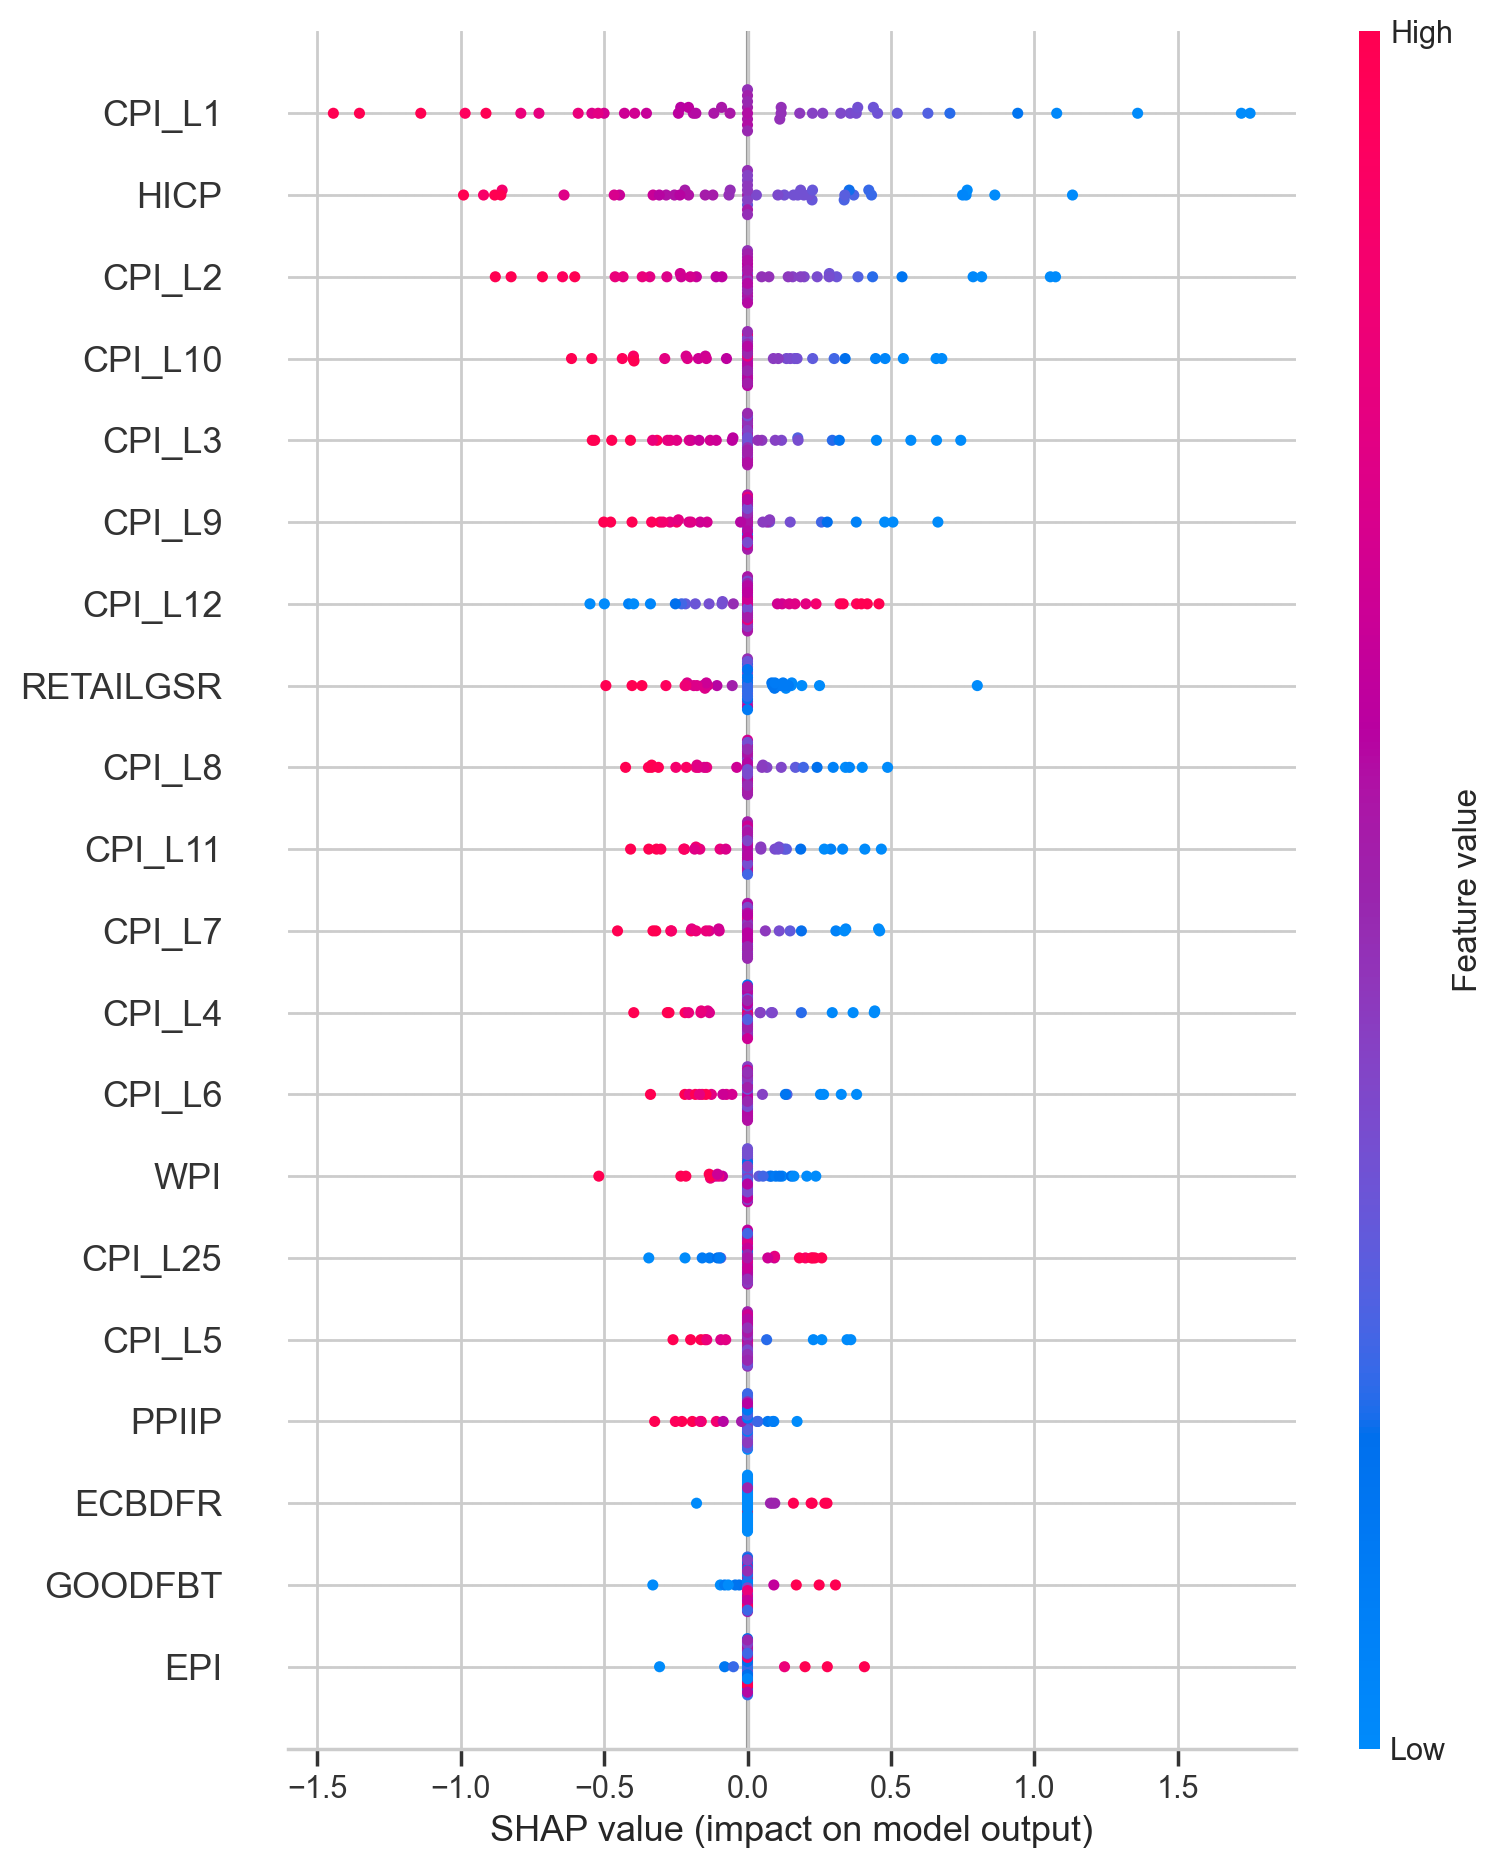

In [31]:
model_C1D_acf_shap_values, feature_names = shappy(model_C1D_acf, X_test_C1D_acf, fnames_C1D_acf)


In [32]:
# Compute mean absolute SHAP values for each feature
acf_shap_shap_importance = np.abs(model_C1D_acf_shap_values).mean(axis=0)

# Create a dictionary mapping feature names to their importance
acf_shap_importance_dict = dict(zip(feature_names, acf_shap_shap_importance))

# Sort features by importance (descending order)
acf_sorted_features = sorted(acf_shap_importance_dict, key=acf_shap_importance_dict.get, reverse=True)

# Convert the dictionary to a list of (feature, importance) tuples
acf_shap_importance_list = list(acf_shap_importance_dict.items())

# Sort the list in descending order based on the importance value (second element of the tuple)
acf_shap_importance_list.sort(key=lambda item: item[1], reverse=True)


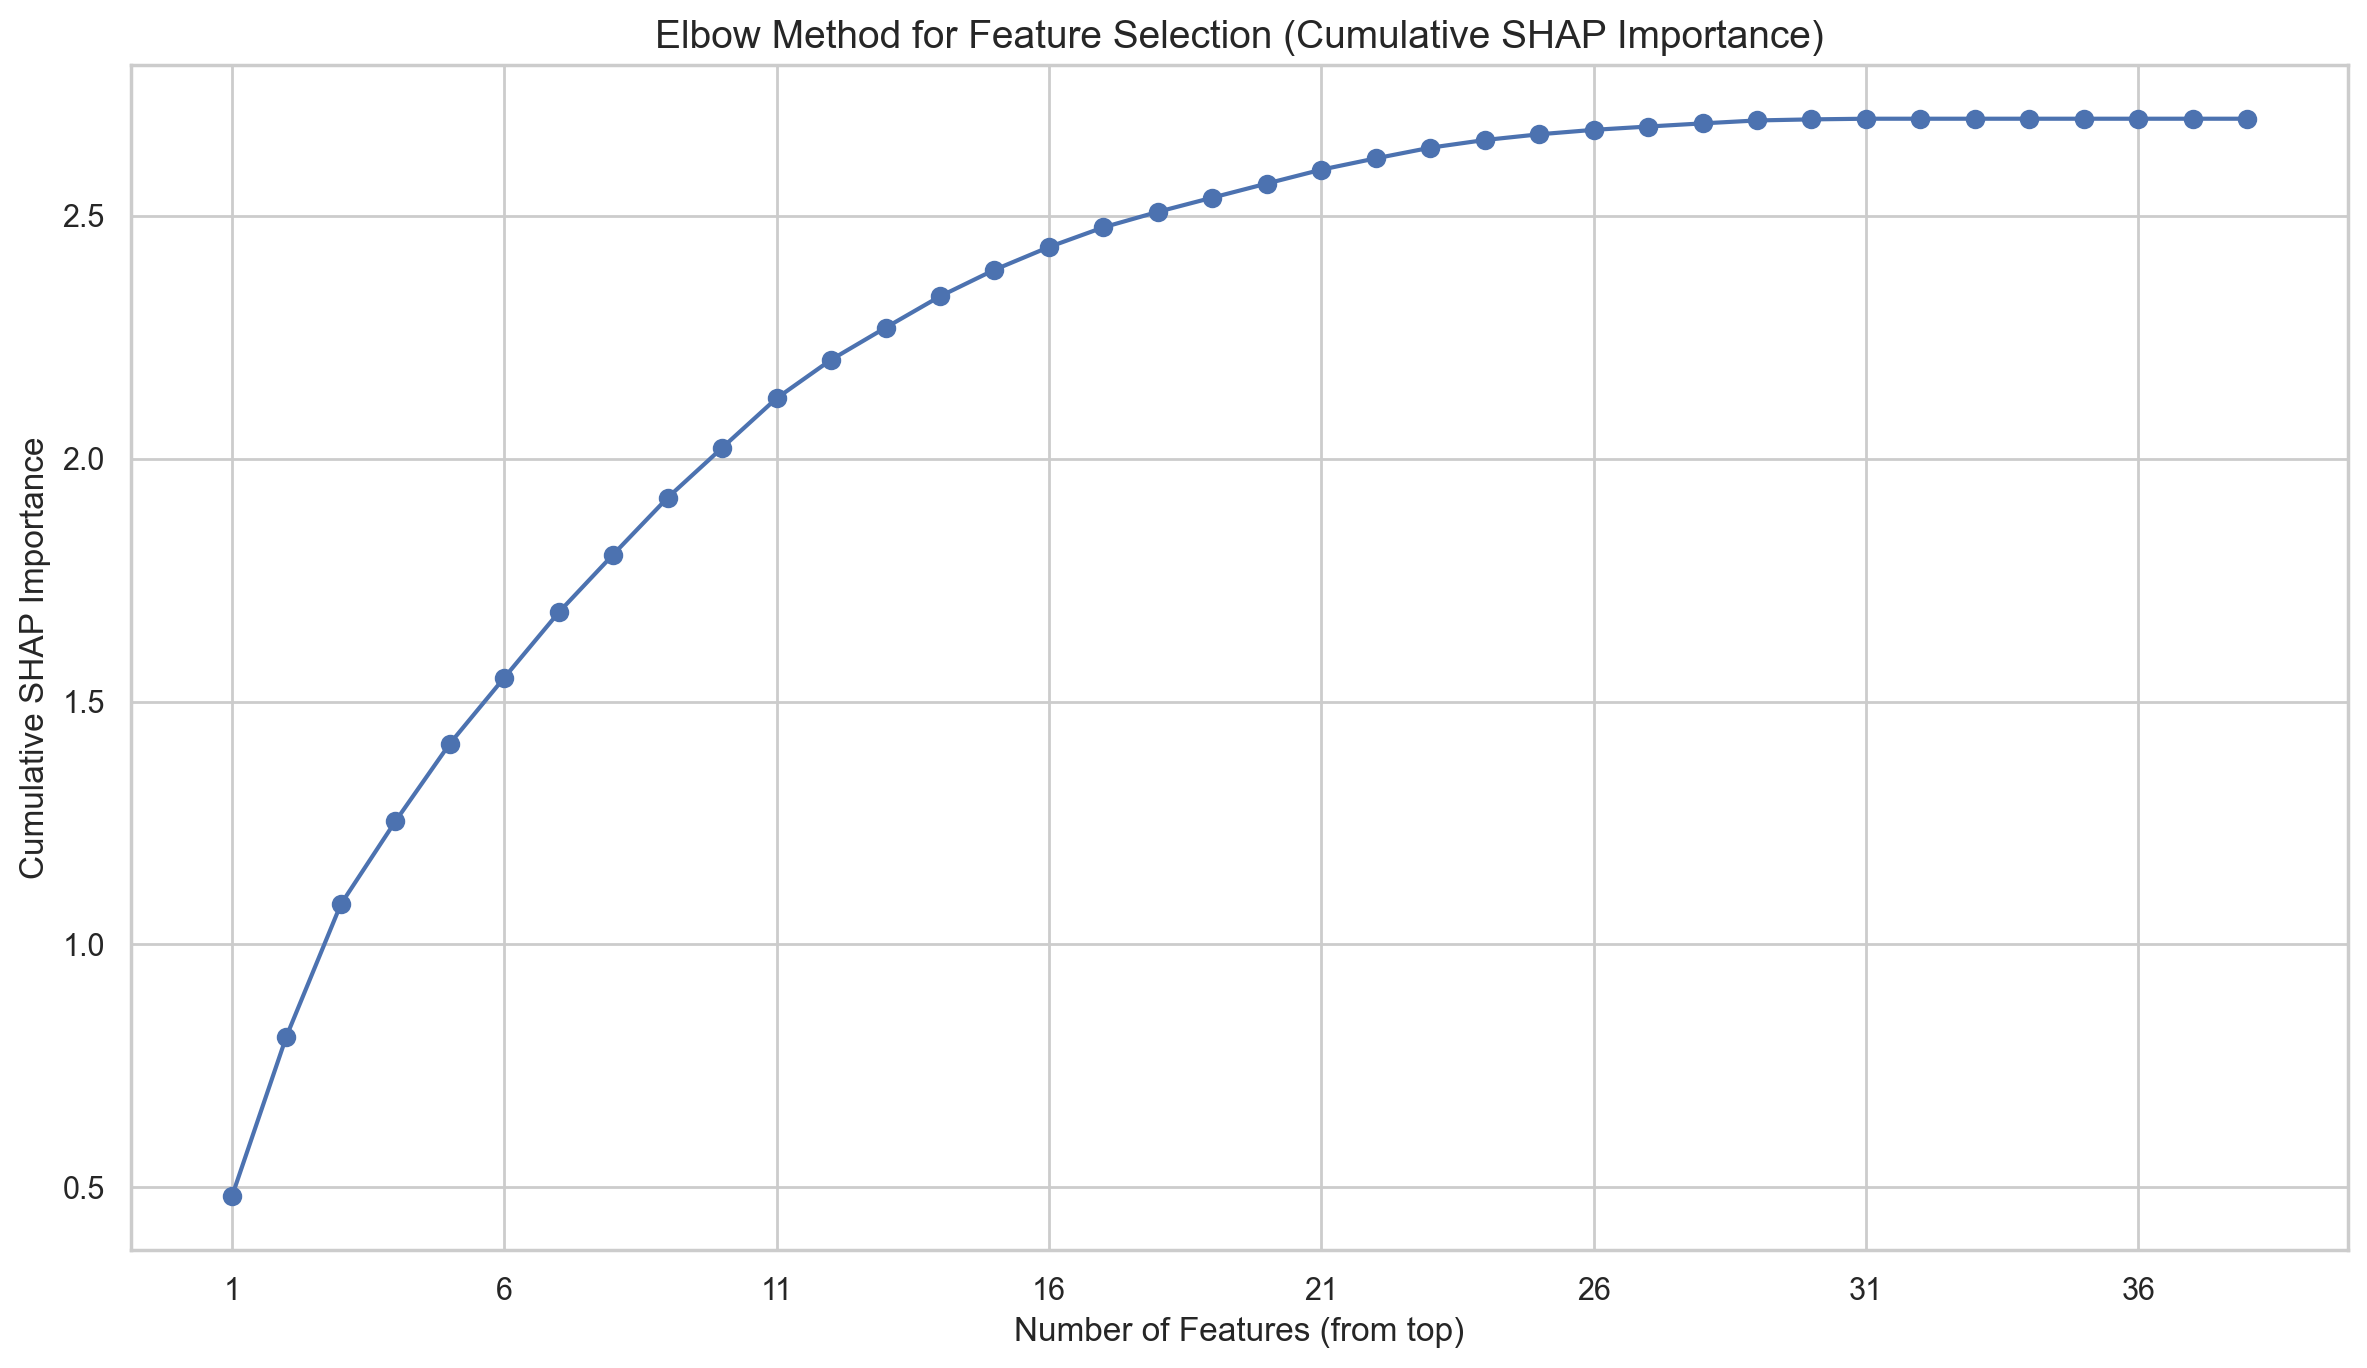

In [33]:
# Extract importance values
acf_importance_values = [item[1] for item in acf_shap_importance_list]

# Calculate cumulative importance
acf_cumulative_importance = [sum(acf_importance_values[:i+1]) for i in range(len(acf_importance_values))]

# Plotting with adjustments
plt.figure(figsize=(12, 7))  # Increase figure size
plt.plot(range(1, len(acf_importance_values) + 1), acf_cumulative_importance, marker='o', linestyle='-')
plt.xlabel("Number of Features (from top)", fontsize=12)
plt.ylabel("Cumulative SHAP Importance", fontsize=12)
plt.title("Elbow Method for Feature Selection (Cumulative SHAP Importance)", fontsize=14)
plt.grid(True)

# Adjust x-axis ticks to be less dense (show every 5 features)
plt.xticks(range(1, len(acf_importance_values) + 1, 5))

plt.tight_layout()
plt.show()

In [34]:
# Since no elbow we settle for the top 30 variables as this captures over 80% of the total importance
top_acf_influential_variables = np.array(acf_sorted_features)[:16]
# Print the top influential variables
print("*** Top 16 influential variables based on elbow ***")
print(top_acf_influential_variables)
print("*** All variables sorted in order of influence ***")
print(acf_sorted_features)

*** Top 16 influential variables based on elbow ***
['CPI_L1' 'HICP' 'CPI_L2' 'CPI_L10' 'CPI_L3' 'CPI_L9' 'CPI_L12'
 'RETAILGSR' 'CPI_L8' 'CPI_L11' 'CPI_L7' 'CPI_L4' 'CPI_L6' 'WPI' 'CPI_L25'
 'CPI_L5']
*** All variables sorted in order of influence ***
['CPI_L1', 'HICP', 'CPI_L2', 'CPI_L10', 'CPI_L3', 'CPI_L9', 'CPI_L12', 'RETAILGSR', 'CPI_L8', 'CPI_L11', 'CPI_L7', 'CPI_L4', 'CPI_L6', 'WPI', 'CPI_L25', 'CPI_L5', 'PPIIP', 'ECBDFR', 'GOODFBT', 'EPI', 'CPI_L36', 'CPI_L23', 'RETAILGF', 'RETAILMV', 'IPI', 'ECBMLFR', 'RETAILXMV', 'CPI_L35', 'CPI_L24', 'ECBIRRO', 'CPI_L37', 'UNERWG', 'MMR', 'AGRPROD', 'LTIR', 'UR', 'DAX', 'STOXX50E']


# ***Robust Test***

# ***ALL Models***

In [35]:


def train_and_evaluate_arima_model(data, auto_arima_model, title='ARIMA: Observed vs Fitted', target_column=target, test_size=test_size):

    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Extract target series
    train_series = train_df[target_column]
    test_series = test_df[target_column]

    arima_model = ARIMA(train_series.tolist(), order=auto_arima_model.order)
    model_fit = arima_model.fit()

    # Forecast `forecast_horizon` steps ahead (recursive)
    forecast = model_fit.forecast(steps=test_size)

    # Build output DataFrame
    forecast_index = test_series.index[:test_size]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=[target])
    actual_series = test_series.iloc[:test_size]

    # Metrics
    mae = mean_absolute_error(actual_series, forecast_df[target])
    rmse = np.sqrt(mean_squared_error(actual_series, forecast_df[target]))
    abs_error = np.abs(actual_series.values - forecast_df[target].values)
    return mae, rmse, abs_error

def train_eval_convlstm2D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_convlstm2D(data, target, test_size=test_size)
    model = build_model_convlstm2D(input_shape)
    mae, rmse, abs_error = model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y)
    return mae, rmse, abs_error

def train_eval_conv1D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size)
    model = build_model_conv1D(input_shape)
    mae, rmse, abs_error = model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y)
    return mae, rmse, abs_error

def train_eval_convlstm1D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size)
    model = build_model_convlstm1D((X_train.shape[1], X_train.shape[2]))
    mae, rmse, abs_error = model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y)
    return mae, rmse, abs_error

def model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y):
    history = train_model(model, X_train, y_train)
    loss, predictions = evaluate_model(model, X_test, y_test)
    y_test_actual = inverse_transform(scaler_y, y_test)
    predictions_actual = inverse_transform(scaler_y, predictions)
    mae = mean_absolute_error(y_test_actual, predictions_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
    abs_error = np.abs(y_test_actual.flatten() - predictions_actual.flatten())
    return mae, rmse, abs_error

def train_and_evaluate_var_model(data, lag_order, test_size):
    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Fit the VAR model
    model = VAR(train_df)
    var_model = model.fit(lag_order)

    input_data = train_df.values[-lag_order:]
    forecast = var_model.forecast(y=input_data, steps=test_size)

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(forecast, columns=train_df.columns, index=test_df.index)

    # Extract actual and forecasted values for HICP
    actual_hicp = test_df[target]
    forecasted_hicp = forecast_df[target]

    # Compute evaluation metrics
    mae = mean_absolute_error(actual_hicp, forecasted_hicp)
    rmse = np.sqrt(mean_squared_error(actual_hicp, forecasted_hicp))
    var_abs_error = np.abs(actual_hicp.values - forecasted_hicp.values)
    return mae, rmse, var_abs_error

def train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size, target_column=target):

    # Extract target series for SARIMA
    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Extract target series for SARIMA
    train_hicp_arima = train_df[target_column]
    test_hicp_arima = test_df[target_column]

    # Ensure the index is datetime for proper date manipulation
    train_hicp_arima.index = pd.to_datetime(train_hicp_arima.index)

    history = train_hicp_arima.tolist()
    sarima_model = SARIMAX(history,
                           order=auto_arima_model_sarima.order,
                           seasonal_order=auto_arima_model_sarima.seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)

    sarima_model_fit = sarima_model.fit(disp=False)  # disp=False to suppress convergence output
    forecast = sarima_model_fit.forecast(steps=test_size)
    forecast_df = pd.DataFrame(forecast, index=test_hicp_arima.index, columns=[target_column])

    mae_sarima = mean_absolute_error(test_hicp_arima, forecast_df[target_column])
    rmse_sarima = np.sqrt(mean_squared_error(test_hicp_arima, forecast_df[target_column]))
    forecasted_hicp = forecast_df[target_column]
    abs_error = np.abs(test_hicp_arima.values - forecasted_hicp.values)
    return mae_sarima, rmse_sarima, abs_error


# 100 Subsample run

In [36]:
series_name = "dfCPI_full_dataset_subsample"

# Column Definitions

In [37]:
main_nfe_cols = main_vars_cols
main_plus_3lags_cols = feature_3_lags_cols
main_plus_hicp_acf_pcf_lags_cols = main_nfe_cols + hicp_acf_pacf_lag_cols
main_top_IV_3_lags_cols = np.append(top_3lags_influential_variables, target)
main_top_IV_acf_pacf_cols = np.append(top_acf_influential_variables, target)
main_vae_cols = vae_hicp_cols
test_size = 12

Error Arrays

In [38]:
var_maes = []
var_rmses = []
var_all_forecasts = []

arima_maes = []
arima_rmses = []
arima_all_forecasts = []

sarima_maes = []
sarima_rmses = []
sarima_all_forecasts = []

c1D_nfe_maes = []
c1D_nfe_rmses = []
c1D_nfe_all_predictions = []

cl1D_nfe_maes = []
cl1D_nfe_rmses = []
cl1D_nfe_all_predictions = []

cl1D_acf_maes = []
cl1D_acf_rmses = []
cl1D_acf_all_predictions = []

cl1D_acf_shap_maes = []
cl1D_acf_shap_rmses = []
cl1D_acf_shap_all_predictions = []

cl1D_3lags_maes = []
cl1D_3lags_rmses = []
cl1D_3lags_all_predictions = []

cl1D_3lags_shap_maes = []
cl1D_3lags_shap_rmses = []
cl1D_3lags_shap_all_predictions = []

cl2D_nfe_maes = []
cl2D_nfe_rmses = []
cl2D_nfe_all_predictions = []

cl2D_vae_maes = []
cl2D_vae_rmses = []
cl2D_vae_all_predictions = []



In [39]:
# Pre-load all data
all_data_dict = {}
print("Loading all CSVs into memory...")
for i in tqdm(range(100), desc="Loading data"):
    filename = f"{series_name}_{i + 1}.csv"
    file_path = os.path.join(all_Series_CPI_target_dir, filename)
    df = pd.read_csv(file_path, index_col = 0)
    df.index.name = 'DATE' # Set the name of the index
    all_data_dict[i + 1] = df
print("All CSVs loaded.\n")

Loading all CSVs into memory...


Loading data: 100%|██████████| 100/100 [00:00<00:00, 288.73it/s]

All CSVs loaded.



In [40]:

for i in tqdm(range(100), desc="Processing models"):
    # filename = f"{series_name}_{i + 1}.csv"
    # file_path = os.path.join(all_LagsCPI_Dir, filename)
    # data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = all_data_dict[i + 1]
    base_data = data[main_nfe_cols]
    data_acf_pacf = data[main_plus_hicp_acf_pcf_lags_cols]
    data_3lags = data[main_plus_3lags_cols]
    data_acf_pacf_shap = data_acf_pacf[main_top_IV_acf_pacf_cols]
    data_3lags_shap = data_3lags[main_top_IV_3_lags_cols]
    data_vae = data[main_vae_cols]

    # VAR
    var_mae, var_rmse, var_forecasted_hicp = train_and_evaluate_var_model(base_data, var_lag_order, test_size=test_size)
    var_maes.append(var_mae)
    var_rmses.append(var_rmse)
    var_all_forecasts.append(var_forecasted_hicp)

    # ARIMA
    arima_mae, arima_rmse, arima_forecasted = train_and_evaluate_arima_model(base_data, auto_arima_model_arima, test_size=test_size)
    arima_maes.append(arima_mae)
    arima_rmses.append(arima_rmse)
    arima_all_forecasts.append(arima_forecasted)

    # SARIMA
    sarima_mae, sarima_rmse, sarima_forecasted_hicp = train_and_evaluate_sarima_model(base_data, auto_arima_model_sarima, test_size, target_column=target)
    sarima_maes.append(sarima_mae)
    sarima_rmses.append(sarima_rmse)
    sarima_all_forecasts.append(sarima_forecasted_hicp)

    # CONV1D NFE
    c1D_nfe_mae, c1D_nfe_rmse, c1D_nfe_all_prediction = train_eval_conv1D(base_data, target, test_size=test_size)
    c1D_nfe_maes.append(c1D_nfe_mae)
    c1D_nfe_rmses.append(c1D_nfe_rmse)
    c1D_nfe_all_predictions.append(c1D_nfe_all_prediction)

    # CONVLSTM1D NFE
    cl1D_nfe_mae, cl1D_nfe_rmse, cl1D_nfe_all_prediction = train_eval_convlstm1D(base_data, target, test_size=test_size)
    cl1D_nfe_maes.append(cl1D_nfe_mae)
    cl1D_nfe_rmses.append(cl1D_nfe_rmse)
    cl1D_nfe_all_predictions.append(cl1D_nfe_all_prediction)

    # CONVLSTM1D ACF/PACF LAGS
    cl1D_acf_mae, cl1D_acf_rmse, cl1D_acf_all_prediction = train_eval_convlstm1D(data_acf_pacf, target, test_size=test_size)
    cl1D_acf_maes.append(cl1D_acf_mae)
    cl1D_acf_rmses.append(cl1D_acf_rmse)
    cl1D_acf_all_predictions.append(cl1D_acf_all_prediction)

    # CONVLSTM1D ACF/PACF LAGS + SHAP
    cl1D_acf_shap_mae, cl1D_acf_shap_rmse, cl1D_acf_shap_all_prediction = train_eval_convlstm1D(data_acf_pacf_shap, target, test_size=test_size)
    cl1D_acf_shap_maes.append(cl1D_acf_shap_mae)
    cl1D_acf_shap_rmses.append(cl1D_acf_shap_rmse)
    cl1D_acf_shap_all_predictions.append(cl1D_acf_shap_all_prediction)

    # CONVLSTM1D 3 LAGS
    cl1D_3lags_mae, cl1D_3lags_rmse, cl1D_3lags_all_prediction = train_eval_convlstm1D(data_3lags, target, test_size=test_size)
    cl1D_3lags_maes.append(cl1D_3lags_mae)
    cl1D_3lags_rmses.append(cl1D_3lags_rmse)
    cl1D_3lags_all_predictions.append(cl1D_3lags_all_prediction)

    # CONVLSTM1D 3 LAGS + SHAP
    cl1D_3lags_shap_mae, cl1D_3lags_shap_rmse, cl1D_3lags_shap_all_prediction = train_eval_convlstm1D(data_3lags_shap, target, test_size=test_size)
    cl1D_3lags_shap_maes.append(cl1D_3lags_shap_mae)
    cl1D_3lags_shap_rmses.append(cl1D_3lags_shap_rmse)
    cl1D_3lags_shap_all_predictions.append(cl1D_3lags_shap_all_prediction)

    # CONVLSTM2D NFE
    cl2D_nfe_mae, cl2D_nfe_rmse, cl2D_nfe_all_prediction = train_eval_convlstm2D(base_data, target, test_size=test_size)
    cl2D_nfe_maes.append(cl2D_nfe_mae)
    cl2D_nfe_rmses.append(cl2D_nfe_rmse)
    cl2D_nfe_all_predictions.append(cl2D_nfe_all_prediction)

    # CONVLSTM2D VAE
    cl2D_vae_mae, cl2D_vae_rmse, cl2D_vae_all_prediction = train_eval_convlstm2D(data_vae, target, test_size=test_size)
    cl2D_vae_maes.append(cl2D_vae_mae)
    cl2D_vae_rmses.append(cl2D_vae_rmse)
    cl2D_vae_all_predictions.append(cl2D_vae_all_prediction)




Processing models: 100%|██████████| 100/100 [17:12:03<00:00, 619.23s/it]   


# Save Results

In [369]:
print("VAR")
print(np.mean(var_all_forecasts[0]))
print("C1D_NFE")
print(np.mean(c1D_nfe_all_predictions[0]))
print("SARIMA")
print(np.mean(sarima_all_forecasts[0]))
print("ARIMA")
print(np.mean(arima_all_forecasts[0]))
print("CNN ACF PACF")
print(np.mean(cl1D_acf_all_predictions[0]))
print("CNN ACF SHAP")
print(np.mean(cl1D_acf_shap_all_predictions[0]))
print("CL1D_NFE")
print(np.mean(cl1D_nfe_all_predictions[0]))
print("CL1D_3LAGS")
print(np.mean(cl1D_3lags_all_predictions[0]))
print("CL1D_3LAGS_SHAP")
print(np.mean(cl1D_3lags_shap_all_predictions[0]))
print("CL2D_NFE")
print(np.mean(cl2D_nfe_all_predictions[0]))
print("CL2D_VAE")
print(np.mean(cl2D_vae_all_predictions[0]))


VAR
0.9840186697281839
C1D_NFE
0.730452735086816
SARIMA
0.4646225341325152
ARIMA
0.8769058837215277
CNN ACF PACF
0.39498328077553707
CNN ACF SHAP
0.2829793852558497
CL1D_NFE
0.7071218843655119
CL1D_3LAGS
0.7299092133696252
CL1D_3LAGS_SHAP
0.5339045426173272
CL2D_NFE
1.0862256447399303
CL2D_VAE
1.1938737351652893


In [370]:
print("VAR")
print(var_all_forecasts)
print("C1D_NFE")
print(c1D_nfe_all_predictions)
print("SARIMA")
print(sarima_all_forecasts)
print("ARIMA")
print(arima_all_forecasts)
print("CNN ACF PACF")
print(cl1D_acf_all_predictions)
print("CNN ACF SHAP")
print(cl1D_acf_shap_all_predictions)
print("CL1D_NFE")
print(cl1D_nfe_all_predictions)
print("CL1D_3LAGS")
print(cl1D_3lags_all_predictions)
print("CL1D_3LAGS_SHAP")
print(cl1D_3lags_shap_all_predictions)
print("CL2D_NFE")
print(cl2D_nfe_all_predictions)
print("CL2D_VAE")
print(cl2D_vae_all_predictions)

VAR
[array([0.30012209, 1.24759706, 1.81644298, 1.71565628, 1.62033475,
       0.11253679, 1.78873651, 1.71754128, 1.08546692, 0.08826996,
       0.2529746 , 0.06254482])]
C1D_NFE
[array([0.90827886, 0.01471621, 0.16453607, 1.71394191, 1.73351681,
       0.19101053, 0.17057038, 0.50517968, 1.22579124, 0.53025923,
       0.75685258, 0.85077931])]
SARIMA
[array([0.22531243, 1.02699728, 1.30633411, 0.42582583, 0.22233004,
       0.66155248, 0.56645461, 0.16522684, 0.38875184, 0.25615871,
       0.04623343, 0.28429281])]
ARIMA
[array([0.11106946, 0.48502387, 1.2328372 , 1.39789801, 1.8574537 ,
       0.76847163, 0.87414847, 0.98123423, 0.86875169, 0.65047822,
       0.6477752 , 0.64772892])]
CNN ACF PACF
[array([0.71710316, 0.75103952, 0.88304944, 0.35463575, 0.05138419,
       0.76788121, 0.21453262, 0.25179293, 0.43396359, 0.10170295,
       0.14342682, 0.06928718])]
CNN ACF SHAP
[array([0.03369077, 0.73226709, 0.10499816, 0.67119453, 0.15811838,
       0.14100575, 0.5459181 , 0.23091509

In [41]:
# Directory to save output
output_dir = "model_results"
os.makedirs(output_dir, exist_ok=True)

# Model data
model_results = {
    "VAR": (var_maes, var_rmses, var_all_forecasts),
    "ARIMA": (arima_maes, arima_rmses, arima_all_forecasts),
    "SARIMA": (sarima_maes, sarima_rmses, sarima_all_forecasts),
    "C1D_NFE": (c1D_nfe_maes, c1D_nfe_rmses, c1D_nfe_all_predictions),
    "CL1D_NFE": (cl1D_nfe_maes, cl1D_nfe_rmses, cl1D_nfe_all_predictions),
    "CL1D_ACF": (cl1D_acf_maes, cl1D_acf_rmses, cl1D_acf_all_predictions),
    "CL1D_ACF_SHAP": (cl1D_acf_shap_maes, cl1D_acf_shap_rmses, cl1D_acf_shap_all_predictions),
    "CL1D_3LAGS": (cl1D_3lags_maes, cl1D_3lags_rmses, cl1D_3lags_all_predictions),
    "CL1D_3LAGS_SHAP": (cl1D_3lags_shap_maes, cl1D_3lags_shap_rmses, cl1D_3lags_shap_all_predictions),
    "CL2D_NFE": (cl2D_nfe_maes, cl2D_nfe_rmses, cl2D_nfe_all_predictions),
    "CL2D_VAE": (cl2D_vae_maes, cl2D_vae_rmses, cl2D_vae_all_predictions),
}


# Save MAEs
mae_df = pd.DataFrame({model: maes for model, (maes, _, _) in model_results.items()})
mae_df.index.name = "Iteration"
mae_df.to_csv(os.path.join(output_dir, "all_mae.csv"))

# Save RMSEs
rmse_df = pd.DataFrame({model: rmses for model, (_, rmses, _) in model_results.items()})
rmse_df.index.name = "Iteration"
rmse_df.to_csv(os.path.join(output_dir, "all_rmse.csv"))

# Save Forecasts (wide format)
forecast_wide = pd.DataFrame()
for model, (_, _, forecasts) in model_results.items():
    forecasts_array = np.squeeze(np.array(forecasts))
    col_names = [f"{model}_step{i+1}" for i in range(forecasts_array.shape[1])]
    forecast_df = pd.DataFrame(forecasts_array, columns=col_names)
    forecast_wide = pd.concat([forecast_wide, forecast_df], axis=1)

# for model, (_, _, forecasts) in model_results.items():
#     # Extract the single array inside the list
#     if isinstance(forecasts, list) and len(forecasts) == 1 and isinstance(forecasts[0], np.ndarray):
#         forecasts_array = forecasts[0].reshape(1, -1)  # Make it (1, 12)
#     else:
#         raise ValueError(f"Unexpected format for forecasts in model {model}: {type(forecasts)}")
#
#     # Create column names
#     col_names = [f"{model}_step{i+1}" for i in range(forecasts_array.shape[1])]
#
#     # Convert to DataFrame and concatenate
#     forecast_df = pd.DataFrame(forecasts_array, columns=col_names)
#     forecast_wide = pd.concat([forecast_wide, forecast_df], axis=1)


forecast_wide.index.name = "Iteration"
forecast_wide.to_csv(os.path.join(output_dir, "all_forecasts.csv"))

ValueError: Unexpected format for forecasts in model VAR: <class 'list'>

In [42]:
forecast_wide = pd.DataFrame()
for model, (_, _, forecasts) in model_results.items():
    forecasts_array = np.squeeze(np.array(forecasts))
    col_names = [f"{model}_step{i+1}" for i in range(forecasts_array.shape[1])]
    forecast_df = pd.DataFrame(forecasts_array, columns=col_names)
    forecast_wide = pd.concat([forecast_wide, forecast_df], axis=1)
forecast_wide.index.name = "Iteration"
forecast_wide.to_csv(os.path.join(output_dir, "all_forecasts.csv"))

# THE END

In [ ]:
# Compare performance at each step
conv_lstm_vae_errors = np.array(cnn_vae_all_predictions).reshape(100, test_size)  # Reshape to (100, 12)
conv_lstm_sel_step_errors = np.array(cnn_sel_all_predictions).reshape(100, test_size)  # Reshape to (100, 12)
conv_lstm_step_errors = np.array(cnn_all_predictions).reshape(100, test_size)
sarima_step_errors = np.array(sarima_all_forecasts).reshape(100, test_size)
arima_step_errors = np.array(arima_all_forecasts).reshape(100, test_size)  # Reshape to (100, 12)
var_step_errors = np.array(var_all_forecasts).reshape(100, test_size)

# Calculate standard deviation for each step
conv_lstm_vae_step_std = np.std(np.abs(conv_lstm_vae_errors), axis=0)
conv_lstm_sel_step_std = np.std(np.abs(conv_lstm_sel_step_errors), axis=0)
conv_lstm_step_std = np.std(np.abs(conv_lstm_step_errors), axis=0)  # Standard deviation across 100 runs
sarima_step_std = np.std(np.abs(sarima_step_errors), axis=0)
arima_step_std = np.std(np.abs(arima_step_errors), axis=0)  # Standard deviation across 100 runs
var_step_std = np.std(np.abs(var_step_errors), axis=0)

# Calculate mean absolute error for each step
conv_lstm_vae_step_mae = np.mean(np.abs(conv_lstm_vae_errors), axis=0)  # Average across 100 runs
conv_lstm_sel_step_mae = np.mean(np.abs(conv_lstm_sel_step_errors), axis=0)
conv_lstm_step_mae = np.mean(np.abs(conv_lstm_step_errors), axis=0)  # Average across 100 runs
sarima_step_mae = np.mean(np.abs(sarima_step_errors), axis=0)
arima_step_mae = np.mean(np.abs(arima_step_errors), axis=0)  # Average across 100 runs
var_step_mae = np.mean(np.abs(var_step_errors), axis=0)


In [ ]:


# Plotting
plt.figure(figsize=(14, 7))

# Plot ConvLSTM MAE with shaded confidence interval
# plt.plot(range(1, 25), var_step_mae, label='VAR', marker='o', linestyle='-', color='green', alpha=0.8)

# plt.plot(range(1, 25), conv_lstm_sel_step_mae, label='ConvLSTM + Var Sel MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
#                  conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
#                  color='gray', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot ConvLSTM MAE with shaded confidence interval
plt.plot(range(1, test_size+1), conv_lstm_step_mae, label='ConvLSTM MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
plt.fill_between(range(1, test_size+1),
                 conv_lstm_step_mae - conv_lstm_step_std,
                 conv_lstm_step_mae + conv_lstm_step_std,
                 color='blue', alpha=0.3, label='ConvLSTM Confidence Interval')

# Plot SARIMA MAE with shaded confidence interval
plt.plot(range(1, test_size+1), sarima_step_mae, label='SARIMA MAE', marker='x', linestyle='--', color='deeppink', alpha=0.8)
plt.fill_between(range(1, test_size+1),
                 sarima_step_mae - sarima_step_std,
                 sarima_step_mae + sarima_step_std,
                 color='deeppink', alpha=0.3, label='SARIMA Confidence Interval')

# Plot ARIMA MAE with shaded confidence interval
plt.plot(range(1, test_size+1), arima_step_mae, label='ARIMA MAE', marker='x', linestyle='--', color='indigo', alpha=0.8)
plt.fill_between(range(1, test_size+1),
                 arima_step_mae - arima_step_std,
                 arima_step_mae + arima_step_std,
                 color='indigo', alpha=0.3, label='ARIMA Confidence Interval')

# Customize the plot
plt.title('Average MAE & Confidence Interval', fontsize=16)
plt.xlabel('Forecast Month', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:


# Plotting
plt.figure(figsize=(14, 7))

# Plot ConvLSTM MAE with shaded confidence interval

# plt.plot(range(1, test_size+1), var_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='green', alpha=0.8)

plt.plot(range(1, test_size+1), conv_lstm_sel_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
#                  conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
#                  color='gray', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot ConvLSTM MAE with shaded confidence interval
plt.plot(range(1, test_size+1), conv_lstm_step_mae, label='ConvLSTM MAE', marker='o', linestyle='-', color='gray', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_step_mae - conv_lstm_step_std,
#                  conv_lstm_step_mae + conv_lstm_step_std,
#                  color='blue', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot SARIMA MAE with shaded confidence interval
plt.plot(range(1, test_size+1), sarima_step_mae, label='SARIMA MAE', marker='x', linestyle='--', color='red', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  sarima_step_mae - sarima_step_std,
#                  sarima_step_mae + sarima_step_std,
#                  color='red', alpha=0.2, label='SARIMA Confidence Interval')

# Plot ARIMA MAE with shaded confidence interval
plt.plot(range(1, test_size+1), arima_step_mae, label='ARIMA MAE', marker='x', linestyle='--', color='purple', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  arima_step_mae - arima_step_std,
#                  arima_step_mae + arima_step_std,
#                  color='purple', alpha=0.2, label='ARIMA Confidence Interval')

# Customize the plot
plt.title('Average MAE over 24 Months Test Split', fontsize=16)
plt.xlabel('Forecast Month', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:


# Plotting
plt.figure(figsize=(14, 7))

# Plot ConvLSTM MAE with shaded confidence interval

# plt.plot(range(1, 25), var_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='green', alpha=0.8)
plt.plot(range(1, 25), conv_lstm_vae_step_mae, label='ConvLSTM + VAE', marker='o', linestyle='-', color='maroon', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
#                  conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
#                  color='gray', alpha=0.2, label='ConvLSTM Confidence Interval')

plt.plot(range(1, 25), conv_lstm_sel_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
#                  conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
#                  color='gray', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot ConvLSTM MAE with shaded confidence interval
plt.plot(range(1, 25), conv_lstm_step_mae, label='ConvLSTM MAE', marker='o', linestyle='-', color='gray', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_step_mae - conv_lstm_step_std,
#                  conv_lstm_step_mae + conv_lstm_step_std,
#                  color='blue', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot SARIMA MAE with shaded confidence interval
plt.plot(range(1, 25), sarima_step_mae, label='SARIMA MAE', marker='x', linestyle='--', color='red', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  sarima_step_mae - sarima_step_std,
#                  sarima_step_mae + sarima_step_std,
#                  color='red', alpha=0.2, label='SARIMA Confidence Interval')

# Plot ARIMA MAE with shaded confidence interval
plt.plot(range(1, 25), arima_step_mae, label='ARIMA MAE', marker='x', linestyle='--', color='purple', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  arima_step_mae - arima_step_std,
#                  arima_step_mae + arima_step_std,
#                  color='purple', alpha=0.2, label='ARIMA Confidence Interval')

# Customize the plot
plt.title('Average MAE over 24 Months Test Split', fontsize=16)
plt.xlabel('Forecast Month', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:
# Compare performance at each step
conv_lstm_sel_step_errors = np.array(cnn_sel_all_predictions).reshape(100, 24)  # Reshape to (100, 12)
conv_lstm_step_errors = np.array(cnn_all_predictions).reshape(100, 24)

# Calculate standard deviation for each step
conv_lstm_sel_step_std = np.std(np.abs(conv_lstm_sel_step_errors), axis=0)
conv_lstm_step_std = np.std(np.abs(conv_lstm_step_errors), axis=0)  # Standard deviation across 100 runs

# Calculate mean absolute error for each step
conv_lstm_sel_step_mae = np.mean(np.abs(conv_lstm_sel_step_errors), axis=0)
conv_lstm_step_mae = np.mean(np.abs(conv_lstm_step_errors), axis=0)  # Average across 100 runs


In [ ]:


# Plotting
plt.figure(figsize=(14, 7))

# Plot ConvLSTM + Variable Selection MAE with shaded confidence interval
plt.plot(range(1, 25), conv_lstm_sel_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='cyan', alpha=0.8)
plt.fill_between(range(1, 25),
                 conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
                 conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
                 color='cyan', alpha=0.3, label='ConvLSTM + VS Confidence Interval')

# Plot ConvLSTM MAE with shaded confidence interval
plt.plot(range(1, 25), conv_lstm_step_mae, label='ConvLSTM MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
plt.fill_between(range(1, 25),
                 conv_lstm_step_mae - conv_lstm_step_std,
                 conv_lstm_step_mae + conv_lstm_step_std,
                 color='blue', alpha=0.3, label='ConvLSTM Confidence Interval')

# Customize the plot
plt.title('Average MAE & Confidence Interval', fontsize=16)
plt.xlabel('Forecast Month', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:
sns.histplot(cnn_maes, kde=True, bins=20, label="CNN-LSTM", color="blue", alpha=0.6)
sns.histplot(cnn_sel_maes, kde=True, bins=20, label="CNN-LSTM + VS", color="cyan", alpha=0.6)
sns.histplot(var_maes, kde=True, bins=20, label="VAR", color="green", alpha=0.6)
sns.histplot(sarima_maes, kde=True, bins=20, label="SARIMA", color="red", alpha=0.6)
sns.histplot(arima_maes, kde=True, bins=20, label="ARIMA", color="purple", alpha=0.6)

plt.legend()
plt.title("Histogram of MAE values")
plt.show()

t.show()
Kolmogorov-Smirnov (K-S) Test
Best for large samples (n > 50).

If p < 0.05, the data is not normally distributed.

In [ ]:
from scipy.stats import kstest

print("Kolmogorov-Smirnov (K-S) Test for Normality")
print("if p < 0.05, the data is not normally distributed\n")

stat, p = kstest(cnn_maes, 'norm', args=(np.mean(cnn_maes), np.std(cnn_maes)))
print(f"K-S Test for CNN-LSTM MAE: p-value = {p}")

stat, p = kstest(cnn_sel_maes, 'norm', args=(np.mean(cnn_sel_maes), np.std(cnn_sel_maes)))
print(f"K-S Test for CNN-LSTM + VS MAE: p-value = {p}")

stat, p = kstest(sarima_maes, 'norm', args=(np.mean(sarima_maes), np.std(sarima_maes)))
print(f"K-S Test for SARIMA MAE: p-value = {p}")

stat, p = kstest(arima_maes, 'norm', args=(np.mean(arima_maes), np.std(arima_maes)))
print(f"K-S Test for ARIMA MAE: p-value = {p}")

stat, p = kstest(var_maes, 'norm', args=(np.mean(var_maes), np.std(var_maes)))
print(f"K-S Test for VAR MAE: p-value = {p}")


Significance Test

In [ ]:
import scipy.stats as stats

f_statistic, p_value = stats.f_oneway(cnn_maes, cnn_sel_maes, sarima_maes, arima_maes, var_maes)

print(f"ANOVA F-statistic: {f_statistic}, p-value: {p_value}")

# Decision
if p_value < 0.05:
    print("Significant difference found! Proceed with post-hoc analysis.")
else:
    print("No significant difference between the models.")


Post-hoc Analysis

Pairwise t-tests with Bonferroni correction

In [ ]:
from itertools import combinations

models = {
    "CNN-LSTM": cnn_maes,
    "CNN-LSTM + VS": cnn_sel_maes,
    "SARIMA": sarima_maes,
    "ARIMA": arima_maes,
    "VAR": var_maes
}

# Perform pairwise t-tests with Bonferroni correction
# Generate all possible model pairs
model_pairs = list(combinations(models.keys(), 2))
num_tests = len(model_pairs)  # Number of comparisons

# Bonferroni-adjusted significance level
alpha = 0.05
adjusted_alpha = alpha / num_tests

# Perform paired t-tests and apply Bonferroni correction
results = []
for model1, model2 in model_pairs:
    t_stat, p_value = stats.ttest_rel(models[model1], models[model2])  # Paired T-Test
    significant = p_value < adjusted_alpha  # Check significance after Bonferroni correction
    results.append((model1, model2, p_value, significant))

# Print results
print(f"Bonferroni-adjusted alpha: {adjusted_alpha:.5f}\n")
print(f"{'Model 1':<15}{'Model 2':<15}{'p-value':<20}{'Significant?'}")
print("-" * 60)
for model1, model2, p_value, significant in results:
    print(f"{model1:<15}{model2:<15}{p_value:<20.6f}{'Yes' if significant else 'No'}")



# CODE OF AGES

In [ ]:
f_result_Dir = "ForecastResults/"
m_result_Dir = "MAEsResults/"
r_result_Dir = "RMSEsResults/"
read_dir = r_State_Dir

In [ ]:
# Function for created multi-step ahead data sets
def shift_target_per_step(data, target_col='HICP', horizon=1):
    data = data.copy()
    data[target_col] = data[target_col].shift(-horizon + 1)
    return data.dropna()

In [ ]:
forecast_horizons = [1, 2, 3]  # Corresponds to dfCPI_L1, dfCPI_L2, dfCPI_L3
num_subsamples = 100

for horizon in forecast_horizons:
    horizon_name = f"dfCPI_L{horizon}"

    # Initialize metrics and forecasts for each model
    metrics = {
        "VAR": {"maes": [], "rmses": [], "forecasts": []},
        "CNN-LSTM": {"maes": [], "rmses": [], "forecasts": []},
        "CNN-LSTM + VS": {"maes": [], "rmses": [], "forecasts": []},
        "SARIMA": {"maes": [], "rmses": [], "forecasts": []},
        "ARIMA": {"maes": [], "rmses": [], "forecasts": []}
    }

    for i in range(num_subsamples):
        filename = f"{horizon_name}_rolling_data_norm_{i+1}.csv"
        file_path = os.path.join(all_LagsCPI_Dir, filename)
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)

        # --- CNN-LSTM ---
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_r(data, 'HICP', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        _, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        metrics["CNN-LSTM"]["maes"].append(mean_absolute_error(y_test_actual, predictions_actual))
        metrics["CNN-LSTM"]["rmses"].append(np.sqrt(mean_squared_error(y_test_actual, predictions_actual)))
        metrics["CNN-LSTM"]["forecasts"].append(pd.Series(predictions_actual.flatten(), index=test_index))

        # --- CNN-LSTM + Variable Selection ---
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_var_sel(data, 'HICP', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        _, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        metrics["CNN-LSTM + VS"]["maes"].append(mean_absolute_error(y_test_actual, predictions_actual))
        metrics["CNN-LSTM + VS"]["rmses"].append(np.sqrt(mean_squared_error(y_test_actual, predictions_actual)))
        metrics["CNN-LSTM + VS"]["forecasts"].append(pd.Series(predictions_actual.flatten(), index=test_index))

        # --- SARIMA ---
        mae, rmse, forecast = train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size=62)
        metrics["SARIMA"]["maes"].append(mae)
        metrics["SARIMA"]["rmses"].append(rmse)
        metrics["SARIMA"]["forecasts"].append(forecast)

        # --- ARIMA ---
        forecast, mae, rmse = train_and_evaluate_arima_model(data, auto_arima_model_arima, test_size=62)
        metrics["ARIMA"]["maes"].append(mae)
        metrics["ARIMA"]["rmses"].append(rmse)
        metrics["ARIMA"]["forecasts"].append(forecast)

        # --- VAR ---
        mae, rmse, forecast = train_and_evaluate_var_model(data, lag_order, test_size=62)
        metrics["VAR"]["maes"].append(mae)
        metrics["VAR"]["rmses"].append(rmse)
        metrics["VAR"]["forecasts"].append(forecast)

    # --- Save Forecasts ---
    for model_name, values in metrics.items():
        forecast_df = pd.concat(values["forecasts"], axis=1)
        forecast_df.columns = [f"Forecast_{i+1}" for i in range(len(values["forecasts"]))]
        forecast_path = os.path.join(f_result_Dir, f"{model_name.replace(' ', '_')}_forecasts_{horizon}_month_ahead.csv")
        forecast_df.to_csv(forecast_path)

    # --- Save Metrics ---
    maes_df = pd.DataFrame({model: data["maes"] for model, data in metrics.items()})
    maes_df.to_csv(os.path.join(m_result_Dir, f"maess_{horizon}_month_ahead.csv"), index=False)

    rmses_df = pd.DataFrame({model: data["rmses"] for model, data in metrics.items()})
    rmses_df.to_csv(os.path.join(r_result_Dir, f"rmses_{horizon}_month_ahead.csv"), index=False)

    print(f"[{horizon_name}] Forecasts and metrics saved for {horizon}-month ahead.")


In [ ]:

forecast_horizons = [1, 2, 3]

for steps in forecast_horizons:

    # Initialize lists for each model
    var_maes, var_rmses, var_all_forecasts = [], [], []
    cnn_maes, cnn_rmses, cnn_all_predictions = [], [], []
    cnn_sel_maes, cnn_sel_rmses, cnn_sel_all_predictions = [], [], []
    sarima_maes, sarima_rmses, sarima_all_forecasts = [], [], []
    arima_maes, arima_rmses, arima_all_forecasts = [], [], []

    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        # data = shift_target_per_step(pd.read_csv(file_path), horizon=steps)

        # CNN-LSTM model
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_r(data, 'HICP', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        mae = mean_absolute_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
        cnn_maes.append(mae)
        cnn_rmses.append(rmse)
        predictions_series = pd.Series(predictions_actual.flatten(), index=test_index)
        cnn_all_predictions.append(predictions_series)

        # CNN-LSTM + VarSel model
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_var_sel(data, 'HICP', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        mae_cnn_sel = mean_absolute_error(y_test_actual, predictions_actual)
        rmse_cnn_sel = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
        cnn_sel_maes.append(mae_cnn_sel)
        cnn_sel_rmses.append(rmse_cnn_sel)
        predictions_series = pd.Series(predictions_actual.flatten(), index=test_index)
        cnn_sel_all_predictions.append(predictions_series)

        # SARIMA model
        mae_sarima, rmse_sarima, forecasted_sarima = train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size=62)
        sarima_maes.append(mae_sarima)
        sarima_rmses.append(rmse_sarima)
        sarima_all_forecasts.append(forecasted_sarima)

        # ARIMA model
        forecasted_arima, mae_arima, rmse_arima = train_and_evaluate_arima_model(data, auto_arima_model_arima, test_size=62)
        arima_maes.append(mae_arima)
        arima_rmses.append(rmse_arima)
        arima_all_forecasts.append(forecasted_arima)

        # VAR model
        mae_var, rmse_var, forecasted_var = train_and_evaluate_var_model(data, lag_order, test_size=62)
        var_maes.append(mae_var)
        var_rmses.append(rmse_var)
        var_all_forecasts.append(forecasted_var)

    models_maes = {
        "CNN-LSTM": cnn_maes,
        "CNN-LSTM + VS": cnn_sel_maes,
        "SARIMA": sarima_maes,
        "ARIMA": arima_maes,
        "VAR": var_maes
    }

    models_rmses = {
        "CNN-LSTM": cnn_rmses,
        "CNN-LSTM + VS": cnn_sel_rmses,
        "SARIMA": sarima_rmses,
        "ARIMA": arima_rmses,
        "VAR": var_rmses
    }

    sarima_forecast_df = pd.concat(sarima_all_forecasts, axis=1)
    sarima_forecast_df.columns = [f"Forecast_{i+1}" for i in range(len(sarima_all_forecasts))]

    cnn_all_predictions_df = pd.concat(cnn_all_predictions, axis=1)
    cnn_all_predictions_df.columns = [f"Forecast_{i+1}" for i in range(len(cnn_all_predictions))]

    cnn_sel_all_predictions_df = pd.concat(cnn_sel_all_predictions, axis=1)
    cnn_sel_all_predictions_df.columns = [f"Forecast_{i+1}" for i in range(len(cnn_sel_all_predictions))]

    arima_all_forecasts_df = pd.concat(arima_all_forecasts, axis=1)
    arima_all_forecasts_df.columns = [f"Forecast_{i+1}" for i in range(len(arima_all_forecasts))]

    var_all_forecasts_df = pd.concat(var_all_forecasts, axis=1)
    var_all_forecasts_df.columns = [f"Forecast_{i+1}" for i in range(len(var_all_forecasts))]


    models_forecasts = {
        "CNN-LSTM": cnn_all_predictions_df,
        "CNN-LSTM + VS": cnn_sel_all_predictions_df,
        "SARIMA":  sarima_forecast_df,
        "ARIMA": arima_all_forecasts_df,
        "VAR": var_all_forecasts_df
    }

    # Save each model's forecast as a separate CSV file
    for model_name, df in models_forecasts.items():
        output_path = os.path.join(f_result_Dir, f"{model_name.replace(' ', '_')}_forecasts_{steps}_month_ahead.csv")
        df.to_csv(output_path)

    maes_df = pd.DataFrame(models_maes)
    maes_df.to_csv(os.path.join(m_result_Dir, f"maess_{steps}_month_ahead.csv"), index=False)

    rmses_df = pd.DataFrame(models_rmses)
    rmses_df.to_csv(os.path.join(r_result_Dir, f"rmses_{steps}_month_ahead.csv"), index=False)

    print(f"Forecasts and MAEs for {steps}-month ahead saved to CSV files.")

In [ ]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12]

for steps in forecast_horizons:

    # Initialize lists for each model
    var_maes, var_rmses, var_all_forecasts = [], [], []
    cnn_maes, cnn_rmses, cnn_all_predictions = [], [], []
    cnn_sel_maes, cnn_sel_rmses, cnn_sel_all_predictions = [], [], []
    sarima_maes, sarima_rmses, sarima_all_forecasts = [], [], []
    arima_maes, arima_rmses, arima_all_forecasts = [], [], []

    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        data = shift_target_per_step(pd.read_csv(file_path), horizon=steps)

        # CNN-LSTM model
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_r(data, 'HICP', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        mae = mean_absolute_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
        cnn_maes.append(mae)
        # cnn_rmses.append(rmse)
        # predictions_series = pd.Series(predictions_actual.flatten(), index=test_index)
        # cnn_all_predictions.append(predictions_series)

        # CNN-LSTM + VarSel model
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_var_sel(data, 'HICP', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        mae_cnn_sel = mean_absolute_error(y_test_actual, predictions_actual)
        rmse_cnn_sel = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
        cnn_sel_maes.append(mae_cnn_sel)
        # cnn_sel_rmses.append(rmse_cnn_sel)
        # predictions_series = pd.Series(predictions_actual.flatten(), index=test_index)
        # cnn_sel_all_predictions.append(predictions_series)

        # SARIMA model
        mae_sarima, rmse_sarima, forecasted_sarima = train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size=62)
        sarima_maes.append(mae_sarima)
        # sarima_rmses.append(rmse_sarima)
        # sarima_all_forecasts.append(forecasted_sarima)

        # ARIMA model
        forecasted_arima, mae_arima, rmse_arima = train_and_evaluate_arima_model(data, auto_arima_model_arima, test_size=62)
        arima_maes.append(mae_arima)
        # arima_rmses.append(rmse_arima)
        # arima_all_forecasts.append(forecasted_arima)

        # VAR model
        mae_var, rmse_var, forecasted_var = train_and_evaluate_var_model(data, lag_order, test_size=62)
        var_maes.append(mae_var)
        # var_rmses.append(rmse_var)
        # var_all_forecasts.append(forecasted_var)

    models_maes = {
        "CNN-LSTM": cnn_maes,
        "CNN-LSTM + VS": cnn_sel_maes,
        "SARIMA": sarima_maes,
        "ARIMA": arima_maes,
        "VAR": var_maes
    }

    # models_rmses = {
    #     "CNN-LSTM": cnn_rmses,
    #     "CNN-LSTM + VS": cnn_sel_rmses,
    #     "SARIMA": sarima_rmses,
    #     "ARIMA": arima_rmses,
    #     "VAR": var_rmses
    # }

    # sarima_forecast_df = pd.concat(sarima_all_forecasts, axis=1)
    # sarima_forecast_df.columns = [f"Forecast_{i+1}" for i in range(len(sarima_all_forecasts))]
    # 
    # cnn_all_predictions_df = pd.concat(cnn_all_predictions, axis=1)
    # cnn_all_predictions_df.columns = [f"Forecast_{i+1}" for i in range(len(cnn_all_predictions))]
    # 
    # cnn_sel_all_predictions_df = pd.concat(cnn_sel_all_predictions, axis=1)
    # cnn_sel_all_predictions_df.columns = [f"Forecast_{i+1}" for i in range(len(cnn_sel_all_predictions))]
    # 
    # arima_all_forecasts_df = pd.concat(arima_all_forecasts, axis=1)
    # arima_all_forecasts_df.columns = [f"Forecast_{i+1}" for i in range(len(arima_all_forecasts))]
    # 
    # var_all_forecasts_df = pd.concat(var_all_forecasts, axis=1)
    # var_all_forecasts_df.columns = [f"Forecast_{i+1}" for i in range(len(var_all_forecasts))]
    # 

    # models_forecasts = {
    #     "CNN-LSTM": cnn_all_predictions_df,
    #     "CNN-LSTM + VS": cnn_sel_all_predictions_df,
    #     "SARIMA":  sarima_forecast_df,
    #     "ARIMA": arima_all_forecasts_df,
    #     "VAR": var_all_forecasts_df
    # }

    # Save each model's forecast as a separate CSV file
    for model_name, df in models_forecasts.items():
        output_path = os.path.join(f_result_Dir, f"{model_name.replace(' ', '_')}_forecasts_{steps}_month_ahead.csv")
        df.to_csv(output_path)

    maes_df = pd.DataFrame(models_maes)
    maes_df.to_csv(os.path.join(m_result_Dir, f"maess_{steps}_month_ahead.csv"), index=False)
    # 
    # rmses_df = pd.DataFrame(models_rmses)
    # rmses_df.to_csv(os.path.join(r_result_Dir, f"rmses_{steps}_month_ahead.csv"), index=False)

    print(f"Forecasts and MAEs for {steps}-month ahead saved to CSV files.")

In [ ]:
print(f"Auto ARIMA Order: {auto_arima_model_sarima.order}")
print(f"Auto ARIMA Seasonal Order: {auto_arima_model_sarima.seasonal_order}")

print(len(data) // 5)

# JUNK

# IGNORE

In [ ]:
forecast_horizons = [1, 2, 3]

var_results = {}
cnn_sel_results = {}
sarima_results = {}
arima_results = {}


for steps in forecast_horizons:

    # VAR model for each random state
    var_maes, var_rmses, var_all_forecasts = [], [], []
    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        data = random_data.copy()

        mae, rmse, forecasted_hicp = train_and_evaluate_var_model(data, lag_order, steps=steps)
        var_maes.append(mae)
        var_rmses.append(rmse)
        var_all_forecasts.append(forecasted_hicp)

    # var_results[f"{steps}_month_ahead"] = {
    #     "maes": var_maes,
    #     "rmses": var_rmses,
    #     "forecasts": var_all_forecasts
    # }

    # CNN-LSTM + VarSel model for each random state
    cnn_sel_maes, cnn_sel_rmses, cnn_sel_all_predictions = [], [], []
    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        shuffled_data = pd.read_csv(file_path)

        X_train, y_train, X_test, y_test, scaler_y = prep_data_for_cnn_var_sel(shuffled_data, 'HICP', forecast_horizon=steps, test_size=24)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)

        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)

        mae = mean_absolute_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))

        cnn_sel_maes.append(mae)
        cnn_sel_rmses.append(rmse)
        cnn_sel_all_predictions.append(predictions)

    # cnn_sel_results[f"{steps}_month_ahead"] = {
    #     "maes": cnn_sel_maes,
    #     "rmses": cnn_sel_rmses,
    #     "forecasts": cnn_sel_all_predictions
    # }

    # SARIMA model for each random state
    sarima_maes, sarima_rmses, sarima_all_forecasts = [], [], []
    for i in range(100):
        # Read shuffled data from CSV file
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        # Create data DataFrame with selected columns
        data = random_data.copy()
        mae, rmse, forecasted_hicp = train_and_evaluate_sarima_model(data, auto_arima_model_sarima)
        sarima_maes.append(mae)
        sarima_rmses.append(rmse)
        sarima_all_forecasts.append(forecasted_hicp)

    # sarima_results[f"{steps}_month_ahead"] = {
    #     "maes": sarima_maes,
    #     "rmses": sarima_rmses,
    #     "forecasts": sarima_all_forecasts
    # }

    # ARIMA model for each random state
    arima_maes, arima_rmses, arima_all_forecasts = [], [], []
    for i in range(100):
        # Read shuffled data from CSV file
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        # Create data DataFrame with selected columns
        data = random_data.copy()
        train_df = data.iloc[:-24]
        test_df = data.iloc[-24:]
        forecasted_hicp, mae, rmse = train_and_evaluate_arima_model(train_df, test_df, auto_arima_model_arima)
        arima_maes.append(mae)
        arima_rmses.append(rmse)
        arima_all_forecasts.append(forecasted_hicp)

    # sarima_results[f"{steps}_month_ahead"] = {
    #     "maes": sarima_maes,
    #     "rmses": sarima_rmses,
    #     "forecasts": sarima_all_forecasts
    # }

    models_maes = {
        "CNN-LSTM": cnn_maes,
        "CNN-LSTM + VS": cnn_sel_maes,
        "SARIMA": sarima_maes,
        "ARIMA": arima_maes,
        "VAR": var_maes
    }
    
    models_forecasts = {
        "CNN-LSTM": cnn_all_predictions,
        "CNN-LSTM + VS": cnn_sel_all_predictions,
        "SARIMA": sarima_all_forecasts,
        "ARIMA": arima_all_forecasts,
        "VAR": var_all_forecasts
    }

    # --- Save the forecasts to a CSV file ---
    forecasts_df = pd.DataFrame(models_forecasts)
    forecasts_df.to_csv(f"forecasts_{steps}_month_ahead.csv", index=False)
    # --- Save the MAEs to a CSV file ---
    maes_df = pd.DataFrame(models_maes)
    maes_df.to_csv(f"maes_{steps}_month_ahead.csv", index=False)
    
    print(f"Forecasts and MAEs for {steps}-month ahead saved to CSV files.")





In [ ]:
forecast_horizons = [1, 2, 3]

var_results = {}
for steps in forecast_horizons:
    var_maes, var_rmses, var_all_forecasts = [], [], []

    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        data = random_data.copy()

        mae, rmse, forecasted_hicp = train_and_evaluate_var_model(data, lag_order, steps=steps)
        var_maes.append(mae)
        var_rmses.append(rmse)
        var_all_forecasts.append(forecasted_hicp)

    var_results[f"{steps}_month_ahead"] = {
        "maes": var_maes,
        "rmses": var_rmses,
        "forecasts": var_all_forecasts
    }

cnn_sel_results = {}
for steps in forecast_horizons:
    cnn_sel_maes, cnn_sel_rmses, cnn_sel_all_predictions = [], [], []

    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        shuffled_data = pd.read_csv(file_path)
    
        X_train, y_train, X_test, y_test, scaler_y = prep_data_for_cnn_var_sel(shuffled_data, 'HICP', forecast_horizon=steps, test_size=24)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
    
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
    
        mae = mean_absolute_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
    
        cnn_sel_maes.append(mae)
        cnn_sel_rmses.append(rmse)
        cnn_sel_all_predictions.append(predictions)

    cnn_sel_results[f"{steps}_month_ahead"] = {
        "maes": cnn_sel_maes,
        "rmses": cnn_sel_rmses,
        "forecasts": cnn_sel_all_predictions
    }


sarima_results = {}
for steps in forecast_horizons:
    sarima_maes, sarima_rmses, sarima_all_forecasts = [], [], []

    for i in range(100):
    # Read shuffled data from CSV file
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        # Create data DataFrame with selected columns
        data = random_data.copy()
        mae, rmse, forecasted_hicp = train_and_evaluate_sarima_model(data, auto_arima_model_sarima)
        sarima_maes.append(mae)
        sarima_rmses.append(rmse)
        sarima_all_forecasts.append(forecasted_hicp)

    sarima_results[f"{steps}_month_ahead"] = {
        "maes": sarima_maes,
        "rmses": sarima_rmses,
        "forecasts": sarima_all_forecasts
    }

arima_results = {}
for steps in forecast_horizons:
    arima_maes, arima_rmses, arima_all_forecasts = [], [], []

    for i in range(100):
    # Read shuffled data from CSV file
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        # Create data DataFrame with selected columns
        data = random_data.copy()
        train_df = data.iloc[:-24]
        test_df = data.iloc[-24:]
        forecasted_hicp, mae, rmse = train_and_evaluate_arima_model(train_df, test_df, auto_arima_model_arima)
        arima_maes.append(mae)
        arima_rmses.append(rmse)
        arima_all_forecasts.append(forecasted_hicp)

    sarima_results[f"{steps}_month_ahead"] = {
        "maes": sarima_maes,
        "rmses": sarima_rmses,
        "forecasts": sarima_all_forecasts
    }


